In [1]:
import gurobipy as gp
import os
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil

In [2]:
# get input paths
test_set = "miplib_2017_5000"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 1]
term_list = [4, 16, 64]
filter_cbc = False
max_base_std = 1e10
min_termination_time = 10
short, medium, long = 60, 600, 3600
remove_status_changes = False

## Check run failures

In [3]:
# check if each folder in test_set_fldr has a corresponding .mps file in instance_fldr
# for instance in os.listdir(test_set_fldr):
#     if not os.path.isdir(os.path.join(test_set_fldr, instance)):
#         continue
#     if not os.path.exists(os.path.join(instance_fldr, f"{instance}.mps")):
#         # remove the folder if the instance is missing
#         # shutil.rmtree(os.path.join(test_set_fldr, instance))
#         print(f"Removed {instance} from test set")

In [4]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "out of memory": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "must have primalbound >= root lp objective": [],
    "objective at parent nodes": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "solver not proven optimal for nodes": [],
    "unable to open": [],
    "license": [],
    "dot product with obj differs from solver": [],
    "gurobi: error during callback: addCut": [],
    "cglvpc::setupconstraints: objective at disjunctive term": [],
    "unable to read file": [],
    "stats.id == stats_vec": [],
    "size of our disjunction is not what we expected it to be": [],
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warn_strs = ["warning", "prlp is primal infeasible", "farkas", "x:", "x[", "b:",
             "b[", "v:", "v[", "cut:", "A_i . x", "dot product with obj differs from solver"]
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols, density = {}, {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0
number_instances = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
    density[instance] = mdl.NumNZs / (mdl.NumConstrs * mdl.NumVars)
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iterations
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                current_count = len([f for f in os.listdir(series_fldr) if f.endswith(".mps")])
                count_instances += current_count
                names[stem] = instance
                number_instances[stem] = {
                    "expected": current_count,
                    "recorded": 0,
                    "generator": generator,
                    "error": "N/A"
                }

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    number_instances[stem]["error"] = "no go"
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    number_instances[stem]["error"] = "empty"
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    found_code = False
                    for code in err:
                        if code in text:
                            if code == "dot product with obj differs from solver":
                                pattern = r"obj viol from solver: (\d+\.\d+)\. calculated: (\d+\.\d+)"
                                s, c = re.findall(pattern, text)[-1]
                                # if we didn't terminate, this isn't an error, so keep going
                                if abs(float(s) - float(c)) < 1e-3:
                                    continue
                            err[code].append(stem)
                            found_code = True
                            number_instances[stem]["error"] = code
                            break
                    if not found_code:
                        if all(not line or any(w in line for w in warn_strs) for line in text.splitlines()):
                            warning.append(stem)
                            number_instances[stem]["error"] = "warning"
                        else:
                            other.append(stem)
                            number_instances[stem]["error"] = "other"

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Read MPS format model from file instances/miplib_2017_5000/bienst2.mps
Reading time = 0.01 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_2017_5000/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_2017_5000/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_2017_5000/stein15inf.mps
Reading time = 0.00 seconds
stein15inf: 37 rows, 15 columns, 135 nonzeros
Read MPS format model from file instances/miplib_2017_5000/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzeros
Read MPS format model from file instances/miplib_2017_5000/10teams.mps
Reading time = 0.01 seconds
10TEAMS: 230 rows, 2025 columns, 12150 nonzeros
R

In [5]:
# check which series didn't run
print(no_go)

['mine-90-10_matrix_-1_4_None', 'mine-90-10_matrix_-1_4_New', 'mine-90-10_matrix_-1_4_Old', 'mine-90-10_matrix_-1_4_Farkas', 'mine-90-10_matrix_-1_16_None', 'mine-90-10_matrix_-1_16_New', 'mine-90-10_matrix_-1_16_Old', 'mine-90-10_matrix_-1_16_Farkas', 'mine-90-10_matrix_-1_64_None', 'mine-90-10_matrix_-1_64_New', 'mine-90-10_matrix_-1_64_Old', 'mine-90-10_matrix_-1_64_Farkas', 'mine-90-10_objective_-1_16_Farkas', 'mine-90-10_objective_-1_64_None', 'mine-90-10_objective_-1_64_New', 'mine-90-10_objective_-1_64_Old', 'mine-90-10_objective_-1_64_Farkas', 'a2c1s1_rhs_1_4_None', 'a2c1s1_rhs_1_4_New', 'a2c1s1_rhs_1_4_Old', 'a2c1s1_rhs_1_4_Farkas', 'a2c1s1_rhs_1_16_None', 'a2c1s1_rhs_1_16_New', 'a2c1s1_rhs_1_16_Old', 'a2c1s1_rhs_1_16_Farkas', 'a2c1s1_rhs_1_64_None', 'a2c1s1_rhs_1_64_New', 'a2c1s1_rhs_1_64_Old', 'a2c1s1_rhs_1_64_Farkas', 'a2c1s1_objective_1_4_None', 'a2c1s1_objective_1_4_New', 'a2c1s1_objective_1_4_Old', 'a2c1s1_objective_1_4_Farkas', 'a2c1s1_objective_1_16_None', 'a2c1s1_obje

In [6]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

0.9793404094010614

In [7]:
# out of time - got hung up in code somewhere - ok
print(err["walltime"])
len(err["walltime"]) / count_series

['neos-1445738_bound_1_4_New', 'neos-1445738_bound_1_16_New']


0.00012635835228708617

In [8]:
# out of memory - memory is maxed already - this is what it is
# todo: figure out where we ran short on memory so we can explain why we dropped them
print(err["bad_alloc"] + err["out of memory"])
len(err["bad_alloc"] + err["out of memory"]) / count_series

['10teams_objective_1_16_New', '10teams_objective_1_16_Old', '10teams_objective_1_16_Farkas', '10teams_objective_1_64_New', '10teams_objective_1_64_Old', '10teams_objective_1_64_Farkas', '10teams_matrix_1_16_Old', '10teams_matrix_1_16_Farkas', '10teams_matrix_1_64_Old', '10teams_matrix_1_64_Farkas', '10teams_objective_-1_16_New', '10teams_objective_-1_16_Old', '10teams_objective_-1_16_Farkas', '10teams_objective_-1_64_New', '10teams_objective_-1_64_Old', '10teams_objective_-1_64_Farkas', '10teams_bound_1_16_New', '10teams_bound_1_16_Old', '10teams_bound_1_16_Farkas', '10teams_bound_1_64_New', '10teams_bound_1_64_Old', '10teams_bound_1_64_Farkas', 'ci-s4_objective_1_64_New', 'ci-s4_objective_1_64_Old', 'ci-s4_objective_1_64_Farkas', 'ci-s4_objective_-1_64_New', 'ci-s4_objective_-1_64_Old', 'ci-s4_objective_-1_64_Farkas', 'neos-585192_objective_1_64_Old', 'neos-585192_objective_1_64_Farkas', 'neos-585192_objective_-1_64_New', 'neos-585192_objective_-1_64_Old', 'neos-585192_objective_-1_6

0.05060652009097801

In [9]:
# rerun this if want to give more memory to some instances
# bad_alloc_names = set(n.split("_")[0] for n in err["bad_alloc"])
# mem = pd.read_csv("more_memory.csv", index_col=0)
# mem["reason"] = "hard solve" 
# 
# for n in bad_alloc_names:
#     if f"{n}.mps" not in mem.index:
#         new_row = pd.DataFrame([{'file_name': f"{n}.mps", 'memory': 16.0, 'reason': 'big disjunction'}]).set_index('file_name')
#         mem = pd.concat([mem, new_row])
#     else:
#         mem.loc[f'{n}.mps', 'memory'] = 16.0
# 
# mem.to_csv("more_memory.csv")

In [10]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [11]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [12]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

[]


0.0

In [13]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

[]


0.0

In [14]:
seg_err = {
    "Bad image at line": [],
}

seg_other = []

for stem in err["segmentation fault"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in seg_err:
        if code in text:
            seg_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        seg_other.append(stem)

In [15]:
print(seg_err["Bad image at line"])
len(seg_err["Bad image at line"]) / len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [16]:
print(seg_other)
len(seg_other)/len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [17]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning
for code, exps in seg_err.items():
    print(f"{code}: {len(exps) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

print(f"other: {len(seg_other) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

Bad image at line: 0
other: 0


In [18]:
# todo: check aleks' removals and drop those below for similar reasons
# todo: check size of disjunctions and decide what to do with those that are too big
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_16_term = [n for n in err["no vpcs were made from a new disjunction"] if "_16_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'16 term: {len(missing_16_term) / count_series}')

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_objective_1_64_New', 'neos-555343_objective_1_64_Old', 'neos-555343_objective_1_64_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matri

In [19]:
vpc_err = {
    "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
    "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
    "CglVPC: Finishing with exit reason: SUCCESS": [],
    "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
    "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
}

vpc_other = []

for stem in err["no vpcs were made from a new disjunction"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in vpc_err:
        if code in text:
            vpc_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        vpc_other.append(stem)

In [20]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'lrn_objective_1_16_New', 'lrn_objective_1_16_Old', 'lrn_objective_1_16_Farkas', 'lrn_objective_1_64_New', 'lrn_objective_1_64_Old', 'lrn_objective_1_64_Farkas', 'lrn_objective_-1_16_New', 'lrn_objective_-1_16_Old', 'lrn_objective_-1_16_Farkas', 'lrn_objective_-1_64_New', 'lrn_objective_-1_64_Old', 'lrn_objective_-1_64_Farkas', 'lrn_bound_1_16_New', 'lrn_bound_1_16_Old', 'lrn_bound_1_16_Farkas', 'lrn_bound_1_64_New', 'lrn_bound_1_64_Old', 'lrn_bound_1_64_Farkas', 'neos-503737_objective_1_16_New', 'neos-503737_objective_1_16_Old', 'neos-503737_objective_1_16_Farkas', 'neos-503737_objective_1_64_New', 'neos-503737_objective_1_64_Old', 'neos-5

0.22032726434662364

In [21]:
print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['ns1208400_rhs_1_16_New', 'ns1208400_rhs_1_16_Old', 'ns1208400_rhs_1_16_Farkas', 'ns1208400_rhs_1_64_New', 'ns1208400_rhs_1_64_Old', 'ns1208400_rhs_1_64_Farkas', 'ns1208400_objective_1_16_New', 'ns1208400_objective_1_16_Old', 'ns1208400_objective_1_16_Farkas', 'ns1208400_objective_1_64_New', 'ns1208400_objective_1_64_Old', 'ns1208400_objective_1_64_Farkas', 'ns1208400_matrix_1_16_New', 'ns1208400_matrix_1_16_Old', 'ns1208400_matrix_1_16_Farkas', 'ns1208400_matrix_1_64_New', 'ns1208400_matrix_1_64_Old', 'ns1208400_matrix_1_64_Farkas', 'ns1208400_matrix_-1_16_New', 'ns1208400_matrix_-1_16_Old', 'ns1208400_matrix_-1_16_Farkas', 'ns1208400_matrix_-1_64_New', 'ns1208400_matrix_-1_64_Old', 'ns1208400_matrix_-1_64_Farkas', 'ns1208400_objective_-1_16_New', 'ns1208400_objective_-1_16_Old', 'ns1208400_objective_-1_16_Farkas', 'ns1208400_objective_-1_64_New', 'ns1208400_objective_-1_64_Old', 'ns1208400_objective_-1_64_Farkas', 'ns1208400_bound_1_16_New', 'ns1208400_bound_1_16_Old', 'ns1208400_bo

0.04378889144964278

In [22]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matrix_1_4_Farkas', 'neos-555343_matrix_1_16_New', 'neos-555343_matrix_1_16_Old', 'neos-555343_matrix_1_16_Farkas', 'neos-555343_bound_1_4_New', 'neos-555343_bound_1_4_Old', 'neos-555343_bound_1_4_Farkas', 'neos-555343_bound_1_16_New', 'neos-555343_bound_1_16_Old', 'neos-555343_bound_1_16_Farkas', 'pigeon-20_rhs_1_4_New', 'pigeon-20_rhs_1_4_Old', 'pigeon-20_rhs_1_4_Farkas', 'pigeon-20_objective_1_4_New', 'pigeon-20_objective_1_4_Old', 'pigeon-20_objective_1_4_Farkas', 'pigeon-20_matrix_1_4_New', 'pigeon-20_matrix_1_4_Old', 'pigeon-20_matrix_1

0.46877160636091264

In [23]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_64_New', 'neos-555343_objective_1_64_Old', 'neos-555343_objective_1_64_Farkas', 'neos-555343_matrix_1_64_New', 'neos-555343_matrix_1_64_Old', 'neos-555343_matrix_1_64_Farkas', 'neos-555343_bound_1_64_New', 'neos-555343_bound_1_64_Old', 'neos-555343_bound_1_64_Farkas', 'pigeon-20_rhs_1_64_New', 'pigeon-20_rhs_1_64_Old', 'pigeon-20_rhs_1_64_Farkas', 'pigeon-20_objective_1_64_New', 'pigeon-20_objective_1_64_Old', 'pigeon-20_objective_1_64_Farkas', 'pigeon-20_matrix_1_64_New', 'pigeon-20_matrix_1_64_Old', 'pigeon-20_matrix_1_64_Farkas', 'pigeon-20_rhs_-1_64_New', 'pigeon-20_rhs_-1_64_Old', 'pigeon-20_rhs_-1_64_Farkas', 'pigeon-20_bound_-1_64_New', 'pigeon-20_bound_-1_64_Old', 'pigeon-20_bound_-1_64_Farkas', 'pigeon-20_matrix_-1_64_New', 'pigeon-20_matrix_-1_64_Old', 'pigeon-20_matrix_-1_64_Farkas', 'pigeon-20_objective_-1_64_New', 'pigeon-20_objective_-1_64_Old', 'pigeon-20_obje

0.0884996542982254

In [24]:
print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

['neos-1112787_rhs_1_4_New', 'neos-1112787_rhs_1_4_Old', 'neos-1112787_rhs_1_4_Farkas', 'neos-1112787_rhs_1_16_New', 'neos-1112787_rhs_1_16_Old', 'neos-1112787_rhs_1_16_Farkas', 'neos-1112787_objective_1_4_New', 'neos-1112787_objective_1_4_Old', 'neos-1112787_objective_1_4_Farkas', 'neos-1112787_objective_1_16_Old', 'neos-1112787_matrix_1_4_New', 'neos-1112787_matrix_1_4_Old', 'neos-1112787_matrix_1_4_Farkas', 'neos-1112787_matrix_1_16_New', 'neos-1112787_matrix_1_16_Old', 'neos-1112787_rhs_-1_4_New', 'neos-1112787_rhs_-1_4_Old', 'neos-1112787_rhs_-1_4_Farkas', 'neos-1112787_rhs_-1_16_New', 'neos-1112787_rhs_-1_16_Old', 'neos-1112787_matrix_-1_4_New', 'neos-1112787_matrix_-1_4_Old', 'neos-1112787_matrix_-1_4_Farkas', 'neos-1112787_matrix_-1_16_New', 'neos-1112787_matrix_-1_16_Farkas', 'neos-1112787_objective_-1_4_New', 'neos-1112787_objective_-1_4_Old', 'neos-1112787_objective_-1_4_Farkas', 'neos-1112787_objective_-1_16_New', 'neos-1112787_objective_-1_16_Old', 'neos-1112787_objective_

0.01866789582853192

In [25]:
print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

['tanglegram6_objective_1_16_New', 'tanglegram6_objective_1_16_Old', 'tanglegram6_objective_1_16_Farkas', 'tanglegram6_objective_1_64_New', 'tanglegram6_objective_1_64_Old', 'tanglegram6_objective_1_64_Farkas', 'tanglegram6_matrix_1_16_New', 'tanglegram6_matrix_1_16_Old', 'tanglegram6_matrix_1_16_Farkas', 'tanglegram6_matrix_1_64_New', 'tanglegram6_matrix_1_64_Old', 'tanglegram6_matrix_1_64_Farkas', 'tanglegram6_objective_-1_16_New', 'tanglegram6_objective_-1_16_Old', 'tanglegram6_objective_-1_16_Farkas', 'tanglegram6_objective_-1_64_New', 'tanglegram6_objective_-1_64_Old', 'tanglegram6_objective_-1_64_Farkas', 'rentacar_objective_1_64_New', 'rentacar_objective_1_64_Old', 'rentacar_objective_1_64_Farkas', 'rentacar_matrix_-1_64_New', 'rentacar_matrix_-1_64_Old', 'rentacar_matrix_-1_64_Farkas', 'rentacar_objective_-1_64_New', 'rentacar_objective_-1_64_Old', 'rentacar_objective_-1_64_Farkas', 'neos-1425699_rhs_1_4_New', 'neos-1425699_rhs_1_4_Old', 'neos-1425699_rhs_1_4_Farkas', 'neos-142

0.07605439041253745

In [26]:
print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['lrn_objective_1_4_New', 'lrn_objective_1_4_Old', 'lrn_objective_1_4_Farkas', 'lrn_objective_-1_4_Old', 'lrn_bound_1_4_New', 'lrn_bound_1_4_Farkas', 'neos-1112787_objective_1_16_New', 'neos-1112787_objective_1_16_Farkas', 'neos-1112787_matrix_1_16_Farkas', 'neos-1112787_matrix_-1_16_Old', 'neos-1112787_bound_1_16_Old', 'milo-v12-6-r2-40-1_objective_1_4_New', 'milo-v12-6-r2-40-1_objective_1_4_Old', 'milo-v12-6-r2-40-1_objective_1_4_Farkas', 'milo-v12-6-r2-40-1_objective_1_64_New', 'milo-v12-6-r2-40-1_objective_1_64_Old', 'milo-v12-6-r2-40-1_objective_1_64_Farkas', 'milo-v12-6-r2-40-1_objective_-1_4_New', 'milo-v12-6-r2-40-1_objective_-1_4_Old', 'milo-v12-6-r2-40-1_objective_-1_4_Farkas', 'milo-v12-6-r2-40-1_objective_-1_64_New', 'milo-v12-6-r2-40-1_objective_-1_64_Old', 'milo-v12-6-r2-40-1_objective_-1_64_Farkas', 'neos-1112782_rhs_1_64_New', 'neos-1112782_rhs_1_64_Farkas', 'neos-1112782_objective_1_64_New', 'neos-1112782_objective_1_64_Old', 'neos-1112782_matrix_1_64_Old', 'neos-11127

0.011292924637013136

In [27]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

['rentacar_objective_1_16_New', 'rentacar_objective_1_16_Old', 'rentacar_objective_1_16_Farkas', 'rentacar_matrix_-1_16_New', 'rentacar_matrix_-1_16_Old', 'rentacar_matrix_-1_16_Farkas', 'rentacar_objective_-1_16_New', 'rentacar_objective_-1_16_Old', 'rentacar_objective_-1_16_Farkas', 'supportcase26_rhs_1_16_New', 'supportcase26_rhs_1_16_Old', 'supportcase26_rhs_1_16_Farkas', 'supportcase26_rhs_1_64_New', 'supportcase26_rhs_1_64_Old', 'supportcase26_rhs_1_64_Farkas', 'supportcase26_objective_1_16_New', 'supportcase26_objective_1_16_Old', 'supportcase26_objective_1_16_Farkas', 'supportcase26_objective_1_64_New', 'supportcase26_objective_1_64_Old', 'supportcase26_objective_1_64_Farkas', 'supportcase26_rhs_-1_16_New', 'supportcase26_rhs_-1_16_Old', 'supportcase26_rhs_-1_16_Farkas', 'supportcase26_rhs_-1_64_New', 'supportcase26_rhs_-1_64_Old', 'supportcase26_rhs_-1_64_Farkas', 'supportcase26_matrix_-1_16_New', 'supportcase26_matrix_-1_16_Old', 'supportcase26_matrix_-1_16_Farkas', 'supportc

0.07259737266651302

In [28]:
vpc_other

[]

In [29]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning/problem being too large
for code, exps in vpc_err.items():
    print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")

print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT: 0.22032726434662364
CglVPC: Finishing with exit reason: TIME_LIMIT: 0.04378889144964278
CglVPC: Finishing with exit reason: NO_CUTS_LIKELY: 0.46877160636091264
CglVPC: Finishing with exit reason: PRLP_INFEASIBLE: 0.0884996542982254
CglVPC: Finishing with exit reason: SUCCESS: 0.01866789582853192
CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND: 0.07605439041253745
CglVPC: Finishing with exit reason: FAIL_LIMIT: 0.011292924637013136
CglVPC: Finishing with exit reason: NO_DISJUNCTION: 0.07259737266651302
other: 0.0


In [30]:
print(err["must have primalbound >= root lp objective"])
len(err["must have primalbound >= root lp objective"]) / count_series

['neos4_objective_1_4_None', 'neos4_objective_1_16_None', 'neos4_objective_1_64_None', 'supportcase25_bound_1_4_None', 'supportcase25_bound_1_4_New', 'supportcase25_bound_1_4_Old', 'supportcase25_bound_1_4_Farkas', 'supportcase25_bound_1_16_None', 'supportcase25_bound_1_16_New', 'supportcase25_bound_1_16_Old', 'supportcase25_bound_1_16_Farkas', 'supportcase25_bound_1_64_None']


0.000758150113722517

In [31]:
# LP relaxation objective is not going to match root nodes objective when warm starting 
print(err["objective at parent nodes"])
len(err["objective at parent nodes"]) / count_series

[]


0.0

In [32]:
# not enough tolerance added to bound (or we hit time limit) - element 2 from 5 and 4 from 4
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

['f2gap40400_objective_1_4_Old', 'f2gap40400_objective_1_16_Old', 'f2gap40400_objective_1_64_Old']


0.00018953752843062926

In [33]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

[]


0.0

In [34]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for nodes"])
len(err["solver not proven optimal for nodes"]) / count_series

[]


0.0

In [35]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [36]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [37]:
print(warning)
len(warning) / count_series

['bienst2_rhs_1_4_New', 'bienst2_rhs_1_4_Old', 'bienst2_rhs_1_4_Farkas', 'bienst2_rhs_1_16_New', 'bienst2_rhs_1_16_Old', 'bienst2_objective_1_4_New', 'bienst2_objective_1_4_Farkas', 'bienst2_objective_1_16_Old', 'bienst2_matrix_-1_4_New', 'bienst2_matrix_-1_4_Old', 'bienst2_matrix_-1_16_New', 'bienst2_matrix_-1_16_Old', 'bienst2_objective_-1_4_Farkas', 'bienst2_objective_-1_16_New', 'bienst2_objective_-1_16_Old', 'f2gap801600_objective_1_4_Old', 'f2gap801600_objective_1_16_New', 'f2gap801600_objective_1_16_Old', 'f2gap801600_objective_1_16_Farkas', 'f2gap801600_objective_1_64_New', 'f2gap801600_rhs_-1_16_New', 'f2gap801600_rhs_-1_16_Old', 'f2gap801600_rhs_-1_16_Farkas', 'f2gap801600_objective_-1_16_New', 'f2gap801600_objective_-1_16_Old', 'f2gap801600_objective_-1_16_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_bound_1_16_New', 'f2gap801600_bound_1_16_Old', 'f2gap801600_bound_1_16_Farkas', 'f2gap801600_bound_1_64_New', 'neos-3610173-itata_

0.0936947182208744

In [38]:
# errors unaccounted for
print(other)
len(other) / count_series

['neos-585192_objective_1_64_New', 'eil33-2_objective_1_4_New', 'neos-1445765_bound_1_4_New']


0.00018953752843062926

In [39]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["out of memory"] + err["walltime"])) / count_series

0.0507328784432651

In [40]:
# todo handle this
print(err["dot product with obj differs from solver"])
len(err["dot product with obj differs from solver"]) / count_series

['lrn_objective_-1_4_New', 'neos-3734794-moppy_matrix_-1_4_New', 'neos-3734794-moppy_matrix_-1_4_Old', 'neos-3734794-moppy_matrix_-1_16_New', 'neos-3734794-moppy_matrix_-1_16_Old', 'neos-3734794-moppy_matrix_-1_64_New', 'neos-3734794-moppy_matrix_-1_64_Old', 'neos-3592146-hawea_matrix_-1_4_New', 'neos-3592146-hawea_matrix_-1_16_New', 'neos-3592146-hawea_matrix_-1_64_New']


0.0006317917614354309

In [41]:
# changed code to ignore this error
print(err["gurobi: error during callback: addCut"])
len(err["gurobi: error during callback: addCut"]) / count_series

[]


0.0

In [42]:
# largely not replicating - only issue I could find was aleks missing updated objective from CLP when resolving to check this
print(err["cglvpc::setupconstraints: objective at disjunctive term"])
len(err["cglvpc::setupconstraints: objective at disjunctive term"]) / count_series

['aligninq_matrix_1_4_New', 'aligninq_matrix_1_16_New', '23588_matrix_1_64_New']


0.00018953752843062926

In [43]:
# not replicating - rerun
print(err["unable to read file"])
len(err["unable to read file"]) / count_series

[]


0.0

In [44]:
# not replicating - rerun
print(err["stats.id == stats_vec"])
len(err["stats.id == stats_vec"]) / count_series

[]


0.0

In [45]:
print(err["size of our disjunction is not what we expected it to be"])
len(err["size of our disjunction is not what we expected it to be"]) / count_series

[]


0.0

In [46]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

print(f"no go: {len(no_go) / count_series}")

walltime: 0.00012635835228708617
bad_alloc: 0.04814253222137983
out of memory: 0.0024639878695981803
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.0
segmentation fault: 0.0
no vpcs were made from a new disjunction: 0.27413444528683345
must have primalbound >= root lp objective: 0.000758150113722517
objective at parent nodes: 0.0
failed to optimize mip: 0.00018953752843062926
disjunction does not represent a full binary tree: 0.0
solver not proven optimal for nodes: 0.0
unable to open: 0.0
license: 0.0
dot product with obj differs from solver: 0.0006317917614354309
gurobi: error during callback: addCut: 0.0
cglvpc::setupconstraints: objective at disjunctive term: 0.00018953752843062926
unable to read file: 0.0
stats.id == stats_vec: 0.0
size of our disjunction is not what we expected it to be: 0.0
other: 0.00018953752843062926
no errors/warnings: 0.5588198129896386
no go: 0.020659590598938588


## Read in data

In [47]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

skipped_instances = set()

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = names.get(file_name[:-4])
    if not instance_name:
        skipped_instances.add(file_name[:-4].split("_")[0])
        os.remove(file_pth)
        continue
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    primal_bounds = {}
    
    # get the primal bounds for this experiment
    cur_instance_test_set_fldr = os.path.join(test_set_fldr, instance_name, f"{perturbation}_{int(match.group(3))}")
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            with open(os.path.join(cur_instance_test_set_fldr, test_set_file), "r") as f:
                primal_bounds[".".join(test_set_file.split(".")[:-1])] = float(f.read())
        
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types, index_col=0)
    
    # need to map instanceIndex to stem for querying primal bounds
    stem_map = {
        i: stem for i, stem in enumerate(
            sorted({".".join(test_set_file.split(".")[:-1]) for test_set_file in os.listdir(cur_instance_test_set_fldr)})
        )
    }
    
    for instance_idx in df.index:
        
        # fill in primal bounds if missing
        # df.loc[instance_idx, "primalBound"] = min(primal_bounds.get(stem_map.get(instance_idx), 1e100), df.loc[instance_idx, "primalBound"])
        df.loc[instance_idx, "primalBound"] = min(primal_bounds[stem_map[instance_idx]], df.loc[instance_idx, "primalBound"])
        
        # same with root dual bound
        df.loc[instance_idx, "rootDualBound"] = df.loc[instance_idx, "rootDualBound"] if df.loc[instance_idx, "rootDualBound"] < 1e100 else df.loc[instance_idx, "lpBoundPostVpc"] 
    
    # get rid of the index so the rest of the notebook works
    df.reset_index(inplace=True)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    df["rows"] = rows[instance_name]
    df["cols"] = cols[instance_name]
    df["density"] = density[instance_name]
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])
    
    # track recorded vs expected experiments
    number_instances[file_name[:-4]]["recorded"] = len(df)

In [48]:
# convert number_instances to dataframe
frame = pd.DataFrame(number_instances).T
frame.head()

expected recorded generator    error
bienst2_rhs_1_4_None          6        6      None    empty
bienst2_rhs_1_4_New           6        6       New  warning
bienst2_rhs_1_4_Old           6        6       Old  warning
bienst2_rhs_1_4_Farkas        6        6    Farkas  warning
bienst2_rhs_1_16_None         6        6      None    empty

In [49]:
# redo the runs that have incomplete data that we're not sure should be that way
redos = frame.loc[(frame["expected"] > frame["recorded"]) & (frame["error"] != "no vpcs were made from a new disjunction")].index.tolist()
redos = pd.DataFrame({"experiment": redos})
redos.to_csv("redos.csv", index=False)

In [50]:
# group frame by generator and sum remaining columns
gb = frame.groupby(["generator", "error"]).sum().reset_index()
gb["missing"] = gb["expected"] - gb["recorded"]
total = gb.groupby("generator")[["expected", "missing"]].sum().reset_index()
gb = pd.merge(gb, total, on="generator", suffixes=("", " total"))
gb["ratio missing (by generator)"] = gb["missing"] / gb["missing total"]
gb["ratio missing (by generator)"] = gb["ratio missing (by generator)"].apply(lambda x: round(x, 4))
gb = gb.loc[:, ~gb.columns.str.contains("total")]  # get rid of the total columns
gb.set_index(["generator", "error"], inplace=True)
gb.to_csv(os.path.join(out_fldr, "missing_table.csv"), index=False, mode="w")
gb

expected  \
generator error                                                         
Farkas    bad_alloc                                              1657   
          empty                                                  9265   
          must have primalbound >= root lp objective               10   
          no go                                                   489   
          no vpcs were made from a new disjunction               6958   
          out of memory                                            68   
          warning                                                1350   
New       bad_alloc                                              1700   
          cglvpc::setupconstraints: objective at disjunct...       13   
          dot product with obj differs from solver                 41   
          empty                                                  7817   
          must have primalbound >= root lp objective               10   
          no go                                                   473   
          no vpcs were made from a new disjunction               6942   
          other                                                    17   
          out of memory                                           106   
          walltime                                                 10   
          warning                                                2668   
None      empty                                                 19276   
          must have primalbound >= root lp objective               33   
          no go                                                   473   
          out of memory                                            15   
Old       bad_alloc                                              1575   
          dot product with obj differs from solver                 18   
          empty                                                  6888   
          failed to optimize mip                                   33   
          must have primalbound >= root lp objective               10   
          no go                                                   473   
          no vpcs were made from a new disjunction               6931   
          out of memory                                            68   
          warning                                                3801   

                                                             recorded missing  \
generator error                                                                 
Farkas    bad_alloc                                               672     985   
          empty                                                  9265       0   
          must have primalbound >= root lp objective                8       2   
          no go                                                     0     489   
          no vpcs were made from a new disjunction                  0    6958   
          out of memory                                            30      38   
          warning                                                1350       0   
New       bad_alloc                                               708     992   
          cglvpc::setupconstraints: objective at disjunct...       10       3   
          dot product with obj differs from solver                 11      30   
          empty                                                  7641     176   
          must have primalbound >= root lp objective                8       2   
          no go                                                     0     473   
          no vpcs were made from a new disjunction                  0    6942   
          other                                                    10       7   
          out of memory                                            58      48   
          walltime                                                  6       4   
          warning                                                2311     357   
None      empty                

In [51]:
for gen in ["None", "New", "Old", "Farkas"]:
    masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"],
        2: (df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas"),
        3: df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"],
        4: (df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3),
        5: df_map[gen]["primalBound"] > 1e20,
        6: 0 > df_map[gen]["vpcGenerationTime"],
        7: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"],
        8: df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"],
        9: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"],
        10: df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"]
    }
    for i, mask in masks.items():
        print(f"{gen} {i}: {mask.sum() / len(df_map[gen])}")

None 0: 0.0
None 1: 0.0
None 2: 0.0
None 3: 0.0
None 4: 0.0009327874799191584
None 5: 0.0
None 6: 0.0
None 7: 0.0
None 8: 0.0
None 9: 0.0
None 10: 0.0
New 0: 0.0
New 1: 0.0
New 2: 0.0
New 3: 0.0
New 4: 0.001672396172070984
New 5: 0.0
New 6: 0.0
New 7: 0.0
New 8: 0.0
New 9: 0.0
New 10: 0.0
Old 0: 0.0
Old 1: 0.0
Old 2: 0.0
Old 3: 0.0
Old 4: 0.0018911117746591023
Old 5: 0.0
Old 6: 0.0
Old 7: 0.0
Old 8: 0.0
Old 9: 0.0
Old 10: 0.0
Farkas 0: 0.0
Farkas 1: 0.0
Farkas 2: 0.0
Farkas 3: 0.0
Farkas 4: 0.001501103752759382
Farkas 5: 0.0
Farkas 6: 0.0
Farkas 7: 0.0
Farkas 8: 0.0
Farkas 9: 0.0
Farkas 10: 0.0


In [52]:
# it shouldn't be possible that dual bound > primal bound. this only happens when we use the saved primal bound, which was used to set the dual bound
df_map[gen][masks[0]]

Empty DataFrame
Columns: [instanceIndex, vpcGenerator, terms, lpBound, disjunctiveDualBound, lpBoundPostVpc, rootDualBound, dualBound, primalBound, vpcGenerationTime, rootDualBoundTime, bestSolutionTime, terminationTime, nodes, iterations, maxTime, actualTerms, numCuts, cutLimit, mipSolver, providePrimalBound, infeasibleTerms, feasibleToInfeasibleTerms, infeasibleToFeasibleTerms, instance, perturbation, degree, rows, cols, density]
Index: []

[0 rows x 30 columns]

In [53]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"]) | \
        ((df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas")) | \
        (df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"]) | \
        ((df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3)) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"])
    print(f"{gen}: {mask.sum() / len(df_map[gen])}")
    df_map[gen] = df_map[gen][~mask]

None: 0.0009327874799191584
Farkas: 0.001501103752759382
New: 0.001672396172070984
Old: 0.0018911117746591023


In [54]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df.head()

instanceIndex vpcGenerator None  terms  lpBound None  \
0              0              None      4  39794.745138   
1              1              None      4  40417.523617   
2              2              None      4  39794.745138   
3              3              None      4  39794.745138   
4              4              None      4  45617.339985   

   disjunctiveDualBound None  lpBoundPostVpc None  rootDualBound None  \
0               39794.745138         39794.745138        52012.519535   
1               40417.523617         40417.523617        52645.814485   
2               39794.745138         39794.745138        52074.072518   
3               39794.745138         39794.745138        52014.621028   
4               45617.339985         45617.339985        59023.708559   

   dualBound None  primalBound None  vpcGenerationTime None  ...  \
0    52148.000000           52148.0                0.000002  ...   
1    52741.000000           52741.0                0.000003  ...   
2    52146.354635           52148.0                0.000003  ...   
3    52145.431090           52148.0                0.000003  ...   
4    59276.000000           59276.0                0.000002  ...   

   numCuts Farkas  cutLimit Farkas  mipSolver Farkas  \
0             119              125            GUROBI   
1             119                0            GUROBI   
2             119                0            GUROBI   
3             119                0            GUROBI   
4             119                0            GUROBI   

   providePrimalBound Farkas  infeasibleTerms Farkas  \
0                          1                       0   
1                          1                       0   
2                          1                       0   
3                          1                       0   
4                          1                       0   

   feasibleToInfeasibleTerms Farkas  infeasibleToFeasibleTerms Farkas  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   rows Farkas  cols Farkas density Farkas  
0         1174         1950       0.002129  
1         1174         1950       0.002129  
2         1174         1950       0.002129  
3         1174         1950       0.002129  
4         1174         1950       0.002129  

[5 rows x 105 columns]

In [55]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.4826993988988231

In [56]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap > 1) | (gap == np.nan)] = 1  # get corner cases
    return gap

In [57]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = df["Root Cuts (Farkas)"] - df["Root Cuts (None)"] 
# df = df.dropna()

In [58]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["terminationTimeSansVpcImprovement"] = (df["terminationTimeSansVpc None"] - df["terminationTimeSansVpc Farkas"]) / df["terminationTimeSansVpc None"]
df["nodesImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationsImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 
df["terminationTimeRatio"] = df["terminationTime Farkas"] / df["terminationTime None"]
df["terminationTimeSansVpcRatio"] = df["terminationTimeSansVpc Farkas"] / df["terminationTimeSansVpc None"]
df["nodesRatio"] = df["nodes Farkas"] / df["nodes None"] 
df["iterationsRatio"] = df["iterations Farkas"] / df["iterations None"]
df["nodesImproves"] = df["nodes None"] > df["nodes Farkas"]
df["terminationTimeImproves"] = df["terminationTime None"] > df["terminationTime Farkas"]
df["terminationTimeSansVpcImproves"] = df["terminationTimeSansVpc None"] > df["terminationTimeSansVpc Farkas"]
df["iterationsImproves"] = df["iterations None"] > df["iterations Farkas"]
df["bracket"] = ["short" if t <= short else "medium" if t <= medium else "long" for t in df["terminationTime None"]]

In [59]:
# get sensitivity stats as ratios
for gen_name in ["New", "Old", "Farkas"]:
    df[f"infeasibleTermsRatio {gen_name}"] = df[f"infeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"infeasibleToFeasibleTermsRatio {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"zeroInfeasibleToFeasibleTerms {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] == 0
    df[f"feasibleToInfeasibleTermsRatio {gen_name}"] = df[f"feasibleToInfeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]

In [60]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [61]:
# aleks filters
# df = df.loc[df["terms"] == df["actualTerms Farkas"]]
# df = df.loc[df["zeroInfeasibleToFeasibleTerms Farkas"]]

In [62]:
df.head()

instanceIndex vpcGenerator None  terms  lpBound None  \
0              0              None      4  39794.745138   
1              1              None      4  40417.523617   
2              2              None      4  39794.745138   
3              3              None      4  39794.745138   
4              4              None      4  45617.339985   

   disjunctiveDualBound None  lpBoundPostVpc None  rootDualBound None  \
0               39794.745138         39794.745138        52012.519535   
1               40417.523617         40417.523617        52645.814485   
2               39794.745138         39794.745138        52074.072518   
3               39794.745138         39794.745138        52014.621028   
4               45617.339985         45617.339985        59023.708559   

   dualBound None  primalBound None  vpcGenerationTime None  ...  \
0    52148.000000           52148.0                0.000002  ...   
1    52741.000000           52741.0                0.000003  ...   
2    52146.354635           52148.0                0.000003  ...   
3    52145.431090           52148.0                0.000003  ...   
4    59276.000000           59276.0                0.000002  ...   

   zeroInfeasibleToFeasibleTerms New  feasibleToInfeasibleTermsRatio New  \
0                               True                                 0.0   
1                               True                                 0.0   
2                               True                                 0.0   
3                               True                                 0.0   
4                               True                                 0.0   

   infeasibleTermsRatio Old  infeasibleToFeasibleTermsRatio Old  \
0                       0.0                                 0.0   
1                       0.0                                 0.0   
2                       0.0                                 0.0   
3                       0.0                                 0.0   
4                       0.0                                 0.0   

   zeroInfeasibleToFeasibleTerms Old  feasibleToInfeasibleTermsRatio Old  \
0                               True                                 0.0   
1                               True                                 0.0   
2                               True                                 0.0   
3                               True                                 0.0   
4                               True                                 0.0   

   infeasibleTermsRatio Farkas  infeasibleToFeasibleTermsRatio Farkas  \
0                          0.0                                    0.0   
1                          0.0                                    0.0   
2                          0.0                                    0.0   
3                          0.0                                    0.0   
4                          0.0                                    0.0   

   zeroInfeasibleToFeasibleTerms Farkas feasibleToInfeasibleTermsRatio Farkas  
0                                  True                                   0.0  
1                                  True                                   0.0  
2                                  True                                   0.0  
3                                  True                                   0.0  
4                                  True                                   0.0  

[5 rows x 152 columns]

In [63]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "bracket", "degree", "terms"]
id_cols = ["instanceIndex"]

# keep the instance, perturbation, instanceIndex triples that exist for all combinations of degree and terms
# where VPC did not find the optimal solution
full_df = df.loc[df["Disjunction (New)"] < .9999]
triples = full_df.groupby(["instance", "perturbation", "instanceIndex"]).size().reset_index().rename(columns={0: "count"})
triples = triples[triples["count"] == len(degrees) * len(term_list)]
full_df = full_df.merge(triples, on=["instance", "perturbation", "instanceIndex"])
full_df.to_csv(os.path.join(out_fldr, "cleaned_combined_complete.csv"), index=False, mode="w")

## Make bound table

In [64]:
def interleave(list_of_lists):
    return [item for sublist in zip(*list_of_lists) for item in sublist]

In [65]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)", "VPCs (Farkas)"] + \
    interleave([[f"Root Cuts ({gen_name})", f"terminationTime {gen_name}", f"nodes {gen_name}",
                 f"iterations {gen_name}", f"vpcGenerationTime {gen_name}", f"rootDualBoundTime {gen_name}"]
                for gen_name in ["None", "New", "Old", "Farkas"]]) + \
    interleave([[f"infeasibleTermsRatio {gen_name}", f"infeasibleToFeasibleTermsRatio {gen_name}",
                 f"zeroInfeasibleToFeasibleTerms {gen_name}", f"feasibleToInfeasibleTermsRatio {gen_name}"]
                for gen_name in ["New", "Old", "Farkas"]]) + \
    ["terminationTimeRatio", "nodesRatio", "iterationsRatio"]

# now reduce bound_df to just the perturbed instances
bound_df = full_df.loc[full_df["instanceIndex"] > 0, group_cols + id_cols + fields]

In [66]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [67]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

degree  terms  Disjunction (New)  Disjunction (Old)  VPCs (New)  \
0     0.5      4           0.055796           0.047990    0.038208   
1     0.5     16           0.098037           0.086120    0.057509   
2     0.5     64           0.147635           0.126010    0.085696   
3     2.0      4           0.076641           0.045429    0.042799   
4     2.0     16           0.125849           0.076865    0.062882   
5     2.0     64           0.178513           0.110357    0.091911   

   VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  Root Cuts (New)  \
0    0.035789       0.033059          0.618741         0.623500   
1    0.055492       0.047489          0.618741         0.629573   
2    0.077334       0.063539          0.618741         0.635542   
3    0.033358       0.026881          0.634588         0.634538   
4    0.051029       0.033486          0.634588         0.637584   
5    0.069187       0.043715          0.634588         0.647333   

   Root Cuts (Old)  ...  zeroInfeasibleToFeasibleTerms Old  \
0         0.624340  ...                           1.000000   
1         0.627975  ...                           0.988868   
2         0.632673  ...                           0.968460   
3         0.634261  ...                           1.000000   
4         0.636948  ...                           0.951763   
5         0.639229  ...                           0.931354   

   zeroInfeasibleToFeasibleTerms Farkas  feasibleToInfeasibleTermsRatio New  \
0                              1.000000                                 0.0   
1                              0.988868                                 0.0   
2                              0.968460                                 0.0   
3                              1.000000                                 0.0   
4                              0.951763                                 0.0   
5                              0.931354                                 0.0   

   feasibleToInfeasibleTermsRatio Old  feasibleToInfeasibleTermsRatio Farkas  \
0                            0.004638                               0.004638   
1                            0.008477                               0.008477   
2                            0.011235                               0.011235   
3                            0.017625                               0.017625   
4                            0.027985                               0.027985   
5                            0.035054                               0.035054   

   terminationTimeRatio  nodesRatio  iterationsRatio  instance  instanceIndex  
0              1.171752    1.142302         1.126179       104            539  
1              1.442012    1.171120         1.144755       104            539  
2              2.092760    1.356425         1.116762       104            539  
3              1.151854    1.161535         1.130687       104            539  
4              1.508829    1.153351         1.108261       104            539  
5              2.241000    1.275383         1.096884       104            539  

[6 rows x 48 columns]

In [68]:
# now break it down by type of perturbation
out = bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table_by_perturbation.csv"), index=False, mode="w")
out

degree  terms perturbation  Disjunction (New)  Disjunction (Old)  \
0      0.5      4       matrix           0.060920           0.049880   
1      0.5      4    objective           0.054931           0.049234   
2      0.5      4          rhs           0.052926           0.039409   
3      0.5     16       matrix           0.110937           0.094109   
4      0.5     16    objective           0.095249           0.086350   
5      0.5     16          rhs           0.093741           0.074037   
6      0.5     64       matrix           0.168317           0.139367   
7      0.5     64    objective           0.143896           0.126519   
8      0.5     64          rhs           0.137232           0.105217   
9      2.0      4       matrix           0.092538           0.047876   
10     2.0      4    objective           0.061343           0.046887   
11     2.0      4          rhs           0.128446           0.035050   
12     2.0     16       matrix           0.161270           0.079990   
13     2.0     16    objective           0.107099           0.078142   
14     2.0     16          rhs           0.167454           0.066425   
15     2.0     64       matrix           0.224985           0.106579   
16     2.0     64    objective           0.157836           0.115011   
17     2.0     64          rhs           0.214212           0.093144   

    VPCs (New)  VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  Root Cuts (New)  \
0     0.040740    0.034842       0.034223          0.701154         0.703208   
1     0.038983    0.037217       0.034169          0.599622         0.605087   
2     0.031001    0.030216       0.026114          0.597586         0.602661   
3     0.061068    0.060646       0.049947          0.701154         0.706168   
4     0.056207    0.053650       0.046995          0.599622         0.610585   
5     0.058887    0.057280       0.046490          0.597586         0.615775   
6     0.085921    0.083173       0.063035          0.701154         0.705450   
7     0.084618    0.075875       0.063901          0.599622         0.616187   
8     0.090574    0.076337       0.062484          0.597586         0.632698   
9     0.048455    0.030409       0.020691          0.754991         0.758027   
10    0.043160    0.035377       0.031089          0.603878         0.603902   
11    0.033295    0.027688       0.015126          0.617049         0.612410   
12    0.074252    0.050962       0.018278          0.754991         0.758134   
13    0.060545    0.051651       0.039290          0.603878         0.605761   
14    0.058521    0.048122       0.026439          0.617049         0.625203   
15    0.104576    0.064103       0.014846          0.754991         0.759028   
16    0.089791    0.071463       0.054094          0.603878         0.616425   
17    0.084721    0.065212       0.033408          0.617049         0.642708   

    ...  zeroInfeasibleToFeasibleTerms Old  \
0   ...                           1.000000   
1   ...                           1.000000   
2   ...                           1.000000   
3   ...                           0.970874   
4   ...                           1.000000   
5   ...                           0.960000   
6   ...                           0.922330   
7   ...                           1.000000   
8   ...                           0.880000   
9   ...                           1.000000   
10  ...                           1.000000   
11  ...                           1.000000   
12  ...                           0.796117   
13  ...                           1.000000   
14  ...                           0.933333   
15  ...                           0.747573   
16  ...                           1.000000   
17  ...                           0.853333   

    zeroInfeasibleToFeasibleTerms Farkas  feasibleToInfeasibleTermsRatio New  \
0                               1.000000                                 0.0   
1                               1.000000                                 0.0   

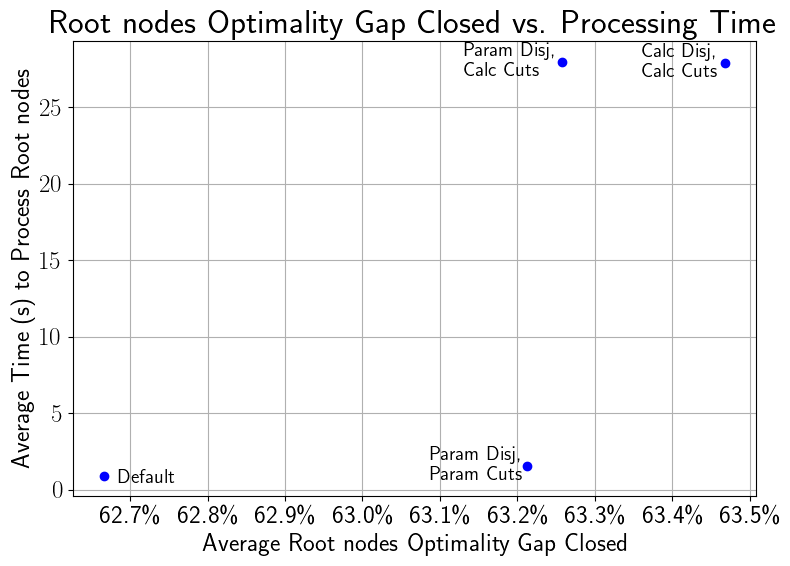

In [69]:
plt.rc('text', usetex=True)  # use latex fonts
plt.rcParams['font.size'] = 18

pareto_df = bound_df[[f for f in fields if "Root Cuts" in f or "rootDualBoundTime" in f]].mean().reset_index()
pareto_df.columns = ["key", "value"]

# Extract strength and time rows
strength_df = pareto_df[pareto_df['key'].str.contains("Root Cuts")].copy()
strength_df['category'] = strength_df['key'].str.extract(r'\((.*?)\)')
# strength_df["value"] = 100 * strength_df["value"]

time_df = pareto_df[pareto_df['key'].str.contains("rootDualBoundTime")].copy()
time_df['category'] = time_df['key'].str.extract(r'(None|Farkas|Old|New)')

# Merge data on category
merged_df = pd.merge(strength_df, time_df, on='category', suffixes=('_strength', '_time'))

# update column names
cat_map = {
    "None": "Default",
    "Farkas": "Param Disj,\nParam Cuts",
    "Old": "Param Disj,\nCalc Cuts",
    "New": "Calc Disj,\nCalc Cuts"
}
merged_df['category'] = merged_df['category'].replace(cat_map)

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['value_strength'], merged_df['value_time'], color='blue', label='Data Points')
plt.xlabel("Average Root nodes Optimality Gap Closed")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0, 1))
plt.ylabel("Average Time (s) to Process Root nodes")
plt.title("Root nodes Optimality Gap Closed vs. Processing Time", fontsize=24)
plt.grid(True)

# Annotate points with categories
for _, row in merged_df.iterrows():
    offset = (10, -5) if row['category'] == "Default" else (-60, -10) if "Param" not in row["category"] else (-70, -10)
    plt.annotate(row['category'], (row['value_strength'], row['value_time']),
                 textcoords="offset points", xytext=offset, fontsize=14)

plt.tight_layout()

plt.savefig(os.path.join(
    out_fldr, f"strength_vs_time.png"
), dpi=1200)

# plt.show()

In [70]:
# order merged_df by strength
merged_df.sort_values("value_strength", ascending=True)[["key_strength", "value_strength", "value_time"]]

key_strength  value_strength  value_time
0    Root Cuts (None)        0.626665    0.901715
3  Root Cuts (Farkas)        0.632121    1.532300
2     Root Cuts (Old)        0.632571   27.948501
1     Root Cuts (New)        0.634678   27.869697

In [71]:
# # Step 1: Group by 'instance' and count unique 'perturbation' values
# shared_instances = bound_df.groupby('instance')['perturbation'].nunique()
# 
# # Step 2: Filter to instances with exactly 3 unique perturbations
# shared_instances = shared_instances[shared_instances == 3].index
# 
# # Step 3: Filter the original DataFrame and see now what it looks like for using the same base instances throughout
# bound_df[bound_df['instance'].isin(shared_instances)].groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()

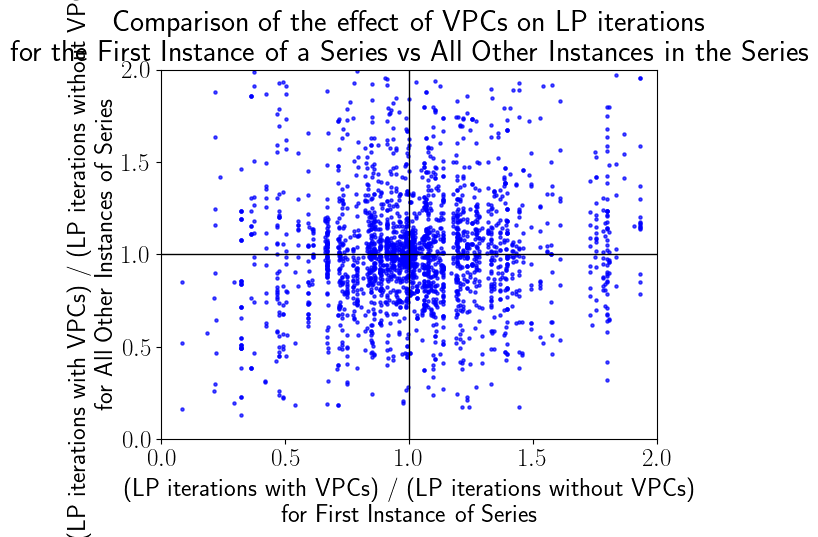

In [72]:
# if cuts helped for the base instance, do they for others?
# set which metric to compare
metric = "iterations"
name_map = {
    "terminationTime": "Running Time",
    "nodes": "nodes Processed",
    "iterations": "LP iterations",
}

# get all unique combinations of instance and perturbation in triples
unique_combinations = triples[['instance', 'perturbation']].drop_duplicates()

# append to each the first instance in the series so we can append their data later
unique_combinations["instanceIndex"] = 0

# get the data for the first instance runs
bound_start_df = df.merge(unique_combinations, on=["instance", "perturbation", "instanceIndex"])[group_cols + id_cols + fields]
data_df = bound_start_df.merge(bound_df, on=group_cols, suffixes=(" Initial", " Test"))

# make a scatter plot of the two metrics with terminationTimeRatio Initial on the x-axis and terminationTimeRatio Test on the y-axis
plt.scatter(data_df[f"{metric}Ratio Initial"], data_df[f"{metric}Ratio Test"],
            marker='o', color='blue', s=5, alpha=.7)
plt.xlabel(f"({name_map[metric]} with VPCs) / ({name_map[metric]} without VPCs)\nfor First Instance of Series")
plt.ylabel(f"({name_map[metric]} with VPCs) / ({name_map[metric]} without VPCs)\nfor All Other Instances of Series")
plt.xlim(0, 2)
plt.ylim(0, 2)   
# add horizontal and vertical lines at 1
plt.axhline(1, color='black', lw=1)
plt.axvline(1, color='black', lw=1)
plt.title(f"Comparison of the effect of VPCs on {name_map[metric]}\nfor the First Instance of a Series vs All Other Instances in the Series")
plt.savefig(os.path.join(out_fldr, f"{metric}_ratio_initial_vs_test.png"))
plt.show()

In [73]:
# Make Working Table for Branch and Bound

## Make Profiles

In [74]:
perturbation_map = {
    "matrix": "Coefficient Matrix",
    "rhs": "Right Hand Side",
    "bounds": "Variable Bounds",
    "objective": "Objective"
}
label = {
    "postRootTime": "Time after Processing Root nodes",
    "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
    "terminationTimeSansVpc": "Time (Minus VPC Generation)",
    "terminationTime": "Time",
    "nodes": "nodes Processed",
    "iterations": "LP iterations",
}
unit = {
    "postRootTime": "(seconds)",
    "rootDualBoundTimeSansVpc": "(seconds)",
    "terminationTimeSansVpc": "(seconds)",
    "terminationTime": "(seconds)",
    "nodes": "(1000 nodes)",
    "iterations": "(1000 iterations)",
}
limits = {
    "postRootTime": 7200,
    "terminationTimeSansVpc": 7200,
    "terminationTime": 7200,
    "rootDualBoundTimeSansVpc": 5,
    "nodes": 10000,
    "iterations": 37500
}
bracket_bounds = {
    "short": (min_termination_time, short),
    "medium": (short, medium),
    "long": (medium, long)
}

def make_plots(prof_df, metric, show_all=False, perturbation=None, exclude_perturbation=False, threshold=None, bracket=None):
    
    plt.rc('text', usetex=True)  # use latex fonts
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create subplots for a grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4*len(unique_terms), 4*len(unique_degrees)))
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                    else subset_df[subset_df["perturbation"] != perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
                
            # if we are looking at a specific bracket, filter for it
            if bracket is not None:
                subset_df = subset_df[subset_df["bracket"] == bracket]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap $\leq 10^{-4}$")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(0.8, 1.05)  # 0.8 if "Time" in metric else 0.9
    
    
    fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                 f'{label[metric]} to Solve to Optimality\n'  # (at most 1000 Constraints and Variables'
                 f'{("Perturbing " + ("Any Element Except " if exclude_perturbation else "") + perturbation_map[perturbation]) if perturbation else ""}'
                 f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}'
                 f'{f"(Instances with Default Termination Time in [{bracket_bounds[bracket]}))" if bracket else ""}',
                 fontsize=24)

    # Adjust layout to make space for the legend below the plots
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend
    
    # Add the legend below the subplots
    handles, labels = ax.get_legend_handles_labels()  # Get legend elements from the last axis
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=12)
    
    # Save the figure with tight layout
    plt.savefig(os.path.join(
        out_fldr, f"{metric}{'_' + perturbation + ('_excluded' if exclude_perturbation else '') if perturbation else ''}{('_' + bracket) if bracket else ''}.png"
    ), dpi=1200, bbox_inches='tight')

    plt.show()

## Make time table

In [75]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = (df["Disjunction (New)"] < .9999) & (df["instanceIndex"] > 0) & (optimality_gap(df, "New") <= 1e-4) & \
    (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4) & \
       (df["terminationTime None"] > min_termination_time)
if remove_status_changes:
    mask = mask & (df["infeasibleToFeasibleTermsRatio Farkas"] == 0) & (df["feasibleToInfeasibleTermsRatio Farkas"] == 0)

# reduce to just those that ran for all combos of degree and terms
# triples = df[mask].groupby(["instance", "perturbation", "instanceIndex"]).size().reset_index().rename(columns={0: "count"})
# triples = triples[triples["count"] == len(degrees) * len(term_list)]
# triples = set(triples[['instance', 'perturbation', 'instanceIndex']].itertuples(index=False, name=None))
# mask = mask & df[['instance', 'perturbation', 'instanceIndex']].apply(tuple, axis=1).isin(triples)

# create time dataframe
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

degree  terms  terminationTime New  terminationTime Old  \
0     0.5      4           778.228406           655.773520   
1     0.5     16           797.585194           698.443815   
2     0.5     64           558.153493           571.468598   
3     2.0      4          1802.501987           686.601407   
4     2.0     16           951.173132           848.381914   
5     2.0     64           537.290823           591.437997   

   terminationTime Farkas  terminationTime None  terminationTimeSansVpc New  \
0              379.641000            374.593827                  385.078696   
1              417.364118            371.815483                  425.242493   
2              468.876787            409.731923                  465.535784   
3              399.343280            374.042556                  382.640859   
4              449.903173            416.695463                  452.474869   
5              411.425151            406.691210                  436.332794   

   terminationTimeSansVpc Old  terminationTimeSansVpc Farkas  \
0                  399.436250                     379.453608   
1                  404.978347                     416.236636   
2                  476.184830                     466.784111   
3                  389.997266                     399.068926   
4                  459.296032                     447.078803   
5                  445.079295                     409.211996   

   terminationTimeSansVpc None  ...  postRootTime New  postRootTime Old  \
0                   374.593827  ...        382.389464        396.813033   
1                   371.815483  ...        423.136146        402.888074   
2                   409.731923  ...        464.290679        474.961351   
3                   374.042556  ...        379.828981        387.140825   
4                   416.695463  ...        450.183569        457.076763   
5                   406.691210  ...        434.929744        443.722993   

   postRootTime Farkas  postRootTime None  vpcGenerationTime New  \
0           376.723812         371.880693             393.149710   
1           414.079607         369.635166             372.342701   
2           465.573232         408.536174              92.617708   
3           395.953677         371.097659            1419.861129   
4           444.813942         414.394024             498.698264   
5           407.879957         405.300245             100.958029   

   vpcGenerationTime Old  vpcGenerationTime Farkas  \
0             256.337270                  0.187392   
1             293.465468                  1.127481   
2              95.283768                  2.092676   
3             296.604140                  0.274354   
4             389.085882                  2.824370   
5             146.358702                  2.213155   

   terminationTimeImprovement  instance  instanceIndex  
0                   -0.170282       100            697  
1                   -0.240633        96            559  
2                   -0.292378        74            405  
3                   -0.476626       102            623  
4                   -0.650869        93            510  
5                   -0.169787        76            360  

[6 rows x 24 columns]

In [76]:
# now break it down by type of perturbation
out = time_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time_by_perturbation.csv"), index=False, mode="w")
out

degree  terms perturbation  terminationTime New  terminationTime Old  \
0      0.5      4       matrix          1222.524412           752.712772   
1      0.5      4    objective           641.786803           660.546555   
2      0.5      4          rhs           464.885124           440.599835   
3      0.5     16       matrix          1030.308883           677.316343   
4      0.5     16    objective           753.510926           763.435925   
5      0.5     16          rhs           585.594158           493.598968   
6      0.5     64       matrix           587.999509           580.898078   
7      0.5     64    objective           531.578585           571.297116   
8      0.5     64          rhs           589.995711           558.647686   
9      2.0      4        bound          6953.334934          1026.052964   
10     2.0      4       matrix          3695.799618           939.135680   
11     2.0      4    objective           515.953988           547.537556   
12     2.0      4          rhs           492.313870           661.788706   
13     2.0     16        bound          1144.247733          1290.929299   
14     2.0     16       matrix          1847.641949          1074.062653   
15     2.0     16    objective           630.600179           623.201537   
16     2.0     16          rhs          1013.148549          1247.855931   
17     2.0     64        bound          1097.404295          1098.095141   
18     2.0     64       matrix           528.388053           612.543488   
19     2.0     64    objective           440.697113           452.129685   
20     2.0     64          rhs           699.735828           946.806723   

    terminationTime Farkas  terminationTime None  terminationTimeSansVpc New  \
0               320.943641            312.173144                  348.009793   
1               400.785239            392.794935                  388.662871   
2               407.784132            422.730703                  444.369893   
3               388.821139            356.249660                  420.460011   
4               436.625211            382.219749                  422.634666   
5               392.457022            358.598826                  442.508269   
6               498.292141            424.136153                  495.409826   
7               423.901398            382.913311                  410.534035   
8               552.517433            464.029023                  576.423412   
9               662.485058            589.269123                  702.156224   
10              456.905622            430.218007                  425.915797   
11              327.375700            308.870677                  306.410615   
12              426.085483            412.322711                  403.047304   
13              781.405983            648.252899                  818.761845   
14              547.107162            506.529323                  580.465854   
15              321.797128            320.566932                  309.720947   
16              653.345800            558.465345                  651.026290   
17              887.287989            956.367286                  924.763012   
18              425.383272            420.598218                  498.993098   
19              299.108203            304.686470                  328.070679   
20              664.769852            570.124025                  598.118515   

    terminationTimeSansVpc Old  terminationTimeSansVpc Farkas  ...  \
0                   338.875458                     320.676637  ...   
1                   421.279759                     400.612081  ...   
2                   428.353765                     407.696299  ...   
3                   389.794138                     387.485041  ...   
4                   424.194323                     435.397378  ...   
5                   358.772929                     392.033444  ...   
6                   486.307055                     495.398554  ...   
7         

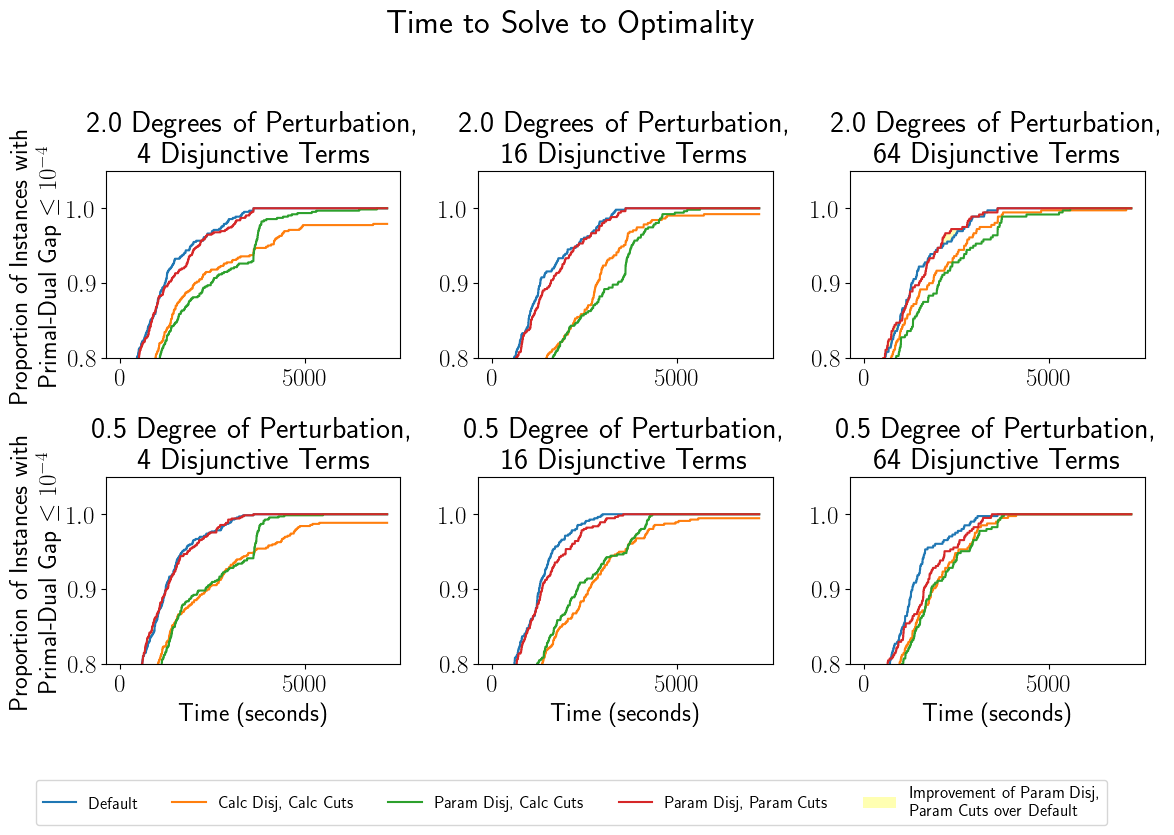

In [77]:
make_plots(time_df, "terminationTime", show_all=True)

In [78]:
# make_plots(time_df, "terminationTime", show_all=True, perturbation="matrix")
# make_plots(time_df, "terminationTime", show_all=True, perturbation="objective")
# make_plots(time_df, "terminationTime", show_all=True, perturbation="rhs")

In [79]:
# make_plots(time_df, "terminationTime", show_all=True, bracket="short")
# make_plots(time_df, "terminationTime", show_all=True, bracket="medium")
# make_plots(time_df, "terminationTime", show_all=True, bracket="long")

# Make nodes table

In [80]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
nodes_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    nodes_df[f] = nodes_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = nodes_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "nodes.csv"), index=False, mode="w")
out

degree  terms   nodes New   nodes Old  nodes Farkas  nodes None  \
0     0.5      4  416.856505  441.706725    404.558845  417.270291   
1     0.5     16  360.912791  366.705746    363.200612  342.731878   
2     0.5     64  596.974909  632.639402    609.703968  604.788479   
3     2.0      4  337.327920  346.122889    334.097872  334.828022   
4     2.0     16  409.390778  427.695486    417.750010  400.716725   
5     2.0     64  466.080642  466.780081    447.026828  438.535256   

   terminationTimeImprovement  instance  instanceIndex  
0                   -0.000170       100            697  
1                   -0.000241        96            559  
2                   -0.000292        74            405  
3                   -0.000477       102            623  
4                   -0.000651        93            510  
5                   -0.000170        76            360

In [81]:
# now break it down by type of perturbation
out = nodes_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time_by_perturbation.csv"), index=False, mode="w")
out

degree  terms perturbation    nodes New    nodes Old  nodes Farkas  \
0      0.5      4       matrix   221.234917   227.527611    216.572782   
1      0.5      4    objective   389.475289   415.233456    395.492395   
2      0.5      4          rhs   926.507573   984.807375    821.021573   
3      0.5     16       matrix   287.142958   309.384441    284.423469   
4      0.5     16    objective   228.398394   251.450092    251.620239   
5      0.5     16          rhs   966.320584   882.273674    899.738966   
6      0.5     64       matrix   355.121436   366.606027    398.017927   
7      0.5     64    objective   502.319184   568.938129    537.164323   
8      0.5     64          rhs  1201.387397  1185.034885   1110.044577   
9      2.0      4        bound   207.050379   196.834076    187.573045   
10     2.0      4       matrix   432.900261   480.550975    470.792445   
11     2.0      4    objective   280.876434   267.806349    268.478118   
12     2.0      4          rhs   577.511027   648.330189    567.740770   
13     2.0     16        bound   223.107778   287.481296    215.401352   
14     2.0     16       matrix   734.804355   624.619161    637.541376   
15     2.0     16    objective   238.453201   286.027559    283.271862   
16     2.0     16          rhs   947.710153   975.572000    949.404034   
17     2.0     64        bound   405.427346   481.538769    347.333808   
18     2.0     64       matrix  1038.835365   978.378730    920.376270   
19     2.0     64    objective   252.488393   241.652112    251.622205   
20     2.0     64          rhs   749.870043   845.806128    798.976596   

     nodes None  terminationTimeImprovement  instance  instanceIndex  
0    202.451886                   -0.000061        62            193  
1    419.632662                   -0.000202        86            408  
2    839.104719                   -0.000255        38             96  
3    265.407168                   -0.000166        53            143  
4    231.944602                   -0.000283        78            327  
5    874.022584                   -0.000206        38             89  
6    342.382145                   -0.000240        44            110  
7    553.717673                   -0.000253        64            217  
8   1116.930295                   -0.000477        32             78  
9    154.759045                   -0.002465        21             66  
10   437.229983                   -0.000304        44            119  
11   281.047725                   -0.000269        88            364  
12   595.297581                   -0.000002        32             74  
13   182.859019                   -0.004064        15             54  
14   595.035258                   -0.000262        37             93  
15   278.143941                   -0.000231        79            304  
16   925.374678                   -0.000305        26             59  
17   306.975923                   -0.000112        11             26  
18   858.841905                   -0.000024        29             63  
19   265.089848                   -0.000195        63            224  
20   774.556426                   -0.000276        24             47

In [82]:
# make_plots(nodes_df, "nodes", show_all=True)

In [83]:
# make_plots(nodes_df, "nodes", show_all=True, perturbation='matrix')
# make_plots(nodes_df, "nodes", show_all=True, perturbation='objective')
# make_plots(nodes_df, "nodes", show_all=True, perturbation='rhs')

In [84]:
# make_plots(nodes_df, "nodes", show_all=True, bracket="short")
# make_plots(nodes_df, "nodes", show_all=True, bracket="medium")
# make_plots(nodes_df, "nodes", show_all=True, bracket="long")

# Make iterations table

In [85]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iterations_df =full_df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iterations_df[f] = iterations_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iterations_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iterations.csv"), index=False, mode="w")
out

degree  terms  iterations New  iterations Old  iterations Farkas  \
0     0.5      4     2621.272362     2747.708942        2597.943872   
1     0.5     16     1663.531900     1710.162669        1721.694874   
2     0.5     64     2058.384926     2101.298119        2125.908356   
3     2.0      4     1859.664747     1996.518257        1857.477094   
4     2.0     16     2218.372393     2402.927607        2322.810747   
5     2.0     64     2353.291265     2290.793561        2248.942375   

   iterations None  terminationTimeImprovement  instance  instanceIndex  
0      2530.389012                   -0.002019       101            257  
1      1892.343454                   -0.015399       110            269  
2      2104.084126                   -0.014521       103            270  
3      1703.220411                   -0.002606       101            265  
4      2309.884319                   -0.002529       100            257  
5      2201.320008                   -0.023993        96            253

In [86]:
# now break it down by type of perturbation
out = iterations_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time_by_perturbation.csv"), index=False, mode="w")
out

degree  terms perturbation  iterations New  iterations Old  \
0      0.5      4        bound     1270.210333     1270.210333   
1      0.5      4       matrix     2554.786019     2561.836442   
2      0.5      4    objective     1954.771688     2191.769494   
3      0.5      4          rhs     4916.096937     4825.053542   
4      0.5     16        bound     2582.771000     2582.771000   
5      0.5     16       matrix      779.295160      747.888560   
6      0.5     16    objective     1540.512352     1681.871500   
7      0.5     16          rhs     3241.170900     2972.040825   
8      0.5     64        bound     2418.561800     2335.963400   
9      0.5     64       matrix     1382.194862     1380.436552   
10     0.5     64    objective     1751.701030     1833.997527   
11     0.5     64          rhs     4154.122595     4118.946738   
12     2.0      4        bound     1430.599500     1430.599500   
13     2.0      4       matrix     1972.595550     2088.105300   
14     2.0      4    objective     1833.057799     1979.175732   
15     2.0      4          rhs     1840.852649     1986.048703   
16     2.0     16        bound     6045.015000     6045.015000   
17     2.0     16       matrix      802.864140      801.075080   
18     2.0     16    objective     2185.308899     2453.149476   
19     2.0     16          rhs     4126.357579     4192.750368   
20     2.0     64        bound       99.130000       99.130000   
21     2.0     64       matrix     3020.919000     2805.113061   
22     2.0     64    objective     1736.040439     1764.676656   
23     2.0     64          rhs     3797.830000     3586.236217   

    iterations Farkas  iterations None  terminationTimeImprovement  instance  \
0         1270.210333      1594.317000                   -0.000086         3   
1         2565.454596      1979.175769                   -0.003283        36   
2         2034.245526      2133.096688                   -0.002143        85   
3         4524.656125      4460.687396                   -0.000372        33   
4         2582.771000      2292.504667                   -0.000071         3   
5          775.126980       700.087880                   -0.072615        34   
6         1648.212733      1874.136080                   -0.002764        98   
7         3163.645450      3432.763275                   -0.000625        28   
8         2418.561800      1951.817200                   -0.001923         5   
9         1403.716793      1476.477897                   -0.047188        38   
10        1861.938545      1848.419752                   -0.006558        88   
11        4125.405071      3993.301214                   -0.002191        27   
12        1430.599500      1809.870000                   -0.000060         4   
13        2056.971767      1599.544950                   -0.007101        41   
14        1803.264793      1740.438963                   -0.001503        83   
15        1820.413514      1694.844378                   -0.000479        25   
16        6045.015000      4659.831000                   -0.000263         1   
17         826.334440       764.641580                   -0.005060        34   
18        2353.645619      2394.686577                   -0.002156        85   
19        4057.583184      3906.342500                   -0.000905        27   
20          99.130000       111.501000                   -0.006079         1   
21        3093.989959      3015.389571                   -0.057637        34   
22        1600.738299      1553.788682                   -0.019988        84   
23        3607.866739      3589.642370                   -0.002216        25   

    instanceIndex  
0               3  
1              52  
2             154  
3              48  
4               3  
5              50  
6             176  
7              40  
8               5  
9              58  
10            165  
11             42  
12              4  
13             60  
14            164  
15             37  
16          

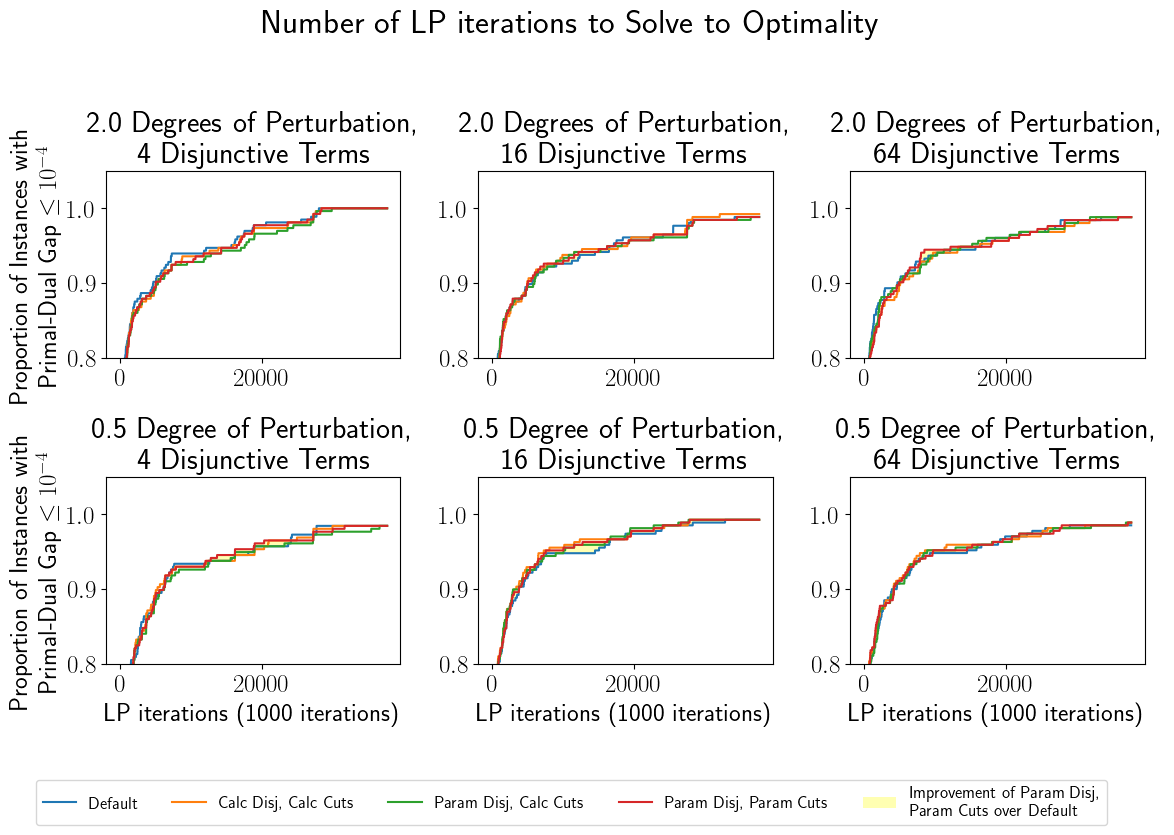

In [87]:
make_plots(iterations_df, "iterations", show_all=True)

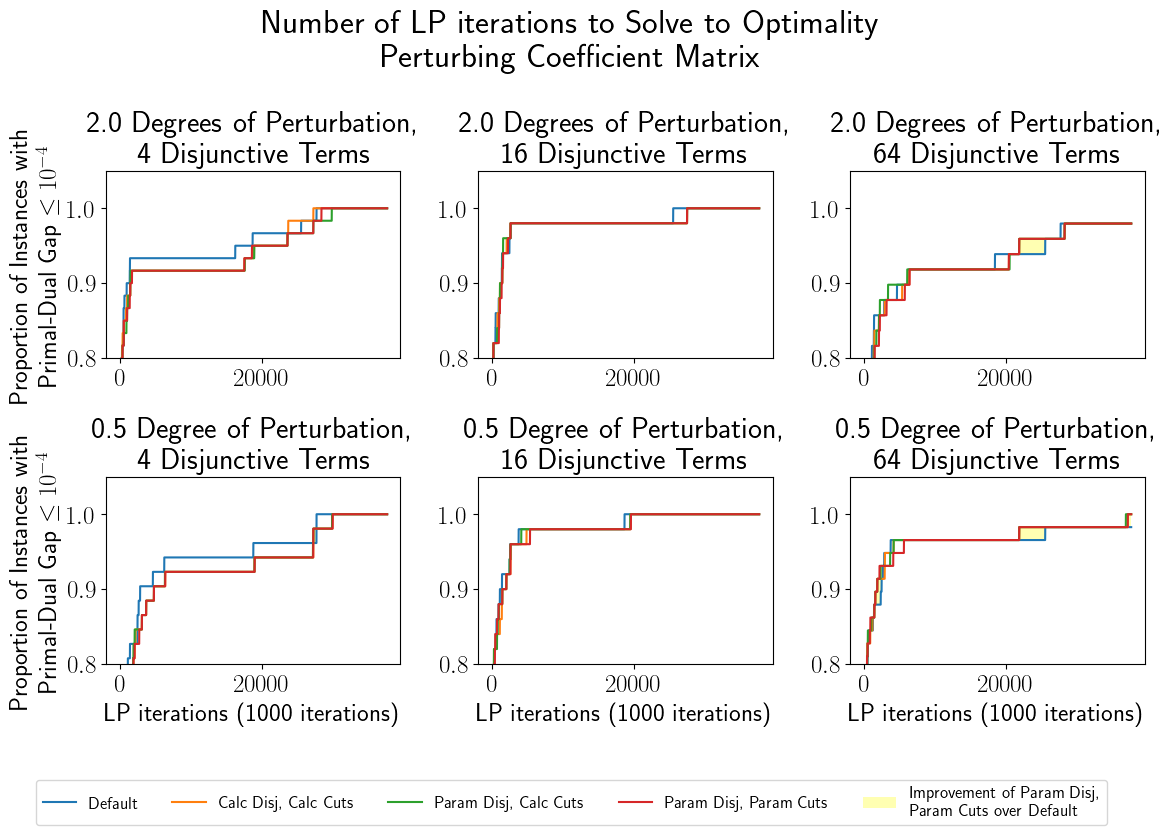

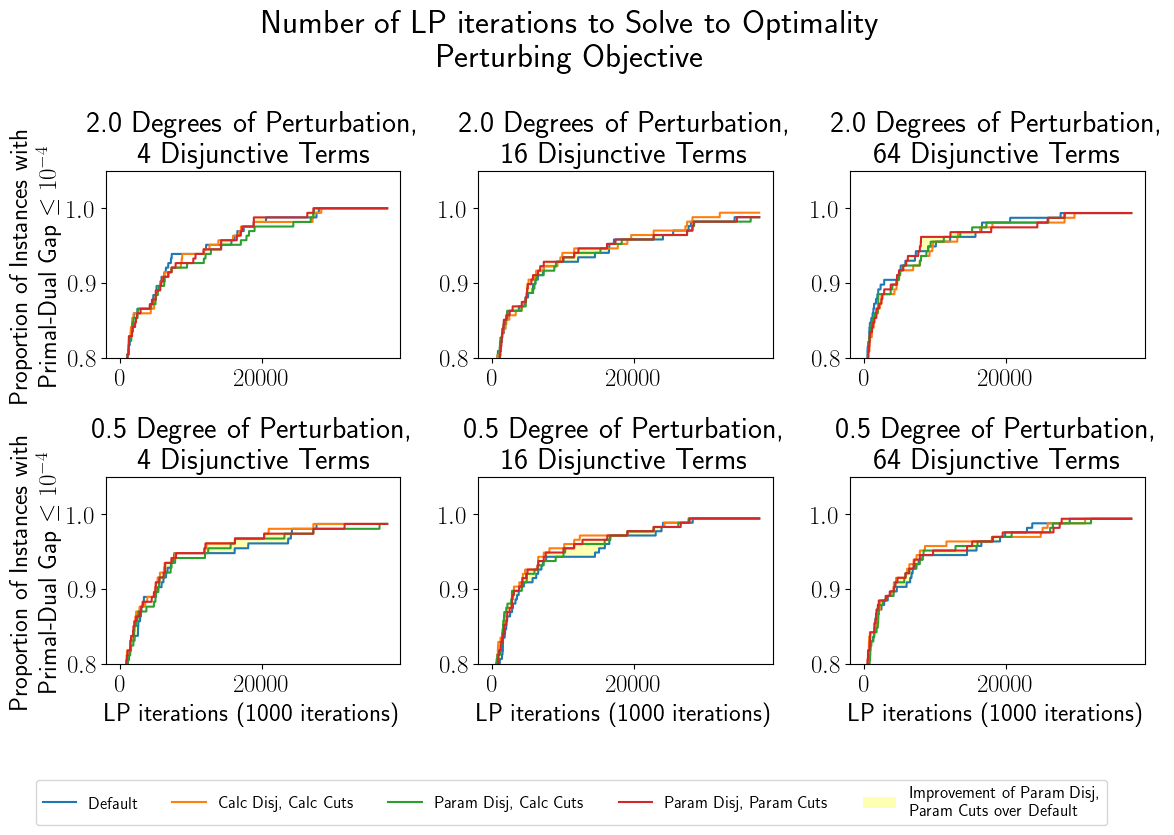

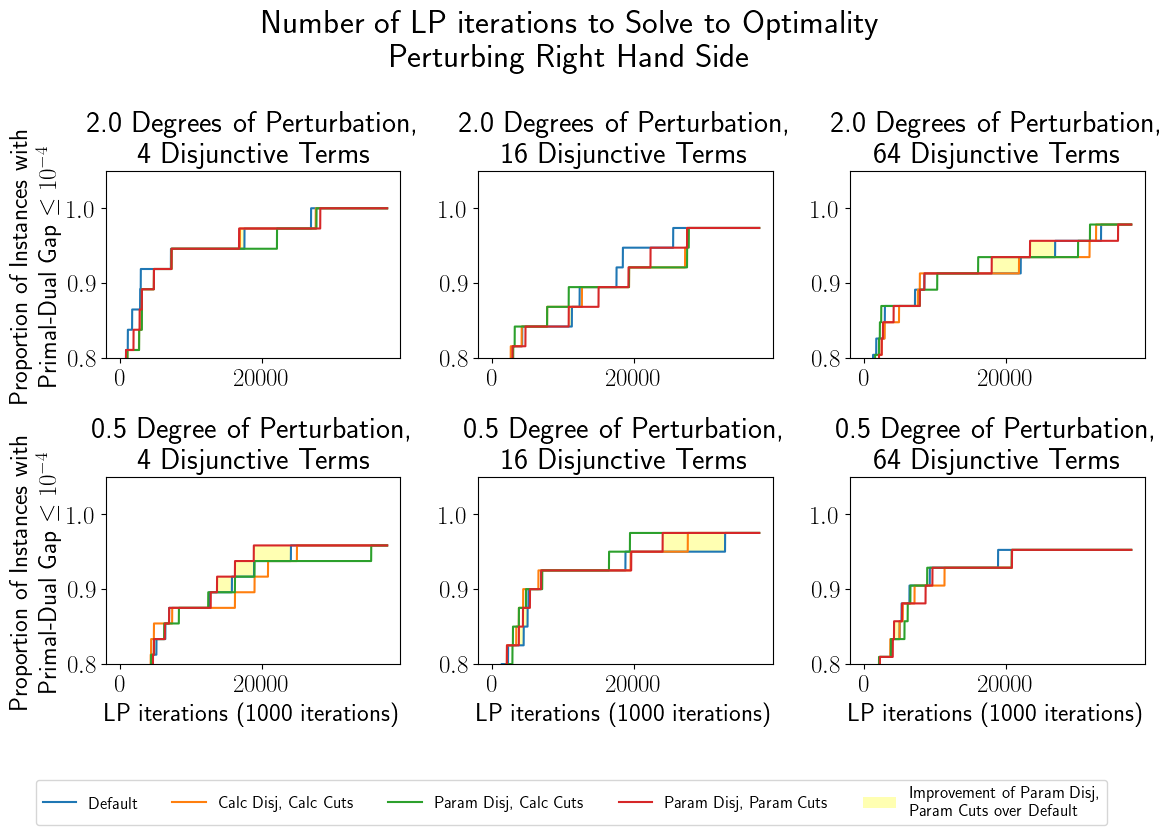

In [88]:
make_plots(iterations_df, "iterations", show_all=True, perturbation='matrix')
make_plots(iterations_df, "iterations", show_all=True, perturbation='objective')
make_plots(iterations_df, "iterations", show_all=True, perturbation='rhs')

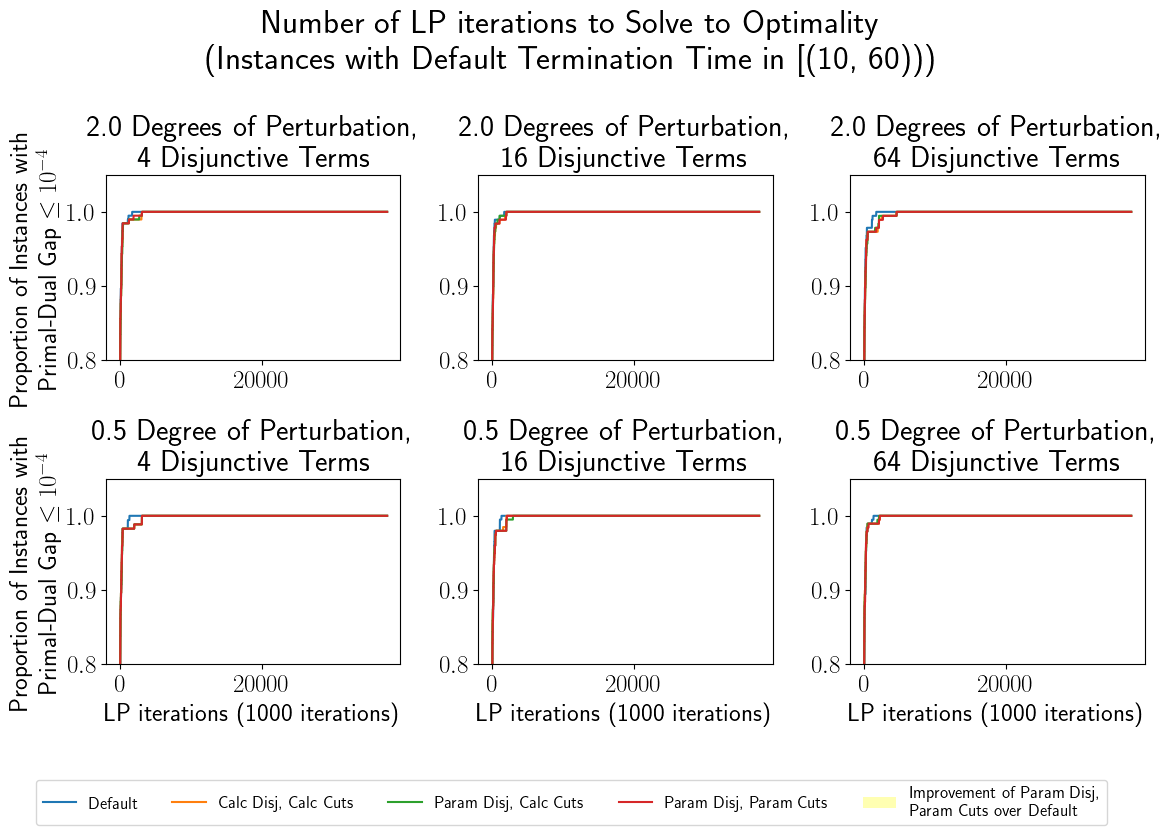

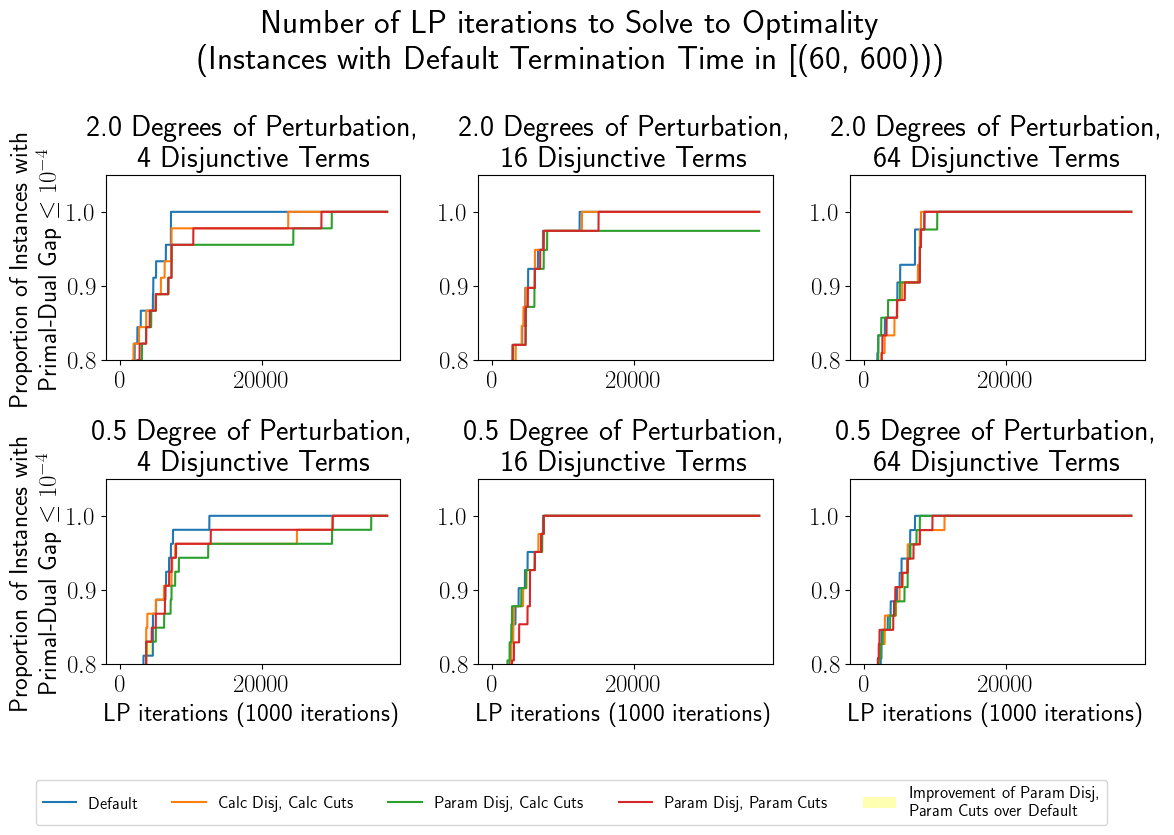

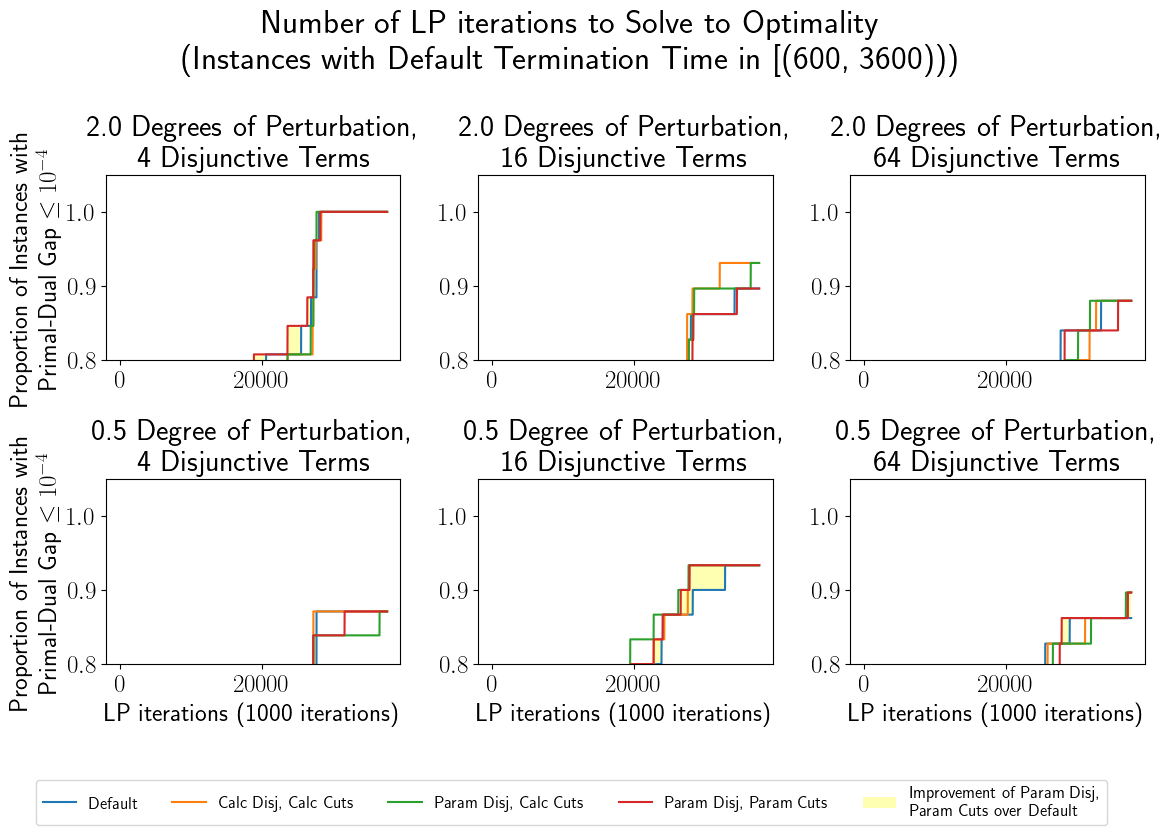

In [89]:
make_plots(iterations_df, "iterations", show_all=True, bracket='short')
make_plots(iterations_df, "iterations", show_all=True, bracket='medium')
make_plots(iterations_df, "iterations", show_all=True, bracket='long')

## Improvement Consistency

In [90]:
# Define the custom formatter function
def multiply_by_100(x, pos):
    return '%1.0f' % (x * 100)

# Create a FuncFormatter object
formatter = FuncFormatter(multiply_by_100)

def make_run_time_boxplot(time_df, perturbation=None, threshold=.1, best=False):
    plt.rc('text', usetex=True)  # use latex fonts
    plt.rcParams['font.size'] = 18

    # Get unique values of degree and terms
    degrees = time_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    terms = time_df['terms'].sort_values().unique()  # sort decreasing
    
    if best:
        degrees = [degrees[-1]]
        terms = [terms[-1]]
    
    # Create a grid of subplots
    fig, axes = plt.subplots(len(terms), len(degrees), figsize=(8*len(degrees), 4*len(terms)) if not best else (12, 6))
    
    # Iterate through each combination of degree and terms
    for i, term in enumerate(terms):
        for j, degree in enumerate(degrees):
            
            current_ax = axes if best else axes[i, j]
            
            # get the data for this combination
            subset = time_df[(time_df['terms'] == term) &
                             (time_df['degree'] == degree)]
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset = subset[subset["perturbation"] == perturbation]
                
            cut_off = subset["terminationTimeImprovement"].quantile(1 - threshold)
            
            # now break it down by instance
            unique_instances = subset['instance'].sort_values().unique()
            instance_data = [subset[subset['instance'] == instance]['terminationTimeImprovement'].tolist()
                             for instance in unique_instances]
            
            # make all the boxplots for this plot
            current_ax.boxplot(instance_data, labels=unique_instances)
            current_ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=.5)
            if not best:
                current_ax.set_ylim(-3, 1)
                current_ax.set_xticklabels([])
            else:
                current_ax.set_xticklabels(current_ax.get_xticklabels(), rotation=90, fontsize=10)
                current_ax.set_ylim(-2, 1)
            current_ax.yaxis.set_major_formatter(formatter)  # Apply the custom formatter
            current_ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation"
                                 + ('\n' if not best else ' and ') + f"{term} Disjunctive Terms")
            if j == 0:
                current_ax.set_ylabel('\% Improvement')
            # if i == len(terms) - 1 and (best or j == len(degrees)//2):
            #     current_ax.set_xlabel('(Each set of box and whiskers represents the perturbations of one presolved MIPLIB 2017 Instance)')
            
    
    if not best:
        fig.suptitle(f"Distributions of Relative Time Improvement for Param Disj, "
                     f"Param Cuts compared to Default"
                     f"{' - perturbing only ' + perturbation_map[perturbation] if perturbation else ''}\n"
                     f"(positive values imply Param Disj, Param Cuts'"
                     f" run time faster than Default's)")
        fig.text(0.5, 0.02, '(Each set of box and whiskers represents distribution of relative improvements for the perturbations of one presolved MIPLIB 2017 Instance)',
                 ha='center', va='center', fontsize=14)
    else:
        fig.suptitle(f"Relative Termination Time Improvements between Solves with and without Param. VPCs ", fontsize=24, x=.5, y=1.0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_fldr, f"time_improvement_distribution_by_base_instance"
                                       f"{'_' + perturbation if perturbation else '_best' if best else ''}.png"),
                dpi=1200)
    if not best:
        plt.legend()
    plt.show()

In [91]:
# make_run_time_boxplot(time_df, best=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


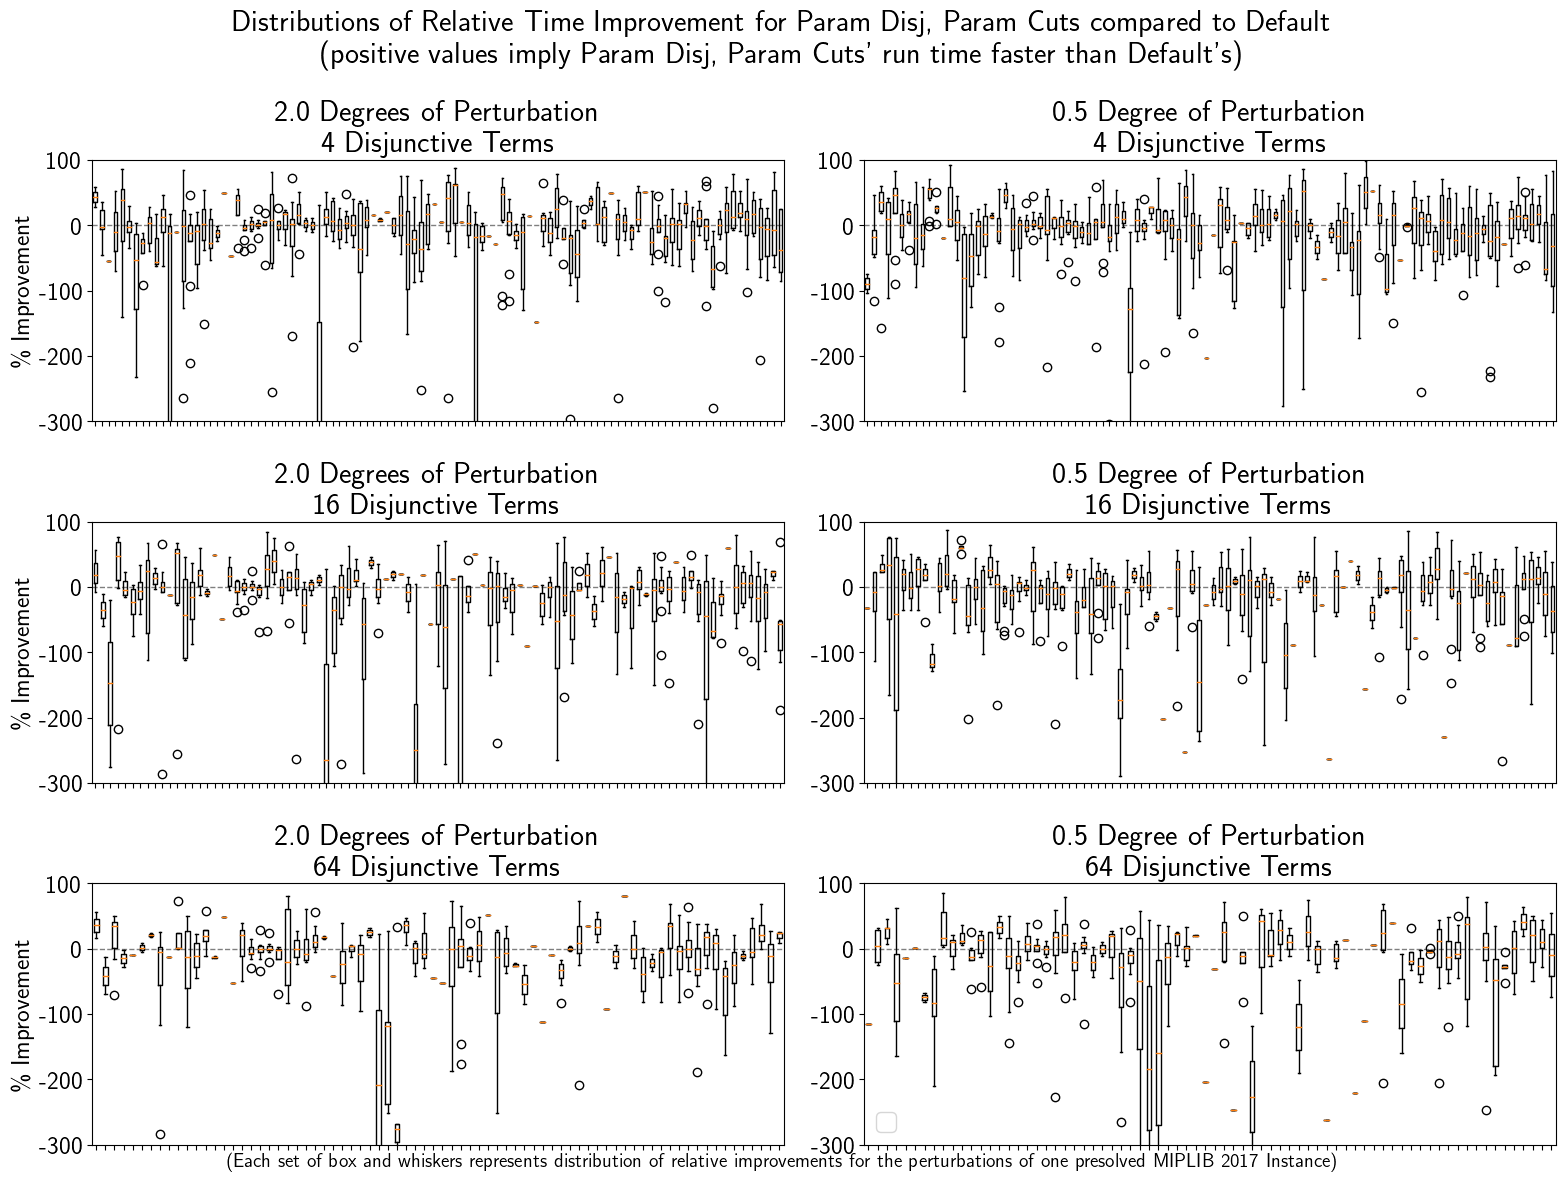

In [92]:
make_run_time_boxplot(time_df)

In [93]:
# make_run_time_boxplot(time_df, perturbation="matrix")
# make_run_time_boxplot(time_df, perturbation="objective")
# make_run_time_boxplot(time_df, perturbation="rhs")

In [94]:
# get a table of all unperturbed instances that solved to optimality
df_zero = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) & (optimality_gap(df_map["None"]) <= 1e-4) & (df_map["None"]["terminationTime"] > min_termination_time)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


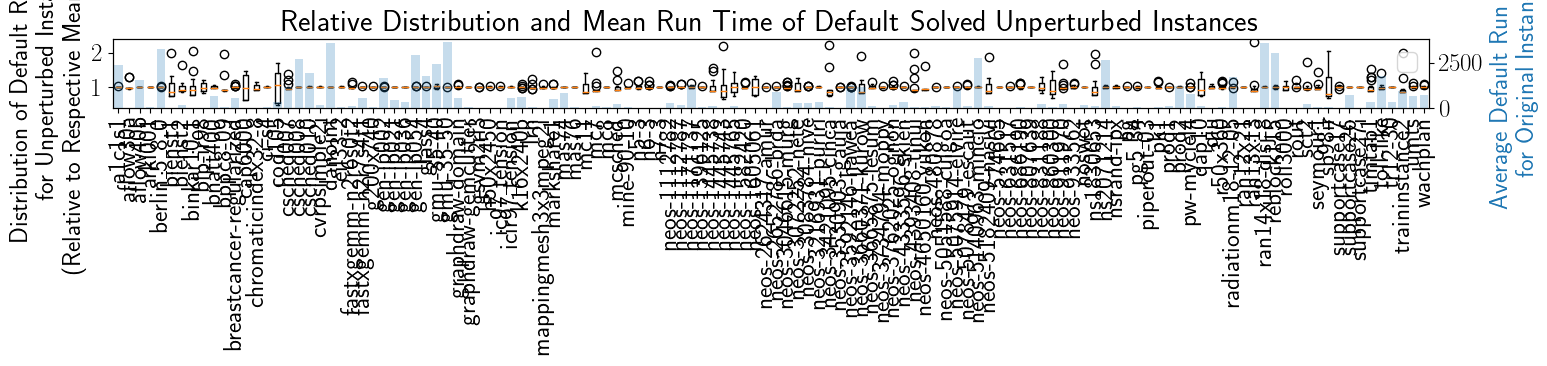

In [95]:
# configure plot
plt.rc('text', usetex=True)
fig, ax1 = plt.subplots(figsize=(16, 4))

# now break it down by instance
mean_run = df_zero.groupby("instance")["terminationTime"].mean().to_dict()
data = {instance: df_zero[df_zero['instance'] == instance]['terminationTime'].values / time
         for instance, time in mean_run.items()}

# make all the boxplots for this plot
ax1.boxplot(data.values(), labels=data.keys())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Distribution of Default Run Times\nfor Unperturbed Instances\n'
               '(Relative to Respective Mean Run Time)')
ax1.set_title("Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances")

# make the barchart for this plot
ax2 = ax1.twinx()
color = 'tab:blue'
plt.bar(np.arange(1, len(mean_run) + 1), mean_run.values(), alpha=.25, color=color)
ax2.set_ylabel('Average Default Run Times\nfor Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution.png"), dpi=1200)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


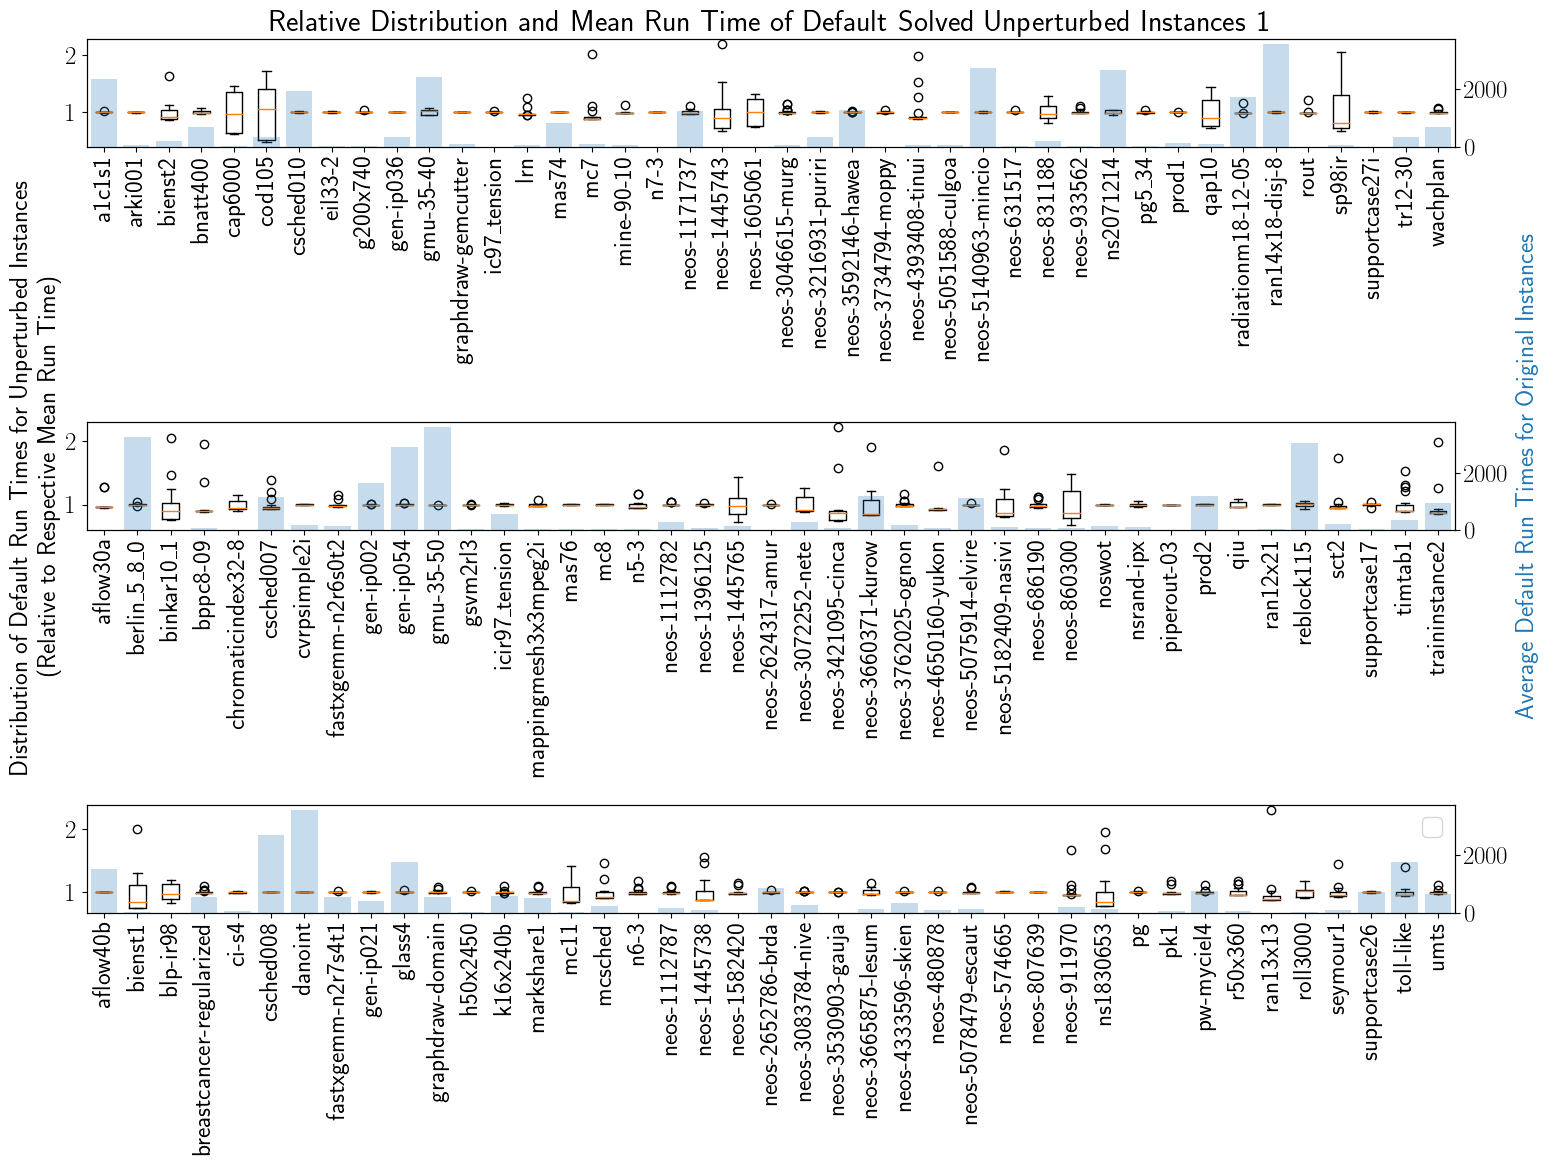

In [96]:
mean_run1 = {k: v for i, (k, v) in enumerate(mean_run.items()) if i % 3 == 0}
mean_run2 = {k: v for i, (k, v) in enumerate(mean_run.items()) if i % 3 == 1}
mean_run3 = {k: v for i, (k, v) in enumerate(mean_run.items()) if i % 3 == 2}
data1 = {k: data[k] for k in mean_run1}
data2 = {k: data[k] for k in mean_run2}
data3 = {k: data[k] for k in mean_run3}

datasets = [data1, data2, data3]
mean_runs = [mean_run1, mean_run2, mean_run3]
titles = ["Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances 1",
          "Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances 2",
          "Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances 3"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

for i, (ax1, datax, mean_runx, title) in enumerate(zip(axes, datasets, mean_runs, titles)):
    # Create boxplot
    ax1.boxplot(datax.values(), labels=datax.keys())
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    
    if i == 1:
        ax1.set_ylabel('Distribution of Default Run Times for Unperturbed Instances\n'
                       '(Relative to Respective Mean Run Time)')
    if i == 0:
        ax1.set_title(title)
    
    # Create bar chart
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.bar(np.arange(1, len(mean_runx) + 1), mean_runx.values(), alpha=.25, color=color)
    if i == 1:
        ax2.set_ylabel('Average Default Run Times for Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution_stacked.png"), dpi=1200)
plt.legend()
plt.show()

## Check Root Optimality Gap Relationships

In [97]:
# these are the subset solved to optimality
# reasonable_std = [k for k, v in data.items() if v.std() < max_base_std]
gap_df = df.loc[mask]

In [98]:
gap_df.head()

instanceIndex vpcGenerator None  terms   lpBound None  \
19              1              None     16  906793.399681   
23              1              None      4    2432.537572   
24              2              None      4    2455.531372   
25              3              None      4    2469.341086   
26              4              None      4    2522.739825   

    disjunctiveDualBound None  lpBoundPostVpc None  rootDualBound None  \
19              906793.399681        906793.399681        9.106540e+06   
23                2432.537572          2432.537572        2.569921e+03   
24                2455.531372          2455.531372        2.647265e+03   
25                2469.341086          2469.341086        2.599561e+03   
26                2522.739825          2522.739825        2.649593e+03   

    dualBound None  primalBound None  vpcGenerationTime None  ...  \
19    9.135598e+06      9.135926e+06                0.000002  ...   
23    2.691000e+03      2.691000e+03                0.000002  ...   
24    2.724000e+03      2.724000e+03                0.000003  ...   
25    2.672000e+03      2.672000e+03                0.000004  ...   
26    2.708000e+03      2.708000e+03                0.000002  ...   

    zeroInfeasibleToFeasibleTerms New  feasibleToInfeasibleTermsRatio New  \
19                               True                                 0.0   
23                               True                                 0.0   
24                               True                                 0.0   
25                               True                                 0.0   
26                               True                                 0.0   

    infeasibleTermsRatio Old  infeasibleToFeasibleTermsRatio Old  \
19                  0.736842                                 0.0   
23                  0.000000                                 0.0   
24                  0.000000                                 0.0   
25                  0.000000                                 0.0   
26                  0.000000                                 0.0   

    zeroInfeasibleToFeasibleTerms Old  feasibleToInfeasibleTermsRatio Old  \
19                               True                            0.368421   
23                               True                            0.000000   
24                               True                            0.000000   
25                               True                            0.000000   
26                               True                            0.000000   

    infeasibleTermsRatio Farkas  infeasibleToFeasibleTermsRatio Farkas  \
19                     0.736842                                    0.0   
23                     0.000000                                    0.0   
24                     0.000000                                    0.0   
25                     0.000000                                    0.0   
26                     0.000000                                    0.0   

    zeroInfeasibleToFeasibleTerms Farkas feasibleToInfeasibleTermsRatio Farkas  
19                                  True                              0.368421  
23                                  True                              0.000000  
24                                  True                              0.000000  
25                                  True                              0.000000  
26                                  True                              0.000000  

[5 rows x 152 columns]

In [99]:
gap_df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'zeroInfeasibleToFeasibleTerms New',
       'feasibleToInfeasibleTermsRatio New', 'infeasibleTermsRatio Old',
       'infeasibleToFeasibleTermsRatio Old',
       'zeroInfeasibleToFeasibleTerms Old',
       'feasibleToInfeasibleTermsRatio Old', 'infeasibleTermsRatio Farkas',
       'infeasibleToFeasibleTermsRatio Farkas',
       'zeroInfeasibleToFeasibleTerms Farkas',
       'feasibleToInfeasibleTermsRatio Farkas'],
      dtype='object', length=152)

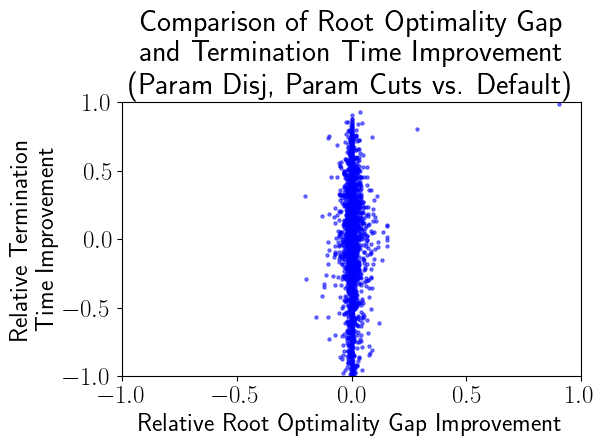

In [100]:
plt.scatter(gap_df["Root Optimality Gap Improvement"], gap_df["terminationTimeImprovement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.title("Comparison of Root Optimality Gap\nand Termination Time Improvement\n"
          "(Param Disj, Param Cuts vs. Default)")
plt.xlabel("Relative Root Optimality Gap Improvement")
plt.ylabel("Relative Termination\nTime Improvement")
plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "gap_vs_time.png"), dpi=1200)
plt.show()

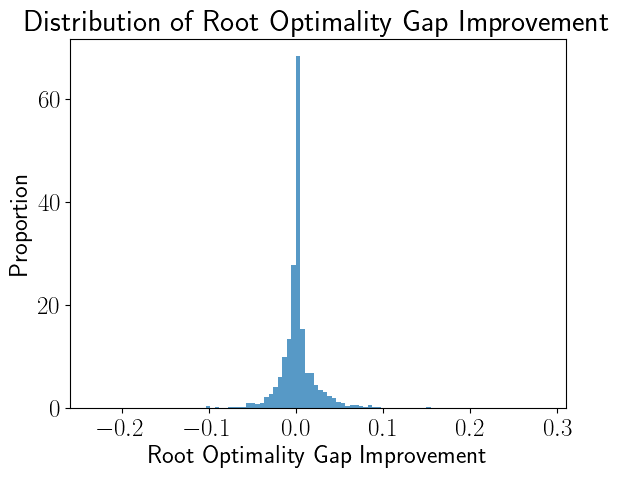

In [101]:
# Create a histogram with 100 bins
plt.hist(gap_df.loc[(-.5 < gap_df["Root Optimality Gap Improvement"]) & (gap_df["Root Optimality Gap Improvement"] < .5),
                    "Root Optimality Gap Improvement"], bins=100, density=True, alpha=0.75)

# Add labels and a title
plt.xlabel('Root Optimality Gap Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Root Optimality Gap Improvement')

# Display the plot
plt.show()

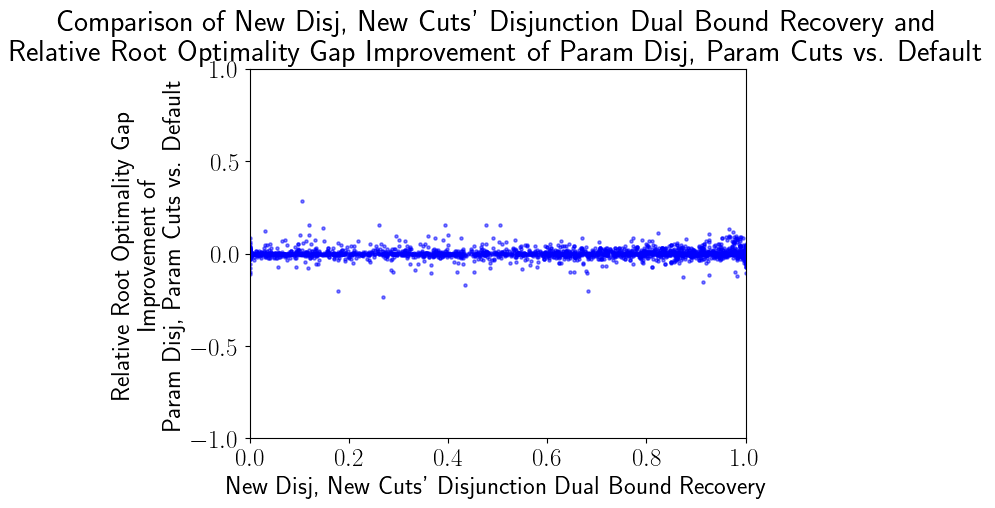

In [102]:
# is there a relationship between how much of dual bound we recover and root optimality gap improvement
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["Root Optimality Gap Improvement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(0, 1)
plt.title("Comparison of New Disj, New Cuts' Disjunction Dual Bound Recovery and\n"
          "Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Relative Root Optimality Gap\nImprovement of\nParam Disj, Param Cuts vs. Default")
plt.savefig(os.path.join(out_fldr, "vpc_dual_recover_vs_param_root_improvement.png"), dpi=1200)
plt.show()

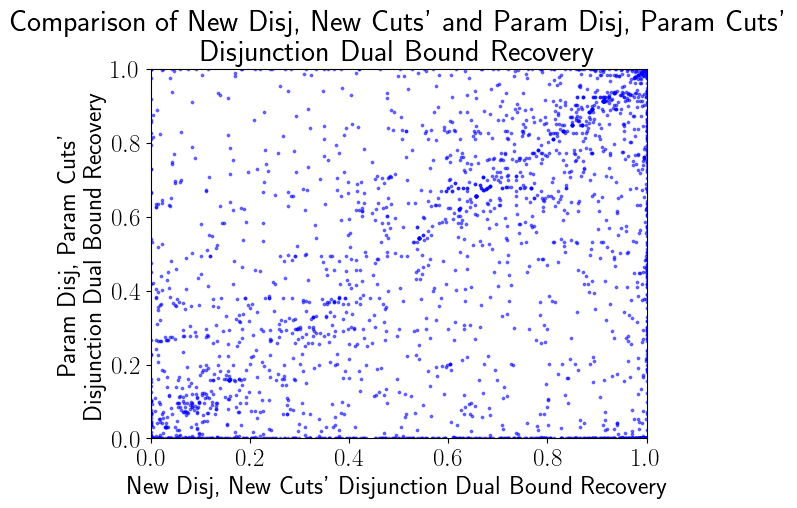

In [103]:
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["VPCs (Farkas)"] / gap_df["Disjunction (Old)"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.title("Comparison of New Disj, New Cuts' and Param Disj, Param Cuts'\nDisjunction Dual Bound Recovery")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Param Disj, Param Cuts'\nDisjunction Dual Bound Recovery")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.savefig(os.path.join(out_fldr, "vpc_vs_param_dual_bound_recover.png"), dpi=1200)
plt.show()  # todo: what happens when Param Disj, Param Cuts recovers the same amount of dual bound?

In [104]:
df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'zeroInfeasibleToFeasibleTerms New',
       'feasibleToInfeasibleTermsRatio New', 'infeasibleTermsRatio Old',
       'infeasibleToFeasibleTermsRatio Old',
       'zeroInfeasibleToFeasibleTerms Old',
       'feasibleToInfeasibleTermsRatio Old', 'infeasibleTermsRatio Farkas',
       'infeasibleToFeasibleTermsRatio Farkas',
       'zeroInfeasibleToFeasibleTerms Farkas',
       'feasibleToInfeasibleTermsRatio Farkas'],
      dtype='object', length=152)

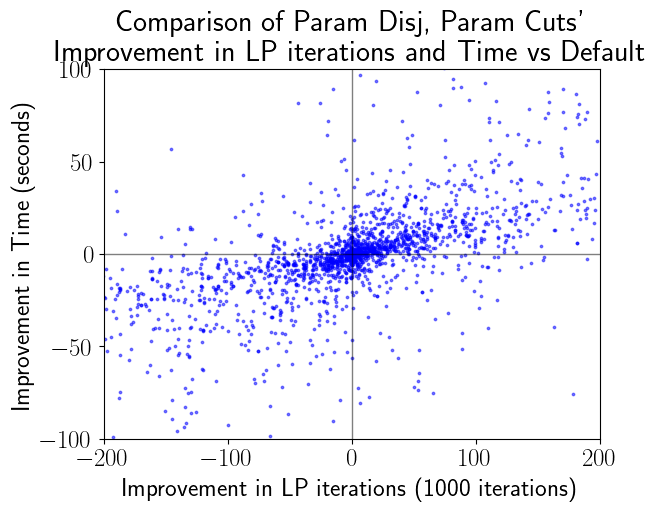

In [105]:
# plot iterations improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations None"]/1000 - gap_df["iterations Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts'\nImprovement in LP iterations and Time vs Default")
plt.xlabel("Improvement in LP iterations (1000 iterations)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "lp_iters_vs_time.png"), dpi=1200)
plt.show()

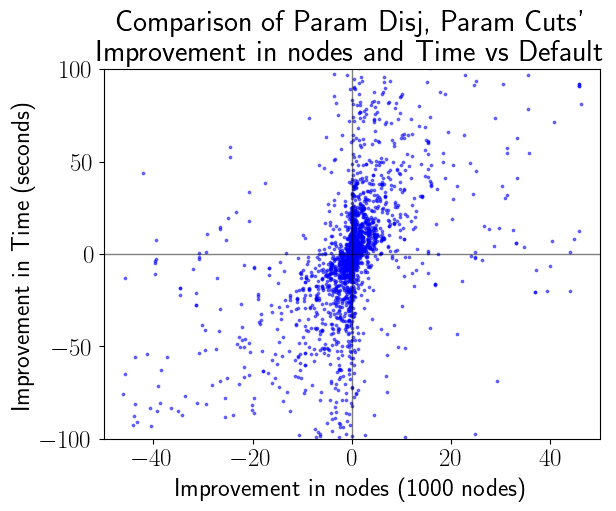

In [106]:
# plot iterations improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["nodes None"]/1000 - gap_df["nodes Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-50, 50)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts'\nImprovement in nodes and Time vs Default")
plt.xlabel("Improvement in nodes (1000 nodes)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_time.png"), dpi=1200)
plt.show()

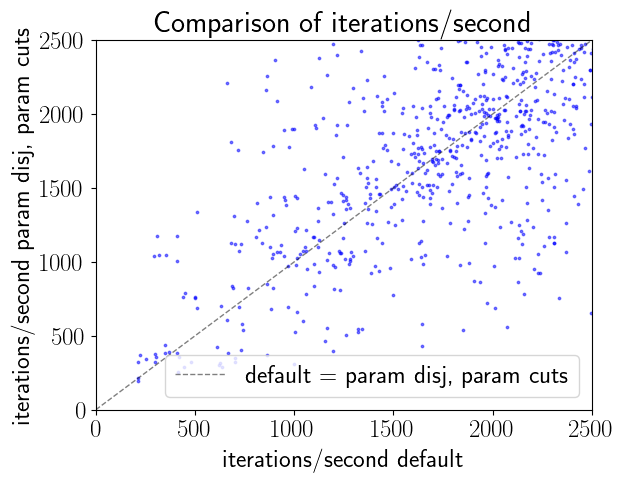

In [107]:
# plot iterations improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations Farkas"]/gap_df["terminationTimeSansVpc Farkas"],
            gap_df["iterations None"]/gap_df["terminationTimeSansVpc None"],
            marker='o', color='blue', s=3, alpha=0.5)
# plot the line y = x
x = np.linspace(0, 3000, 3000)
plt.plot(x, x, linestyle='--', color='black', linewidth=1, alpha=.5,
         label="default = param disj, param cuts")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.title("Comparison of iterations/second")
plt.xlabel("iterations/second default")
plt.ylabel("iterations/second param disj, param cuts")
plt.legend()
plt.savefig(os.path.join(out_fldr, "lp_iters_per_second.png"), dpi=1200)
plt.show()

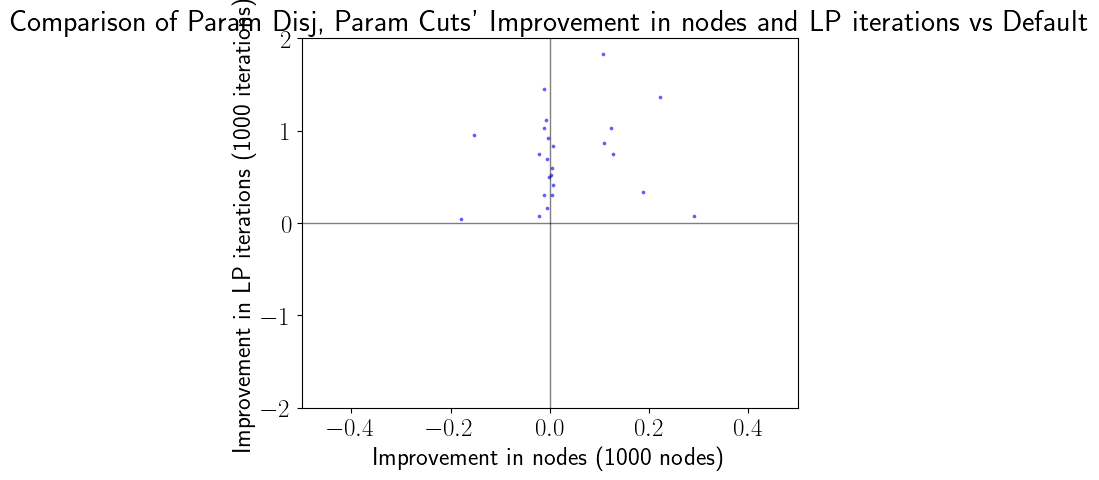

In [108]:
# plot nodes improvement over iterations improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
tdf = gap_df.loc[(gap_df["iterationsImprovement"] > 0) & (gap_df["terminationTimeImprovement"] < 0)]
plt.scatter(tdf["nodes None"]/1000 - tdf["nodes Farkas"]/1000,
            tdf["iterations None"]/1000 - tdf["iterations Farkas"]/1000,
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-.5, .5)
plt.ylim(-2, 2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in nodes and LP iterations vs Default")
plt.xlabel("Improvement in nodes (1000 nodes)")
plt.ylabel("Improvement in LP iterations (1000 iterations)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_lp_iters_werid.png"), dpi=1200)
plt.show()

In [109]:
# make tables of averages

In [110]:
cat_map = {
    "None": "Default",
    "Farkas": "Param Disj, Param Cuts",
    "Old": "Param Disj, Calc Cuts",
    "New": "Calc Disj, Calc Cuts"
}
def plot_distributions(histogram_df, feature, kind='pmf', bins=100, xlim=(-2, 1), perturbation=None, exclude_perturbation=False):
    """
    Generate a grid of histograms or cumulative distribution functions (CDFs) for a given feature,
    one for each combination of terms and degrees.

    :param histogram_df: DataFrame containing the data
    :param feature: The feature to plot (as relative improvement)
    :param kind: 'pmf' for probability mass function, 'cdf' for cumulative distribution functions
    :param bins: Number of bins in each histogram (only for 'pmf')
    :param xlim: Tuple for the x-axis limits
    :param perturbation: Specific perturbation to filter for
    :param exclude_perturbation: If True, excludes the perturbation instead of including it
    """

    plt.rc('text', usetex=True)  # Use LaTeX fonts

    # Unique values in 'degree' and 'terms'
    unique_degrees = histogram_df['degree'].sort_values(ascending=False).unique()
    unique_terms = histogram_df['terms'].sort_values().unique()

    # Create subplots for the grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4 * len(unique_terms), 4 * len(unique_degrees)))

    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j] if len(unique_degrees) > 1 and len(unique_terms) > 1 else axes

            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = histogram_df[(histogram_df['degree'] == degree) & (histogram_df['terms'] == terms)]

            # Filter or exclude specific perturbation type
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                    else subset_df[subset_df["perturbation"] != perturbation]

            # Compute relative improvements
            relative_improvements = {
                "Farkas": -(subset_df[f"{feature} None"] - subset_df[f"{feature} Farkas"]) / subset_df[f"{feature} None"],
                "New": -(subset_df[f"{feature} None"] - subset_df[f"{feature} New"]) / subset_df[f"{feature} None"],
                "Old": -(subset_df[f"{feature} None"] - subset_df[f"{feature} Old"]) / subset_df[f"{feature} None"]
            }

            if kind == "pmf":
                # Masking values below xlim[0]
                for key in relative_improvements:
                    relative_improvements[key] = relative_improvements[key].apply(lambda x: xlim[0]*1.1 if x < xlim[0]*1.1 else x)
                
                # Plot histograms
                ax.hist(relative_improvements["Farkas"], bins=bins, density=True, alpha=0.75, label="Farkas", color='blue')
            elif kind == "cdf":
                # Compute CDFs
                x = np.linspace(xlim[0], xlim[1], bins)
                y_farkas = [(relative_improvements["Farkas"] <= val).sum() / len(relative_improvements["Farkas"]) for val in x]
                y_new = [(relative_improvements["New"] <= val).sum() / len(relative_improvements["New"]) for val in x]
                y_old = [(relative_improvements["Old"] <= val).sum() / len(relative_improvements["Old"]) for val in x]

                ax.plot(x, y_farkas, label=cat_map["Farkas"], color="blue")
                ax.plot(x, y_new, label=cat_map["New"], color="green")
                ax.plot(x, y_old, label=cat_map["Old"], color="orange")

                # Highlight the region where Farkas is better than both New and Old
                fill_region = [y_farkas[k] > max(y_new[k], y_old[k]) for k in range(len(x))]
                ax.fill_between(x, np.maximum(y_new, y_old), y_farkas, where=fill_region,
                                facecolor='yellow', alpha=0.3,
                                label=f'Improvement of {cat_map["Farkas"]}\nover {cat_map["New"]} and {cat_map["Old"]}')

            # Set plot limits and labels
            ax.set_xlim(xlim)
            ax.set_ylim(0, 1 if kind == "cdf" else 2)
            ax.set_title(f"{degree} Degree{'s' if degree > 1 else ''}, {terms} Terms")
            if j == 0:
                ax.set_ylabel("Cumulative Distribution" if kind == "cdf" else r"\% of Experiment Set")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel("Relative Improvement" if kind == "pmf" else r"Relative Change")

    # Add a common legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=12)

    # Adjust layout and add a title
    fig.suptitle(f"{'Probability' if kind == 'pmf' else 'Cumulative'} Distribution of {feature} Improvement",
                 fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # Show the plot
    plt.show()

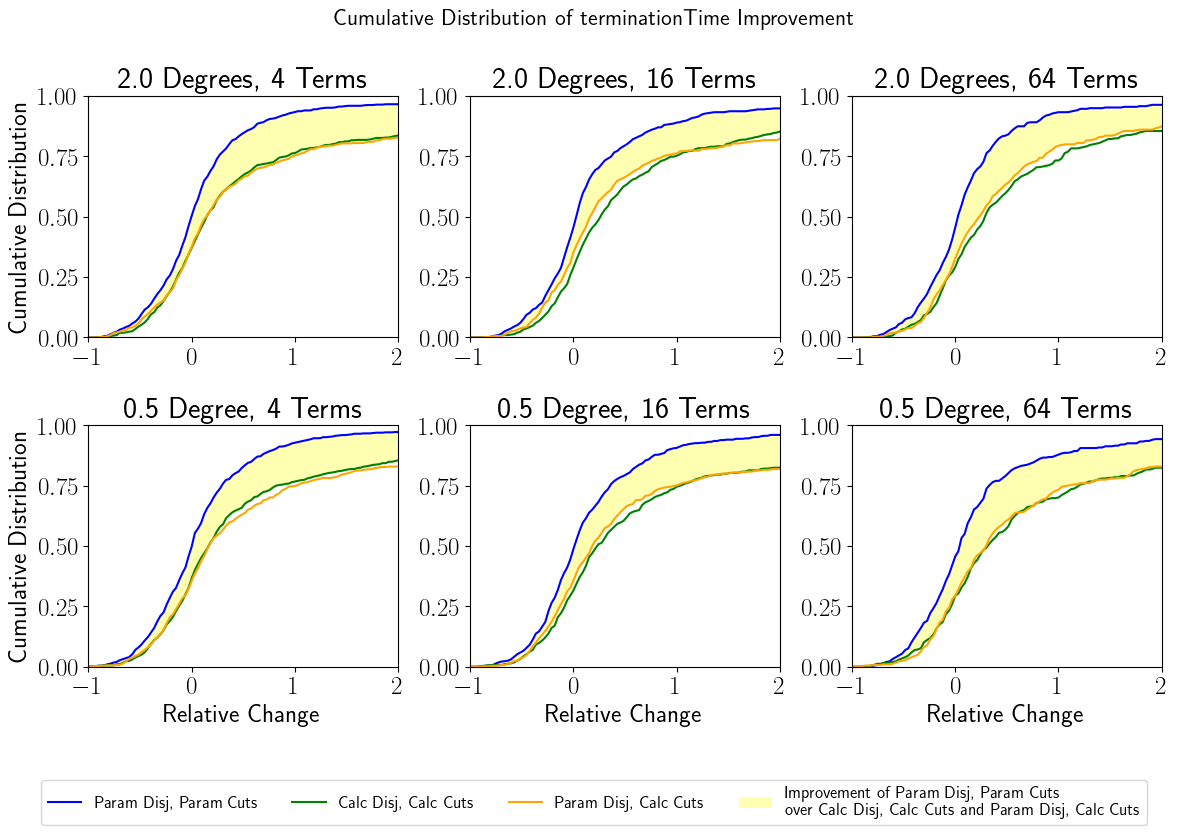

In [111]:
plot_distributions(gap_df, "terminationTime", kind='cdf', xlim=(-1, 2))

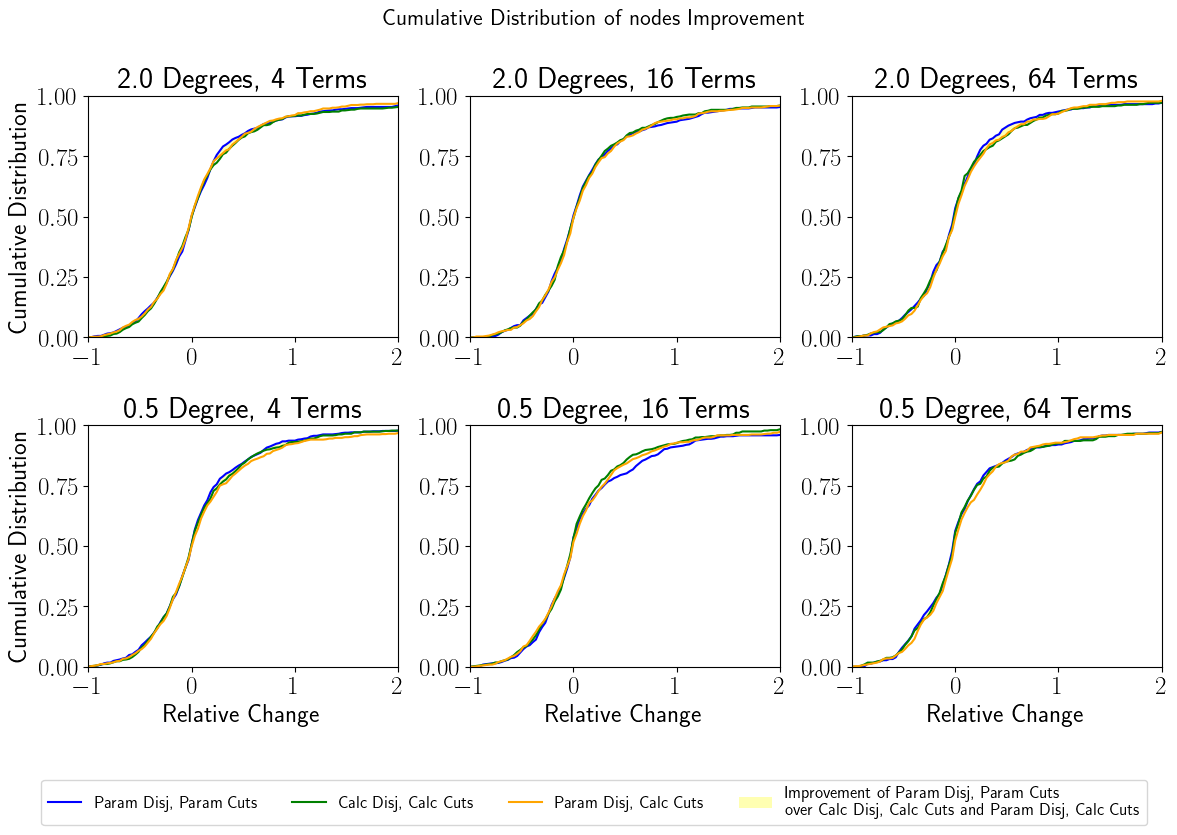

In [180]:
plot_distributions(gap_df, "nodes", kind='cdf', xlim=(-1, 2))

In [111]:
def make_histograms(histogram_df, feature, kind='histogram', bins=100, xlim=(-2, 1), perturbation=None, exclude_perturbation=False):
    """
    Generate a grid of histograms for a given feature, one for each combination of terms and degrees.
    
    :param histogram_df: DataFrame containing the data
    :param feature: The feature to plot (as relative improvement)
    :param bins: Number of bins in each histogram
    :param xlim: Tuple for the x-axis limits
    :param perturbation: Specific perturbation to filter for
    :param exclude_perturbation: If True, excludes the perturbation instead of including it
    """
    
    plt.rc('text', usetex=True)  # Use LaTeX fonts

    # Unique values in 'degree' and 'terms'
    unique_degrees = histogram_df['degree'].sort_values(ascending=False).unique()
    unique_terms = histogram_df['terms'].sort_values().unique()

    # Create subplots for the grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4 * len(unique_terms), 4 * len(unique_degrees)))

    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j] if len(unique_degrees) > 1 and len(unique_terms) > 1 else axes

            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = histogram_df[(histogram_df['degree'] == degree) & (histogram_df['terms'] == terms)]

            # Filter or exclude specific perturbation type
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                    else subset_df[subset_df["perturbation"] != perturbation]
                
            # print(f"Degree: {degree}, Terms: {terms}, Perturbation: {perturbation if perturbation else 'None'}, Data points: {len(subset_df)}")

            # Compute relative improvement 
            relative_improvement = (subset_df[f"{feature} None"] - subset_df[f"{feature} Farkas"]) / subset_df[f"{feature} None"]
            relative_improvement_new = (subset_df[f"{feature} None"] - subset_df[f"{feature} New"]) / subset_df[f"{feature} None"]
            relative_improvement_old = (subset_df[f"{feature} None"] - subset_df[f"{feature} Old"]) / subset_df[f"{feature} None"]
            
            # masking below the cutoff on histograms since it's not pictured and won't throw off the median
            if kind == "histogram":
                relative_improvement = relative_improvement.apply(lambda x: xlim[0]*1.1 if x < xlim[0]*1.1 else x)
            
            # print min and max of relative improvement
            # print(f"Min: {relative_improvement.min()}, Max: {relative_improvement.max()}")

            # Plot histogram
            ax.hist(relative_improvement, bins=bins, density=True, alpha=0.75, color='blue')
            ax.set_xlim(xlim)
            ax.set_ylim(0, 2)

            # Calculate and annotate median and 0th percentile
            median_value = relative_improvement.quantile(0.5)
            zeroth_percentile = int(100 * round((subset_df[f"{feature} None"] >= subset_df[f"{feature} Farkas"]).sum() / len(subset_df), 2))
            ax.axvline(median_value, color='blue', linestyle='--', linewidth=1, alpha=0.5, label=f"Median")
            endings = {1: "st", 2: "nd", 3: "rd"}
            ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, label=f"{zeroth_percentile}{endings.get(zeroth_percentile % 10, 'th')} Percentile")

            # Set title and labels
            ax.set_title(f"{degree} Degree{'s' if degree > 1 else ''}, {terms} Terms")
            if j == 0:
                ax.set_ylabel(r"\% of Experiment Set")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(r"\% Improvement")
            # Add legend in the top left corner of each subplot
            ax.legend(loc='upper left', fontsize=8)
            # Set x-axis tick marks as percentages
            ax.set_xticks(ax.get_xticks())  # Get current ticks
            ax.set_xticklabels([f"{int(x * 100)}" for x in ax.get_xticks()])

    # Adjust layout and add legend
    fig.suptitle(f"Distribution of Param Disj, Param Cuts {label[feature]} Improvement Relative to Default\n"
                 f'{("Perturbing " + ("Any Element Except " if exclude_perturbation else "") + perturbation_map[perturbation]) if perturbation else ""}',
                 fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure
    output_file = os.path.join(out_fldr, f"{feature}{'_' + perturbation + ('_excluded' if exclude_perturbation else '') if perturbation else ''}_histograms.png")
    plt.savefig(output_file, dpi=1200, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    print(f"Histogram profiles saved to {output_file}")

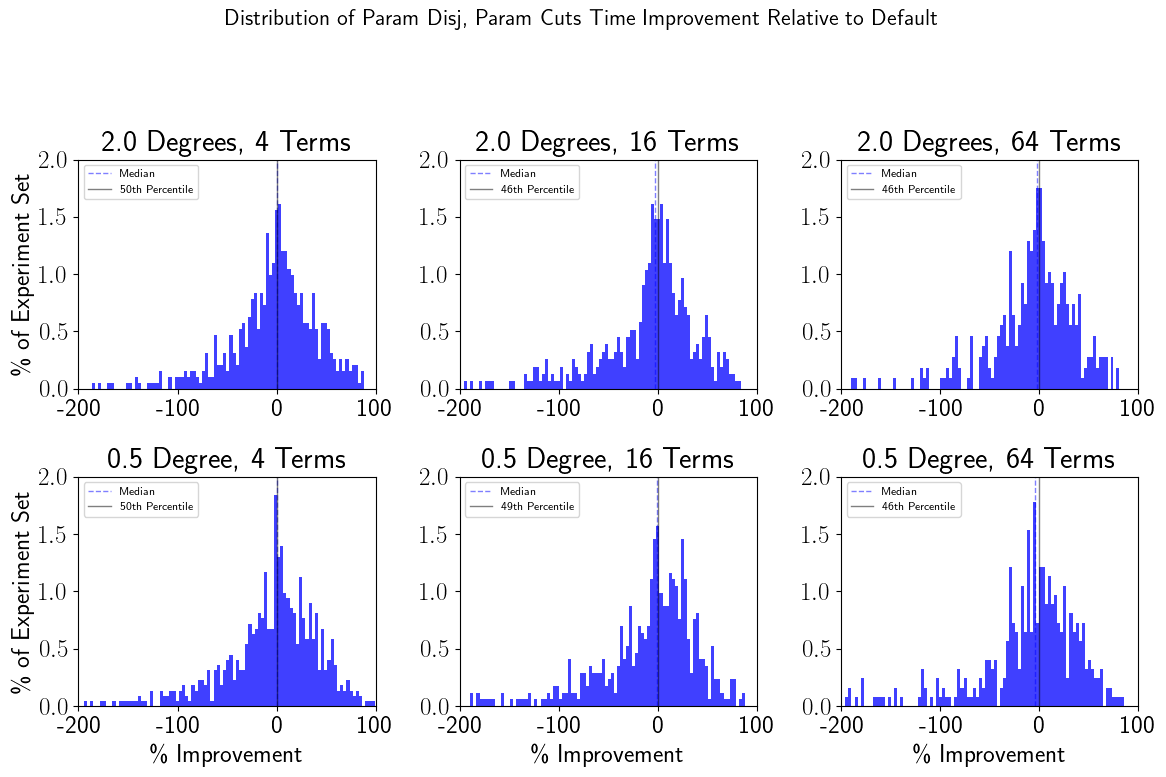

Histogram profiles saved to outputs/miplib_2017_5000/terminationTime_histograms.png


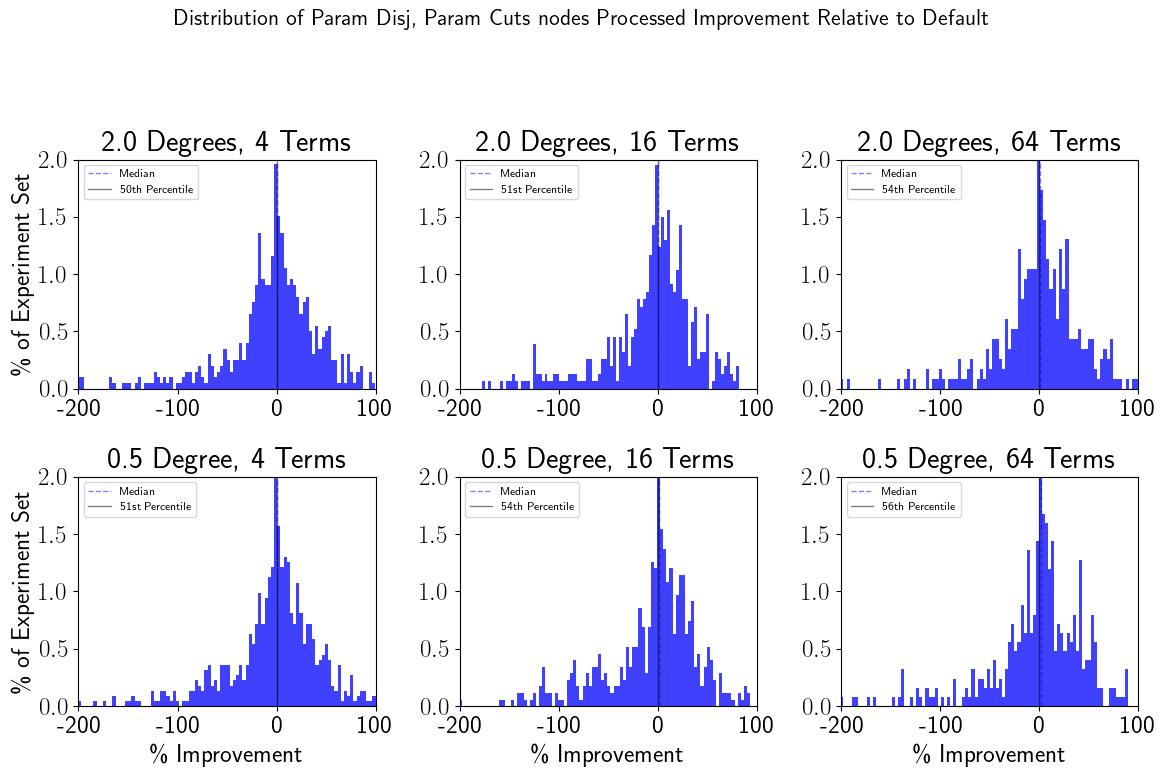

Histogram profiles saved to outputs/miplib_2017_5000/nodes_histograms.png


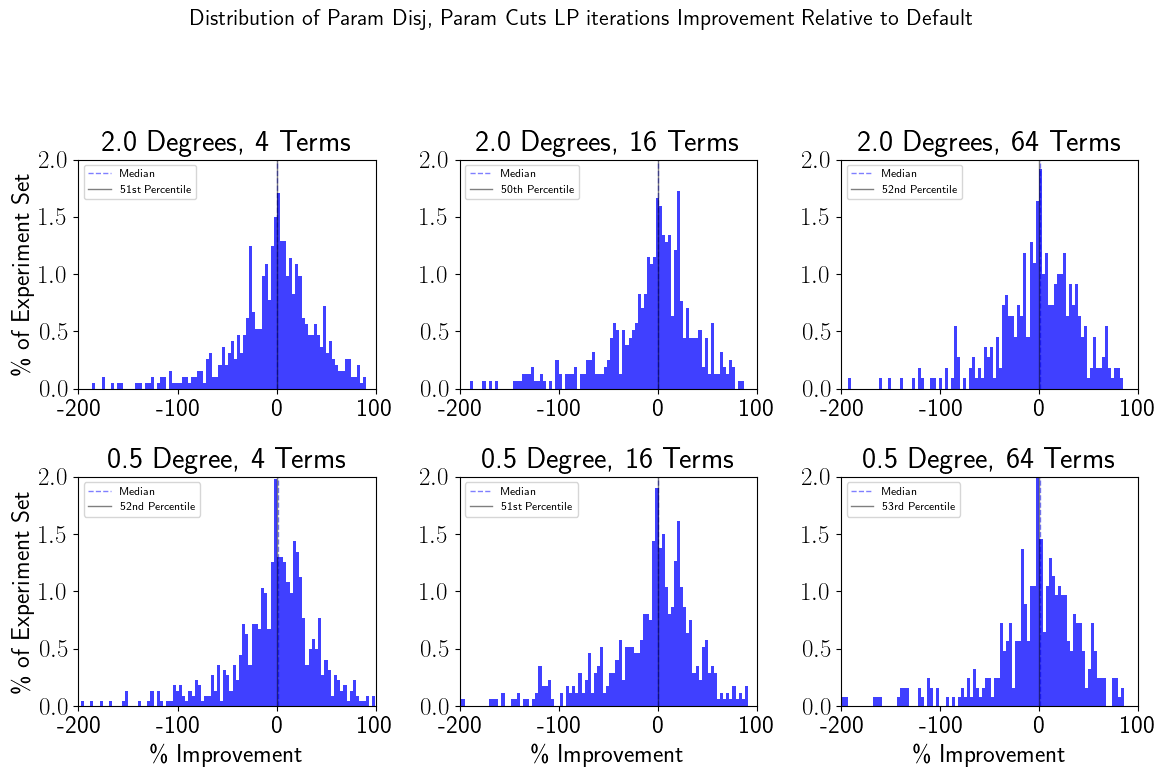

Histogram profiles saved to outputs/miplib_2017_5000/iterations_histograms.png


In [112]:
make_histograms(gap_df, "terminationTime")
make_histograms(gap_df, "nodes")
make_histograms(gap_df, "iterations")

In [113]:
# show the geometric means of Farkas and None
feature = "iterations"
grouping = "bracket"
group_cols = ["instance", grouping, "degree", "terms"]

# subselect our table
compare_df = gap_df.loc[(gap_df["perturbation"] != "bound"), group_cols + id_cols + [f"{feature} None", f"{feature} Farkas"]]

def geometric_mean(series):
    return np.exp(np.log(series).mean())

# find the average improvement for the feature cumulatively
cumulative_compare_df = compare_df.groupby(["degree", "terms"])[[f"{feature} None", f"{feature} Farkas"]].agg(geometric_mean)

# break it down by grouping type
grouping_compare_df = compare_df.groupby(["degree", "terms", grouping])[[f"{feature} None", f"{feature} Farkas"]].agg(geometric_mean).reset_index().pivot(
    index=['degree', 'terms'], columns=grouping, values=[f"{feature} None", f"{feature} Farkas"]
)
grouping_compare_df.columns = [' '.join(col).strip() for col in grouping_compare_df.columns.values]

# bring both tables together
out = pd.concat([cumulative_compare_df, grouping_compare_df], axis=1)

# save wins, base instance counts, and test instance counts to csv
out.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_{feature}_gmeans.csv"), index=False, mode="w")

out

iterations None  iterations Farkas  iterations None long  \
degree terms                                                             
0.5    4        481360.651162      467309.753154          7.147477e+06   
       16       559464.020761      572833.460255          6.895120e+06   
       64       747536.409807      724836.493554          8.722199e+06   
2.0    4        450721.462449      448923.285230          8.566767e+06   
       16       571547.033780      583384.472658          8.970577e+06   
       64       689398.248547      664558.311384          9.430548e+06   

              iterations None medium  iterations None short  \
degree terms                                                  
0.5    4                6.894482e+05           91528.692272   
       16               7.663783e+05          104615.710112   
       64               1.033211e+06          123354.109881   
2.0    4                5.622054e+05           92854.951895   
       16               7.121080e+05          103094.505829   
       64               9.156321e+05          123510.663157   

              iterations Farkas long  iterations Farkas medium  \
degree terms                                                     
0.5    4                6.360005e+06             680039.823485   
       16               6.696504e+06             798989.203184   
       64               8.547263e+06             993724.850486   
2.0    4                8.267893e+06             548339.220512   
       16               8.732148e+06             700053.744797   
       64               8.415070e+06             897234.220699   

              iterations Farkas short  
degree terms                           
0.5    4                 91313.238671  
       16               108006.696691  
       64               119925.602554  
2.0    4                 96296.892543  
       16               113233.044757  
       64               121078.124359

In [114]:
# get the geometric mean of 1 - (farkas / none)
feature = "iterations"
grouping = "bracket"
group_cols = ["instance", grouping, "degree", "terms"]

# subselect our table
ratio_df = gap_df.loc[(gap_df["perturbation"] != "bound"), group_cols + id_cols + [f"{feature}Ratio"]]

def geometric_mean(series):
    return series.prod() ** (1 / len(series))

# find the average improvement for the feature cumulatively
cumulative_ratio_df = ratio_df.groupby(["degree", "terms"])[f"{feature}Ratio"].agg(geometric_mean)

# break it down by grouping type
grouping_ratio_df = ratio_df.groupby(["degree", "terms", grouping])[f"{feature}Ratio"].agg(geometric_mean).reset_index().pivot(
    index=['degree', 'terms'], columns=grouping, values=[f"{feature}Ratio"]
)
grouping_ratio_df.columns = [' '.join(col).strip() for col in grouping_ratio_df.columns.values]

# bring both tables together
out = pd.concat([cumulative_ratio_df, grouping_ratio_df], axis=1)
# out = out[sorted(out.columns)]

# rename the columns
new_cols = [] 
for col in out.columns.values:
    if f"{feature}Ratio" in col:
        col = col.replace(f"{feature}Ratio", f"{label[feature]} Improvement %")
    elif "instanceIndex" in col:
        col = col.replace("instanceIndex", "Test Instances")
    elif "instance" in col:
        col = col.replace("instance", "Base Instances")
    new_cols.append(col)
out.columns = new_cols

# get our subselections
wins = out[[c for c in out.columns if any(f in c for f in ["Improvement %"])]].applymap(lambda x: round((1 - x) * 100, 2))
counts = out[[c for c in out.columns if any(f in c for f in ['Base', 'Test'])]].applymap(lambda x: int(x))

# save wins, base instance counts, and test instance counts to csv
wins.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_{feature}_ratio.csv"), index=False, mode="w")
counts.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_counts.csv"), index=False, mode="w")

wins

LP iterations Improvement %  LP iterations Improvement % long  \
degree terms                                                                  
0.5    4                             2.92                             11.02   
       16                           -2.39                              2.88   
       64                            3.04                              2.01   
2.0    4                             0.40                              3.49   
       16                           -2.07                              2.66   
       64                            3.60                             10.77   

              LP iterations Improvement % medium  \
degree terms                                       
0.5    4                                    1.36   
       16                                  -4.26   
       64                                   3.82   
2.0    4                                    2.47   
       16                                   1.69   
       64                                   2.01   

              LP iterations Improvement % short  
degree terms                                     
0.5    4                                   0.24  
       16                                 -3.24  
       64                                  2.78  
2.0    4                                  -3.71  
       16                                 -9.83  
       64                                  1.97

In [144]:
# get the win percentages for each feature on average and broken down by grouping type
features = ["nodes", "terminationTime", "terminationTimeSansVpc", "iterations"]
groupings = ["bracket"]  #, "perturbation"]

for grouping in groupings:
    group_cols = ["instance", grouping, "degree", "terms"]
    for feature in features:
        
        # subselect our table
        feature_df = gap_df.loc[gap_df["perturbation"] != "bound", group_cols + id_cols + [f"{feature}Improves"]]
        improvement_df = gap_df.loc[(gap_df["perturbation"] != "bound") & gap_df[f"{feature}Improves"],
                                    group_cols + id_cols + [f"{feature}Improvement"]]
        
        def geometric_mean(series):
            return series.prod() ** (1 / len(series))
        
        # find the average wins for the feature cumulatively
        cumulative_improvement_df = improvement_df.groupby(["degree", "terms"])[f"{feature}Improvement"].agg(geometric_mean)
        
        # break it down by grouping type
        grouping_improvement_df = improvement_df.groupby(["degree", "terms", grouping])[f"{feature}Improvement"].agg(geometric_mean).reset_index().pivot(
            index=['degree', 'terms'], columns=grouping, values=[f"{feature}Improvement"]
        )
        grouping_improvement_df.columns = [' '.join(col).strip() for col in grouping_improvement_df.columns.values]
        
        # define aggregating operations
        aggregations = {f"{feature}Improves": "mean", "instance": "nunique", "instanceIndex": "count"}
        
        # find the average wins for the feature cumulatively
        cumulative_wins_df = feature_df.groupby(["degree", "terms"]).agg(aggregations)
        
        # break it down by grouping type
        grouping_wins_df = feature_df.groupby(["degree", "terms", grouping]).agg(aggregations).reset_index().pivot(
            index=['degree', 'terms'], columns=grouping, values=[f"{feature}Improves", 'instance', 'instanceIndex']
        )
        grouping_wins_df.columns = [' '.join(col).strip() for col in grouping_wins_df.columns.values]
        
        # bring both tables together
        out = pd.concat([cumulative_wins_df, grouping_wins_df, cumulative_improvement_df, grouping_improvement_df], axis=1)
        
        # rename the columns
        new_cols = [] 
        for col in out.columns.values:
            if f"{feature}Improves" in col:
                col = col.replace(f"{feature}Improves", f"{label[feature]} Win %")
            elif f"{feature}Improvement" in col:
                col = col.replace(f"{feature}Improvement", f"{label[feature]} Improvement %")
            elif "instanceIndex" in col:
                col = col.replace("instanceIndex", "Test Instances")
            elif "instance" in col:
                col = col.replace("instance", "Base Instances")
            new_cols.append(col)
        out.columns = new_cols
        
        def custom_key(col):
            # bump improvement columns second to win percentage columns
            offset = int("Improvement %" in col)
            # check groupings
            if 'matrix' in col or 'short' in col:
                return (2 + offset, col)
            elif 'objective' in col or 'medium' in col:
                return (4 + offset, col)
            elif 'rhs' in col or 'long' in col:
                return (6 + offset, col)    
            return (offset, col)
        
        # sort the columns
        out = out[sorted(out.columns, key=custom_key)]
        
        # get our subselections
        wins = out[[c for c in out.columns if any(f in c for f in ["Win %", "Improvement %"])]].applymap(lambda x: round(x * 100, 2))
        counts = out[[c for c in out.columns if any(f in c for f in ['Base', 'Test'])]].applymap(lambda x: int(x))
        
        # save wins, base instance counts, and test instance counts to csv
        wins.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_{feature}_{grouping}_wins.csv"), index=False, mode="w")
        counts.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_counts_{grouping}.csv"), index=False, mode="w")

In [145]:
iterations_wins = pd.read_csv(os.path.join(out_fldr, f"branch_and_bound_iterations_{grouping}_wins.csv"), index_col=[0, 1])
iterations_wins

LP iterations Win %  LP iterations Improvement %  \
degree terms                                                     
0.5    4                    51.22                        17.19   
       16                   49.19                        16.63   
       64                   50.37                        19.43   
2.0    4                    50.09                        16.72   
       16                   48.25                        15.46   
       64                   48.50                        17.56   

              LP iterations Win % short  LP iterations Improvement % short  \
degree terms                                                                 
0.5    4                          50.18                              16.31   
       16                         49.30                              16.54   
       64                         54.30                              19.45   
2.0    4                          47.09                              17.07   
       16                         43.83                              15.28   
       64                         48.28                              17.80   

              LP iterations Win % medium  LP iterations Improvement % medium  \
degree terms                                                                   
0.5    4                           50.55                               19.63   
       16                          49.36                               17.75   
       64                          47.27                               24.07   
2.0    4                           50.77                               17.47   
       16                          50.00                               16.47   
       64                          46.54                               19.53   

              LP iterations Win % long  LP iterations Improvement % long  
degree terms                                                              
0.5    4                         54.68                             14.90  
       16                        48.67                             14.66  
       64                        49.44                             13.28  
2.0    4                         54.95                             14.28  
       16                        52.38                             13.51  
       64                        54.24                             13.40

In [146]:
nodes_wins = pd.read_csv(os.path.join(out_fldr, f"branch_and_bound_nodes_{grouping}_wins.csv"), index_col=[0, 1])
nodes_wins

nodes Processed Win %  nodes Processed Improvement %  \
degree terms                                                         
0.5    4                      49.78                          16.23   
       16                     52.06                          13.63   
       64                     54.07                          14.89   
2.0    4                      49.19                          15.69   
       16                     49.34                          14.41   
       64                     50.30                          15.30   

              nodes Processed Win % short  \
degree terms                                
0.5    4                            47.72   
       16                           50.70   
       64                           58.94   
2.0    4                            47.57   
       16                           46.30   
       64                           50.86   

              nodes Processed Improvement % short  \
degree terms                                        
0.5    4                                    18.01   
       16                                   14.00   
       64                                   14.18   
2.0    4                                    15.88   
       16                                   13.61   
       64                                   16.05   

              nodes Processed Win % medium  \
degree terms                                 
0.5    4                             49.82   
       16                            50.64   
       64                            52.12   
2.0    4                             47.69   
       16                            50.48   
       64                            47.17   

              nodes Processed Improvement % medium  \
degree terms                                         
0.5    4                                     18.63   
       16                                    17.70   
       64                                    19.13   
2.0    4                                     17.96   
       16                                    16.36   
       64                                    15.89   

              nodes Processed Win % long  nodes Processed Improvement % long  
degree terms                                                                  
0.5    4                           53.96                               10.47  
       16                          57.52                                8.12  
       64                          49.44                               10.08  
2.0    4                           57.14                               11.12  
       16                          52.38                               11.69  
       64                          57.63                               12.95

In [147]:
time_wins = pd.read_csv(os.path.join(out_fldr, f"branch_and_bound_terminationTime_{grouping}_wins.csv"), index_col=[0, 1])
time_wins

Time Win %  Time Improvement %  Time Win % short  \
degree terms                                                     
0.5    4           49.78               18.10             48.42   
       16          48.84               16.29             47.42   
       64          45.68               17.18             43.71   
2.0    4           50.99               16.77             47.09   
       16          45.61               14.79             38.27   
       64          44.31               15.97             42.24   

              Time Improvement % short  Time Win % medium  \
degree terms                                                
0.5    4                         20.88              47.99   
       16                        13.05              50.21   
       64                        16.44              47.88   
2.0    4                         16.98              52.31   
       16                        17.43              48.57   
       64                        17.12              42.77   

              Time Improvement % medium  Time Win % long  \
degree terms                                               
0.5    4                          18.67            56.12   
       16                         21.48            48.67   
       64                         20.29            44.94   
2.0    4                          19.48            56.04   
       16                         14.86            52.38   
       64                         17.17            52.54   

              Time Improvement % long  
degree terms                           
0.5    4                        13.34  
       16                       13.59  
       64                       13.31  
2.0    4                        10.99  
       16                       11.61  
       64                       12.19

In [148]:
sans_vpc_wins = pd.read_csv(os.path.join(out_fldr, f"branch_and_bound_terminationTimeSansVpc_{grouping}_wins.csv"), index_col=[0, 1])
sans_vpc_wins

Time (Minus VPC Generation) Win %  \
degree terms                                      
0.5    4                                  50.50   
       16                                 51.34   
       64                                 49.63   
2.0    4                                  51.17   
       16                                 49.34   
       64                                 49.10   

              Time (Minus VPC Generation) Improvement %  \
degree terms                                              
0.5    4                                          17.42   
       16                                         17.38   
       64                                         17.58   
2.0    4                                          16.51   
       16                                         14.41   
       64                                         16.47   

              Time (Minus VPC Generation) Win % short  \
degree terms                                            
0.5    4                                        49.82   
       16                                       53.05   
       64                                       53.64   
2.0    4                                        47.09   
       16                                       45.68   
       64                                       51.72   

              Time (Minus VPC Generation) Improvement % short  \
degree terms                                                    
0.5    4                                                19.18   
       16                                               14.82   
       64                                               15.99   
2.0    4                                                18.37   
       16                                               15.13   
       64                                               17.54   

              Time (Minus VPC Generation) Win % medium  \
degree terms                                             
0.5    4                                         48.35   
       16                                        51.07   
       64                                        48.48   
2.0    4                                         52.31   
       16                                        50.95   
       64                                        45.91   

              Time (Minus VPC Generation) Improvement % medium  \
degree terms                                                     
0.5    4                                                 18.37   
       16                                                22.56   
       64                                                21.79   
2.0    4                                                 19.89   
       16                                                15.12   
       64                                                17.66   

              Time (Minus VPC Generation) Win % long  \
degree terms                                           
0.5    4                                       56.12   
       16                                      48.67   
       64                                      44.94   
2.0    4                                       57.14   
       16                                      52.38   
       64                                      52.54   

              Time (Minus VPC Generation) Improvement % long  
degree terms                                                  
0.5    4                                               13.36  
       16                                              13.70  
       64                                              13.85  
2.0    4                                                8.31  
       16                                              11.80  
       64                                              12.38

In [143]:
def cols_to_keep(df):
    return [c for c in df.columns if any(c.endswith(f) for f in ["Win %", "Improvement %"])
            or "degree" == c or "terms" == c]

# join nodes_wins, time_wins, and sans_vpc_wins on degree and terms keeping only the columns returned from cols_to_keep
out = nodes_wins[cols_to_keep(nodes_wins)].merge(time_wins[cols_to_keep(time_wins)], left_index=True, right_index=True).merge(
    sans_vpc_wins[cols_to_keep(sans_vpc_wins)], left_index=True, right_index=True
)

out.to_csv(os.path.join(out_fldr, f"branch_and_bound_wins.csv"), index=False, mode="w")
out

nodes Processed Win %  nodes Processed Improvement %  \
degree terms                                                         
0.5    4                      49.78                          16.23   
       16                     52.06                          13.63   
       64                     54.07                          14.89   
2.0    4                      49.19                          15.69   
       16                     49.34                          14.41   
       64                     50.30                          15.30   

              Time Win %  Time Improvement %  \
degree terms                                   
0.5    4           49.78               18.10   
       16          48.84               16.29   
       64          45.68               17.18   
2.0    4           50.99               16.77   
       16          45.61               14.79   
       64          44.31               15.97   

              Time (Minus VPC Generation) Win %  \
degree terms                                      
0.5    4                                  50.50   
       16                                 51.34   
       64                                 49.63   
2.0    4                                  51.17   
       16                                 49.34   
       64                                 49.10   

              Time (Minus VPC Generation) Improvement %  
degree terms                                             
0.5    4                                          17.42  
       16                                         17.38  
       64                                         17.58  
2.0    4                                          16.51  
       16                                         14.41  
       64                                         16.47

In [133]:
count_brackets = pd.read_csv(os.path.join(out_fldr, f"branch_and_bound_counts_bracket.csv"), index_col=[0, 1])
count_brackets

Base Instances  Test Instances  Base Instances short  \
degree terms                                                         
0.5    4                 100             697                    63   
       16                 96             559                    61   
       64                 74             405                    48   
2.0    4                 100             557                    64   
       16                 90             456                    57   
       64                 74             334                    45   

              Test Instances short  Base Instances medium  \
degree terms                                                
0.5    4                       285                     64   
       16                      213                     55   
       64                      151                     41   
2.0    4                       206                     60   
       16                      162                     52   
       64                      116                     41   

              Test Instances medium  Base Instances long  Test Instances long  
degree terms                                                                   
0.5    4                        273                   35                  139  
       16                       233                   29                  113  
       64                       165                   25                   89  
2.0    4                        260                   28                   91  
       16                       210                   24                   84  
       64                       159                   19                   59

In [149]:
count_brackets[count_brackets.columns[:2]]

Base Instances  Test Instances
degree terms                                
0.5    4                 100             697
       16                 96             559
       64                 74             405
2.0    4                 100             557
       16                 90             456
       64                 74             334

In [134]:
count_perturbations = pd.read_csv(os.path.join(out_fldr, f"branch_and_bound_counts_perturbation.csv"), index_col=[0, 1])
count_perturbations

Base Instances  Test Instances  Base Instances matrix  \
degree terms                                                          
0.5    4                 100             697                     62   
       16                 96             559                     53   
       64                 74             405                     44   
2.0    4                 100             557                     44   
       16                 90             456                     37   
       64                 74             334                     29   

              Test Instances matrix  Base Instances objective  \
degree terms                                                    
0.5    4                        193                        86   
       16                       143                        78   
       64                       110                        64   
2.0    4                        119                        88   
       16                        93                        79   
       64                        63                        63   

              Test Instances objective  Base Instances rhs  Test Instances rhs  
degree terms                                                                    
0.5    4                           408                  38                  96  
       16                          327                  38                  89  
       64                          217                  32                  78  
2.0    4                           364                  32                  74  
       16                          304                  26                  59  
       64                          224                  24                  47

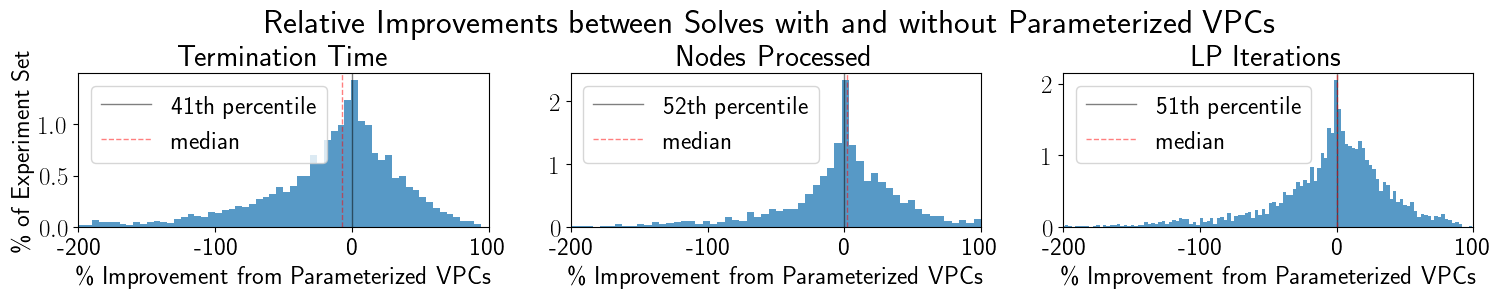

In [349]:
# Create a 3 x 1 figure with a size of 18 inches wide by 4 inches tall
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(18, 2))

# Create the first subplot (1 row, 3 columns, 1st plot)
ax1 = fig.add_subplot(1, 3, 1)
# Create a histogram with 600 bins
ax1.hist((gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"],
         bins=3000, density=True, alpha=0.75)
ax1.set_xlim(-2, 1)

cut_off = ((gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
ax1.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")
ax1.axvline(cut_off, color='red', linestyle='--', linewidth=1, alpha=.5, label=f"median")

# Add labels and a title
ax1.set_xlabel('\% Improvement from Parameterized VPCs')
ax1.xaxis.set_major_formatter(formatter)  # Apply the custom formatter
ax1.set_ylabel('\% of Experiment Set')
ax1.set_title('Termination Time')
ax1.legend(loc="upper left")

# Create the second subplot (1 row, 3 columns, 3rd plot)
ax2 = fig.add_subplot(1, 3, 2)
# Create a histogram with 600 bins
ax2.hist((gap_df["nodes None"] - gap_df["nodes Farkas"])/gap_df["nodes None"],
         bins=10000, density=True, alpha=0.75)
ax2.set_xlim(-2, 1)

cut_off = ((gap_df["nodes None"] - gap_df["nodes Farkas"])/gap_df["nodes None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["nodes None"] >= gap_df["nodes Farkas"]).sum() / len(gap_df), 2))
ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")
ax2.axvline(cut_off+.02, color='red', linestyle='--', linewidth=1, alpha=.5, label=f"median")

# Add labels and a title
ax2.set_xlabel('\% Improvement from Parameterized VPCs')
ax2.xaxis.set_major_formatter(formatter)  # Apply the custom formatter
ax2.set_title('nodes Processed')
ax2.legend(loc="upper left")

# Create the second subplot (1 row, 3 columns, 3rd plot)
ax3 = fig.add_subplot(1, 3, 3)
# Create a histogram with 600 bins
ax3.hist((gap_df["iterations None"] - gap_df["iterations Farkas"])/gap_df["iterations None"],
         bins=10000, density=True, alpha=0.75)
ax3.set_xlim(-2, 1)

cut_off = ((gap_df["iterations None"] - gap_df["iterations Farkas"])/gap_df["iterations None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["iterations None"] >= gap_df["iterations Farkas"]).sum() / len(gap_df), 2))
ax3.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")
ax3.axvline(cut_off, color='red', linestyle='--', linewidth=1, alpha=.5, label=f"median")

# Add labels and a title
ax3.set_xlabel('\% Improvement from Parameterized VPCs')
ax3.xaxis.set_major_formatter(formatter)  # Apply the custom formatter
ax3.set_title('LP iterations')
ax3.legend(loc="upper left")

# Set the shared title for the entire figure
fig.suptitle('Relative Improvements between Solves with and without Parameterized VPCs',
             x=.51, y=1.2, fontsize=24)

# Show the plot
fig.savefig(os.path.join(out_fldr, "combined_improvement_distribution.png"), dpi=1200, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


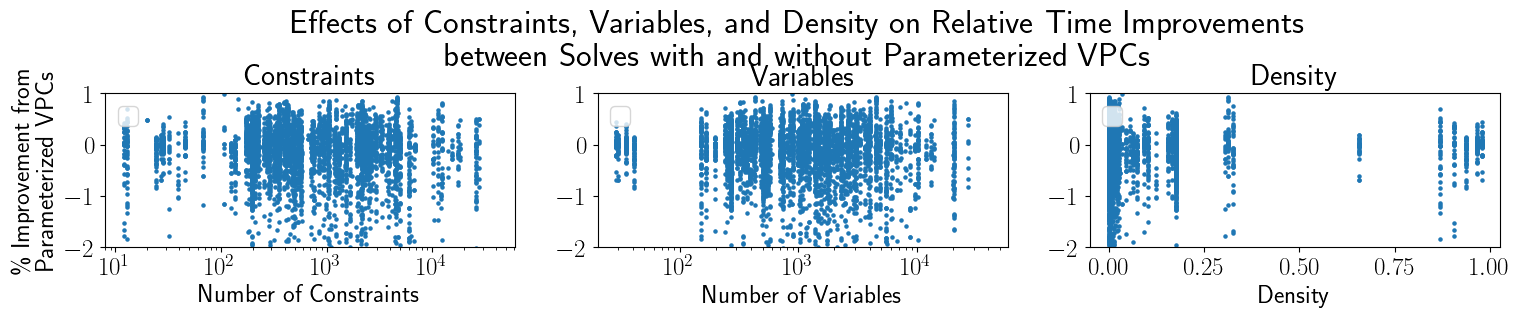

In [350]:
# Create a 3 x 1 figure with a size of 18 inches wide by 4 inches tall
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(18, 2))

# Create a scatter plot for rows vs relative time improvement
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(gap_df["rows None"], (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"], s=5)
ax1.set_xscale('log')
ax1.set_ylim(-2, 1)

# Add labels and a title
ax1.set_xlabel('Number of Constraints')
ax1.set_ylabel('\% Improvement from\nParameterized VPCs')
ax1.set_title('Constraints')
ax1.legend(loc="upper left")

# Create a scatter plot for cols vs relative time improvement
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(gap_df["cols None"], (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"], s=5)
ax2.set_xscale('log')
ax2.set_ylim(-2, 1)

# Add labels and a title
ax2.set_xlabel('Number of Variables')
ax2.set_title('Variables')
ax2.legend(loc="upper left")

# Create a scatter plot for density vs relative time improvement
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(gap_df["density None"], (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"], s=5)
ax3.set_ylim(-2, 1)

# Add labels and a title
ax3.set_xlabel('Density')
ax3.set_title('Density')
ax3.legend(loc="upper left")

# Set the shared title for the entire figure
fig.suptitle('Effects of Constraints, Variables, and Density on Relative Time Improvements\nbetween Solves with and without Parameterized VPCs',
             x=.51, y=1.3, fontsize=24)

# Show the plot
fig.savefig(os.path.join(out_fldr, "combined_improvement_distribution_by_size.png"), dpi=1200, bbox_inches='tight')
plt.show()

In [351]:
# read in meta data
features = pd.read_csv("miplib_2017_metadata.csv")

# format nicely
features.columns = [c.split()[0].lower() for c in features.columns]
tags = {t for tag_list in features["tags"] for t in tag_list.split(" ")}

# create density column
features["density"] = features["nonz."] / (features["variables"] * features["constraints"])

# encode tags as binary
for tag in tags:
    features[tag] = features["tags"].str.contains(tag)
    
# encode difficulty as binary
for difficulty in features["status"].unique():
    features[difficulty] = (features["status"] == difficulty)

# drop rows that lack finite objective
features['objective'] = pd.to_numeric(features['objective'], errors='coerce')
features = features.dropna(subset=['objective'])

# drop unnecessary columns    
features = features.drop(columns=["status", "submitter", "group", "tags", "objective"])

# set features index to instance
features = features.set_index("instance")

features.head()

variables  binaries  integers  continuous  constraints  \
instance                                                                   
10teams              2025.0    1800.0       0.0         225          230   
22433                 429.0     231.0       0.0         198          198   
23588                 368.0     231.0       0.0         137          137   
2club200v15p5scn      200.0     200.0       0.0           0        17013   
30_70_45_05_100     10772.0   10771.0       0.0           1        12050   

                   nonz.   density  invariant_knapsack  decomposition  \
instance                                                                
10teams            12150  0.026087                True          False   
22433               3408  0.040121               False          False   
23588               3701  0.073409               False          False   
2club200v15p5scn  104811  0.030803                True          False   
30_70_45_05_100    45889  0.000354               False           True   

                  set_packing  ...  general_linear  feasibility  no_solution  \
instance                       ...                                             
10teams                  True  ...           False        False        False   
22433                   False  ...            True        False        False   
23588                   False  ...            True        False        False   
2club200v15p5scn        False  ...           False        False        False   
30_70_45_05_100         False  ...           False        False        False   

                  precedence  cardinality  knapsack  benchmark_suitable  \
instance                                                                  
10teams                False        False      True               False   
22433                  False        False     False               False   
23588                  False        False     False               False   
2club200v15p5scn       False        False      True               False   
30_70_45_05_100         True        False     False                True   

                   easy   hard   open  
instance                               
10teams            True  False  False  
22433              True  False  False  
23588              True  False  False  
2club200v15p5scn  False   True  False  
30_70_45_05_100    True  False  False  

[5 rows x 33 columns]

In [352]:
print([c for c in gap_df.columns if "Farkas" in c or not any(m in c for m in ["New", "None", "Old"])])

['instanceIndex', 'terms', 'instance', 'perturbation', 'degree', 'vpcGenerator Farkas', 'lpBound Farkas', 'disjunctiveDualBound Farkas', 'lpBoundPostVpc Farkas', 'rootDualBound Farkas', 'dualBound Farkas', 'primalBound Farkas', 'vpcGenerationTime Farkas', 'rootDualBoundTime Farkas', 'bestSolutionTime Farkas', 'terminationTime Farkas', 'nodes Farkas', 'iterations Farkas', 'maxTime Farkas', 'actualTerms Farkas', 'numCuts Farkas', 'cutLimit Farkas', 'mipSolver Farkas', 'providePrimalBound Farkas', 'infeasibleTerms Farkas', 'feasibleToInfeasibleTerms Farkas', 'infeasibleToFeasibleTerms Farkas', 'rows Farkas', 'cols Farkas', 'density Farkas', 'VPCs (Farkas)', 'Root Cuts (Farkas)', 'Root Optimality Gap Improvement', 'terminationTimeSansVpc Farkas', 'rootDualBoundTimeSansVpc Farkas', 'postRootTime Farkas', 'terminationTimeImprovement', 'nodeImprovement', 'iterationImprovement', 'terminationTimeRatio', 'nodeRatio', 'iterationRatio', 'infeasibleTermsRatio Farkas', 'infeasibleToFeasibleTermsRati

In [353]:
# create normalized columns for time improvement
gap_df["relative runtime improvement ratio"] = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"]
gap_df["relative runtime improvement"] = gap_df["relative runtime improvement ratio"] > 0

# create binary columns for perturbation
for p in gap_df["perturbation"].unique():
    gap_df[p] = (gap_df["perturbation"] == p)
    
# select our columns from gap_df
feature_cols = ["instance", "terms", "actualTerms Farkas", 'bound', 'objective', 'matrix', 'rhs', "degree", "numCuts Farkas", 'infeasibleTermsRatio Farkas',
                'infeasibleToFeasibleTermsRatio Farkas', 'zeroInfeasibleToFeasibleTerms Farkas', 'feasibleToInfeasibleTermsRatio Farkas',
                "Root Optimality Gap Improvement"]
label_cols = ["relative runtime improvement ratio", "relative runtime improvement"]
labels = gap_df[feature_cols + label_cols]

# drop rows where infeasibleToFeasibleTermsRatio Farkas or feasibleToInfeasibleTermsRatio Farkas is nonzero
# labels = labels.loc[(labels["infeasibleToFeasibleTermsRatio Farkas"] == 0) & (labels["feasibleToInfeasibleTermsRatio Farkas"] == 0)]

# format labels table
labels.set_index("instance", inplace=True)
labels.head()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_37953/411152561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_df["relative runtime improvement ratio"] = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_37953/411152561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_df["relative runtime improvement"] = gap_df["relative runtime improvement ratio"] > 0
/var/folders/pb/p1sshd

terms  actualTerms Farkas  bound  objective  matrix    rhs  degree  \
instance                                                                       
app1-1        4                  14  False       True   False  False     2.0   
app1-1        4                  14  False       True   False  False     2.0   
app1-1        4                  14  False       True   False  False     2.0   
app1-1        4                  14  False       True   False  False     2.0   
app1-1        4                  14  False       True   False  False     2.0   

          numCuts Farkas  infeasibleTermsRatio Farkas  \
instance                                                
app1-1                 4                     0.928571   
app1-1                 4                     0.928571   
app1-1                 4                     0.928571   
app1-1                 4                     0.928571   
app1-1                 4                     0.928571   

          infeasibleToFeasibleTermsRatio Farkas  \
instance                                          
app1-1                                      0.0   
app1-1                                      0.0   
app1-1                                      0.0   
app1-1                                      0.0   
app1-1                                      0.0   

          zeroInfeasibleToFeasibleTerms Farkas  \
instance                                         
app1-1                                    True   
app1-1                                    True   
app1-1                                    True   
app1-1                                    True   
app1-1                                    True   

          feasibleToInfeasibleTermsRatio Farkas  \
instance                                          
app1-1                                      0.0   
app1-1                                      0.0   
app1-1                                      0.0   
app1-1                                      0.0   
app1-1                                      0.0   

          Root Optimality Gap Improvement  relative runtime improvement ratio  \
instance                                                                        
app1-1                           0.053227                           -1.959637   
app1-1                           0.000000                           -1.457700   
app1-1                           0.053178                           -1.134316   
app1-1                           0.001072                           -0.756157   
app1-1                          -0.000461                           -0.635849   

          relative runtime improvement  
instance                                
app1-1                           False  
app1-1                           False  
app1-1                           False  
app1-1                           False  
app1-1                           False

In [354]:
# join features and labels
train = features.join(labels, how="inner")

In [355]:
# Identify numeric and non-numeric features
# numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
# non_numeric_features = X.select_dtypes(exclude=['float64', 'int64']).columns

# # Standardize numeric features (fit on training data, transform both train and test sets)
# scaler = StandardScaler()
# X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_features])
# X_test_numeric_scaled = scaler.transform(X_test[numeric_features])
# 
# # Combine scaled numeric features with non-numeric features for both sets
# X_train_scaled = pd.DataFrame(X_train_numeric_scaled, columns=numeric_features, index=X_train.index)
# X_train_scaled[non_numeric_features] = X_train[non_numeric_features]
# 
# X_test_scaled = pd.DataFrame(X_test_numeric_scaled, columns=numeric_features, index=X_test.index)
# X_test_scaled[non_numeric_features] = X_test[non_numeric_features]

# Apply PCA on scaled numeric features only
# pca = PCA()
# X_train_pca = pca.fit_transform(X_train_numeric_scaled)
# X_test_pca = pca.transform(X_test_numeric_scaled)
# 
# # Create DataFrame for PCA components
# pca_train_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])], index=X_train.index)
# pca_test_df = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])], index=X_test.index)
# 
# # Add non-numeric features back to PCA dataframes (optional, depending on your modeling)
# pca_train_df[non_numeric_features] = X_train[non_numeric_features]
# pca_test_df[non_numeric_features] = X_test[non_numeric_features]
# 
# # Check explained variance ratio
# explained_variance = pca.explained_variance_ratio_
# print("Explained Variance Ratio for each component:", explained_variance)
# 
# # Plot cumulative explained variance
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs Number of Components')
# plt.show()
# 
# # Select number of components to retain 95% variance
# n_components = (explained_variance.cumsum() <= 0.95).sum() + 1
# print(f"Number of components to retain 95% variance: {n_components}")
# 
# # Apply PCA again, reducing dimensionality
# pca_reducer = PCA(n_components=n_components)
# X_train_reduced = pca_reducer.fit_transform(X_train_numeric_scaled)
# X_test_reduced = pca_reducer.transform(X_test_numeric_scaled)
# 
# # Create reduced DataFrame for interpretability (optional)
# reduced_train_df = pd.DataFrame(X_train_reduced, columns=[f"PC{i+1}" for i in range(n_components)], index=X_train.index)
# reduced_test_df = pd.DataFrame(X_test_reduced, columns=[f"PC{i+1}" for i in range(n_components)], index=X_test.index)
# 
# # Add non-numeric features back if required
# reduced_train_df[non_numeric_features] = X_train[non_numeric_features]
# reduced_test_df[non_numeric_features] = X_test[non_numeric_features]
# 
# print(reduced_train_df.head())

In [356]:
# Separate features (X) and target variable (y)
X = train.drop(columns=label_cols)  # Drop the label columns to use the rest as features
y = train['relative runtime improvement ratio']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_train)

# Evaluate the model
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Print model coefficients and intercept
print("Coefficients:")
d = dict(zip(X.columns, model.coef_))
d = sorted(d.items(), key=lambda x: abs(x[1]), reverse=True)  # make a list of key value pairs of d in descending order of coefficient
for col, coef in d:
    print(f"{col}: {coef}")

print("Intercept:", model.intercept_)

Mean Absolute Error (MAE): 0.7846849422135519
Mean Squared Error (MSE): 10.027544746207768
R² Score: 0.04608881677261689
Coefficients:
integers: -524931045.04568636
binaries: -524931045.0456412
continuous: -524931045.04557365
variables: 524931045.04553384
Root Optimality Gap Improvement: 2.664010824685088
numerics: -1.6526362183628105
indicator: 1.5993197300397475
equation_knapsack: 1.2589889179756537
integer_knapsack: 1.1892537504220453
bound: -1.0432935721929653
mixed_binary: -0.962784292599957
set_packing: -0.7861405645095559
binary: 0.6260010580034168
cardinality: 0.5462322770502654
general_linear: -0.47051161741589165
binpacking: 0.4615246515141433
objective: 0.4270436779400054
infeasibleToFeasibleTermsRatio Farkas: 0.42516358708969426
infeasibleTermsRatio Farkas: 0.4190413248249398
decomposition: -0.41630205192464526
precedence: -0.36732931266595265
matrix: 0.3421653373743087
knapsack: -0.31644623260927957
aggregations: 0.3100912830194227
rhs: 0.274084556799841
set_covering: -0.2

In [357]:
# Separate features (X) and target (y)
X = train.drop(columns=label_cols)  # Replace 'ratioPositive' with your binary target column
y = train['relative runtime improvement']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression(penalty='l2', solver='liblinear')  # L2 regularization

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print model coefficients for each feature
print("\nFeature Effects (Coefficients):")
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(coefficients)

Accuracy: 0.59

Confusion Matrix:
[[574   0]
 [406   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.59      1.00      0.74       574
        True       0.00      0.00      0.00       406

    accuracy                           0.59       980
   macro avg       0.29      0.50      0.37       980
weighted avg       0.34      0.59      0.43       980


Feature Effects (Coefficients):
                                  Feature  Coefficient
33                                  terms     0.004881
14                              benchmark     0.004710
29                     benchmark_suitable     0.004710
37                                 matrix     0.002643
11                                 binary     0.002420
13                       set_partitioning     0.001610
21                           mixed_binary     0.001555
38                                    rhs     0.001147
15                         variable_bound     0.001052
35       

/Users/sean/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sean/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sean/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## See Where My Work Went off the Rails

In [358]:
# create a table to compare unperturbed instances with aleks' results for them
groups = ["instance", "terms"]
fields = ["lpBound New", "disjunctiveDualBound New", "lpBoundPostVpc New", "rootDualBound None",
          "rootDualBound New", "primalBound None", "terminationTime None", "Root Cuts (New)", "Root Cuts (None)"]
comp = df.loc[df["instanceIndex"] == 0, groups + fields].groupby(groups).mean().reset_index()
comp.to_csv(os.path.join(out_fldr, "unperturbed_bound_table.csv"), index=False, mode="w")
comp

instance  terms   lpBound New  disjunctiveDualBound New  \
0        10teams      4  9.170000e+02              9.170000e+02   
1        10teams     16  9.170000e+02              9.170000e+02   
2        10teams     64  9.170000e+02              9.170000e+02   
3          22433      4  2.124053e+04              2.131498e+04   
4          23588      4  7.649866e+03              7.799913e+03   
..           ...    ...           ...                       ...   
500  uct-subprob      4  2.420000e+02              2.426667e+02   
501  uct-subprob     16  2.420000e+02              2.435588e+02   
502  uct-subprob     64  2.420000e+02              2.440000e+02   
503         umts      4  2.912957e+07              2.912989e+07   
504         umts     16  2.912957e+07              2.913027e+07   

     lpBoundPostVpc New  rootDualBound None  rootDualBound New  \
0          9.170000e+02        9.240000e+02       9.240000e+02   
1          9.170000e+02        9.240000e+02       9.240000e+02   
2          9.170000e+02        9.240000e+02       9.240000e+02   
3          2.131438e+04        2.139647e+04       2.141932e+04   
4          7.770875e+03        7.770368e+03       7.790990e+03   
..                  ...                 ...                ...   
500        2.426667e+02        2.777899e+02       2.777211e+02   
501        2.433241e+02        2.777899e+02       2.764205e+02   
502        2.434637e+02        2.777899e+02       2.761881e+02   
503        2.912987e+07        2.917164e+07       2.917680e+07   
504        2.913006e+07        2.917164e+07       2.917582e+07   

     primalBound None  terminationTime None  Root Cuts (New)  Root Cuts (None)  
0               924.0              1.095222         1.000000          1.000000  
1               924.0              0.849162         1.000000          1.000000  
2               924.0              0.955300         1.000000          1.000000  
3             21477.0              0.368808         0.756100          0.659438  
4              8090.0              1.673117         0.320639          0.273784  
..                ...                   ...              ...               ...  
500             314.0           3600.004986         0.496126          0.497083  
501             314.0           3600.004570         0.478063          0.497083  
502             314.0           3600.004331         0.474834          0.497083  
503        30090893.0            665.794987         0.049140          0.043769  
504        30090893.0            678.992386         0.048113          0.043769  

[505 rows x 11 columns]

In [359]:
# create a table with aleks's results for the unperturbed instances 
adf = pd.read_csv("aleks_results.csv")
adf = adf[["INSTANCE", "disj_terms", "LP OBJ", "BEST DISJ OBJ", "VPC OBJ", "AVG REF LAST_CUT_PASS", "AVG REF+V LAST_CUT_PASS", "ip_obj", "BEST REF TIME"]]
adf["rcnew"] = abs(adf["AVG REF+V LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"]) 
adf["rcnone"] = abs(adf["AVG REF LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"])
adf.columns = groups + fields
adf['instance'] = adf['instance'].str.replace('_presolved', '')
adf['instance'] = adf['instance'].str.replace('mas0', 'mas')
adf = adf.loc[(0 <= adf["Root Cuts (New)"]) & (adf["Root Cuts (New)"] <= 1)]

In [360]:
# join comp and adf on instance and terms to get a comparison of the two and see what's missing
keep_cols = groups + ["Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
both = comp[keep_cols].merge(adf[keep_cols], on=groups, suffixes=(" sean", " aleks"), how="outer")
both

instance  terms  Root Cuts (New) sean  Root Cuts (None) sean  \
0             10teams    4.0              1.000000               1.000000   
1             10teams   16.0              1.000000               1.000000   
2             10teams   64.0              1.000000               1.000000   
3               22433    4.0              0.756100               0.659438   
4               23588    4.0              0.320639               0.273784   
...               ...    ...                   ...                    ...   
2115             umts   64.0                   NaN                    NaN   
2116  usAbbrv-8-25_70   64.0                   NaN                    NaN   
2117             vpm1   64.0                   NaN                    NaN   
2118             vpm2   64.0                   NaN                    NaN   
2119        zib54-UUE   64.0                   NaN                    NaN   

      terminationTime None sean  Root Cuts (New) aleks  \
0                      1.095222               1.000000   
1                      0.849162               1.000000   
2                      0.955300                    NaN   
3                      0.368808               0.675821   
4                      1.673117               0.318880   
...                         ...                    ...   
2115                        NaN               0.049433   
2116                        NaN               0.000000   
2117                        NaN               0.721295   
2118                        NaN               0.719205   
2119                        NaN               0.681297   

      Root Cuts (None) aleks  terminationTime None aleks  
0                   1.000000                       0.301  
1                   1.000000                       0.302  
2                        NaN                         NaN  
3                   0.667379                       0.093  
4                   0.243813                       0.420  
...                      ...                         ...  
2115                0.047454                      49.839  
2116                0.000000                    3600.000  
2117                0.681575                       0.004  
2118                0.718862                       0.098  
2119                0.687208                     103.298  

[2120 rows x 8 columns]

In [361]:
# make a dataframe that compares the experiments we both ran
diff = both.loc[~pd.isna(both["Root Cuts (New) sean"]) & ~pd.isna(both["Root Cuts (New) aleks"])]
diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]

# get some summary stats - looks like we are pretty close
# I expect the difference is that I'm not adding GMICs and I'm using different sized disjunctions 
diff[diff.columns[2:]].mean()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_37953/3402183073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]


Root Cuts (New) sean            0.560396
Root Cuts (None) sean           0.553168
terminationTime None sean     625.631718
Root Cuts (New) aleks           0.541650
Root Cuts (None) aleks          0.521054
terminationTime None aleks    310.003514
improvement aleks                    inf
dtype: float64

In [362]:
# let's examine the instances for which I don't have data
mdf = both.loc[(both["Root Cuts (None) sean"].isna()) & (both["terms"].isin([4, 16, 64])),
               ["instance", "terms", "Root Cuts (New) aleks", "Root Cuts (None) aleks", "terminationTime None aleks"]]
mdf.columns = ["instance", "terms", "Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
mdf["improvement"] = (mdf["Root Cuts (New)"] - mdf["Root Cuts (None)"]) / mdf["Root Cuts (None)"]
mdf

instance  terms  Root Cuts (New)  Root Cuts (None)  \
88                decomp1   64.0              NaN               NaN   
330           neos-555424   16.0              NaN               NaN   
331           neos-555424   64.0              NaN               NaN   
463   shipschedule3shipsi    4.0              NaN               NaN   
464   shipschedule3shipsi   16.0              NaN               NaN   
...                   ...    ...              ...               ...   
2115                 umts   64.0         0.049433          0.047454   
2116      usAbbrv-8-25_70   64.0         0.000000          0.000000   
2117                 vpm1   64.0         0.721295          0.681575   
2118                 vpm2   64.0         0.719205          0.718862   
2119            zib54-UUE   64.0         0.681297          0.687208   

      terminationTime None  improvement  
88                     NaN          NaN  
330                    NaN          NaN  
331                    NaN          NaN  
463                    NaN          NaN  
464                    NaN          NaN  
...                    ...          ...  
2115                49.839     0.041720  
2116              3600.000          NaN  
2117                 0.004     0.058276  
2118                 0.098     0.000477  
2119               103.298    -0.008602  

[591 rows x 6 columns]

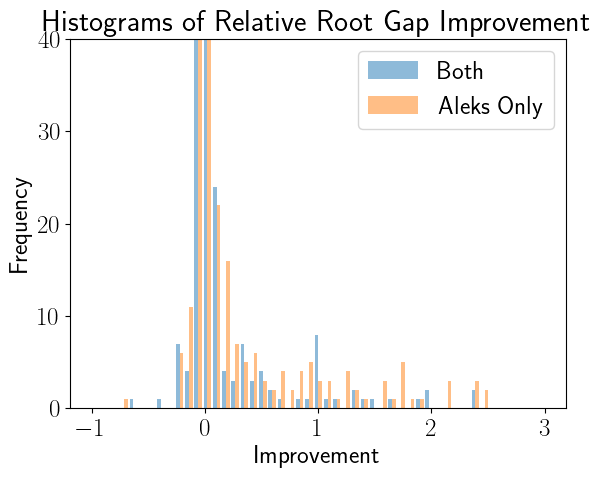

In [363]:
# Plot histograms
plt.hist([diff["improvement aleks"], mdf["improvement"]], bins=np.linspace(-1, 3, 50), alpha=0.5, label=['Both', 'Aleks Only'])

plt.ylim(0, 40)

# Add labels and title
plt.xlabel('Improvement')
plt.ylabel('Frequency')
plt.title('Histograms of Relative Root Gap Improvement')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [364]:
# set the index of mdf to the combination of instance and terms
mdf = mdf.set_index(["instance", "terms"])
mdf

Root Cuts (New)  Root Cuts (None)  \
instance            terms                                      
decomp1             64.0               NaN               NaN   
neos-555424         16.0               NaN               NaN   
                    64.0               NaN               NaN   
shipschedule3shipsi 4.0                NaN               NaN   
                    16.0               NaN               NaN   
...                                    ...               ...   
umts                64.0          0.049433          0.047454   
usAbbrv-8-25_70     64.0          0.000000          0.000000   
vpm1                64.0          0.721295          0.681575   
vpm2                64.0          0.719205          0.718862   
zib54-UUE           64.0          0.681297          0.687208   

                           terminationTime None  improvement  
instance            terms                                     
decomp1             64.0                    NaN          NaN  
neos-555424         16.0                    NaN          NaN  
                    64.0                    NaN          NaN  
shipschedule3shipsi 4.0                     NaN          NaN  
                    16.0                    NaN          NaN  
...                                         ...          ...  
umts                64.0                 49.839     0.041720  
usAbbrv-8-25_70     64.0               3600.000          NaN  
vpm1                64.0                  0.004     0.058276  
vpm2                64.0                  0.098     0.000477  
zib54-UUE           64.0                103.298    -0.008602  

[591 rows x 4 columns]

In [365]:
# classify missing experiment data by excluded instance (either aleks' mislabeled or I just missed), max run time, unperturbable, or run time error
mdf["reason"] = "unknown"

# read in list of dropped instances from aleks' data set
# i think the issue is some aleks tested despite saying he wasn't and others were more than 5k x 5k rows but preprocess to less
dropped = pd.read_csv("dropped.csv", index_col="instance")

for (instance, terms) in mdf.index:
    cur_inst_test_set_fldr = os.path.join(test_set_fldr, instance)
    if instance + ".mps" not in os.listdir(instance_fldr):
        if instance in dropped.index:
            mdf.loc[(instance, terms), "reason"] = "dropped"  # excluded by vpc
        else:
            mdf.loc[(instance, terms), "reason"] = "missed"  # not run yet
    elif mdf.loc[(instance, terms), "terminationTime None"] > 3599:
        mdf.loc[(instance, terms), "reason"] = "max run time"  # hit the max run time
    elif not os.path.exists(cur_inst_test_set_fldr) or not os.listdir(cur_inst_test_set_fldr):
        mdf.loc[(instance, terms), "reason"] = "unperturbable"  # weren't able to perturb
    else:
        mdf.loc[(instance, terms), "reason"] = "runtime error"  # crashed or ran within 1 hour but no results data

In [366]:
# summary stats on where our improving runs are hiding
stats = mdf.groupby("reason").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
stats.rename(columns={"improvement": "count"}, inplace=True)
stats["weighted improvement"] = (stats["Root Cuts (New)"] - stats["Root Cuts (None)"]) * stats["count"]
stats["weighted improvement"] = (stats["weighted improvement"] / stats["weighted improvement"].sum()).round(4)
stats.sort_values("weighted improvement", ascending=False)

reason  Root Cuts (New)  Root Cuts (None)  count  \
2         missed         0.498358          0.450770    300   
0        dropped         0.738627          0.621918     48   
3  runtime error         0.319636          0.281815     77   
1   max run time         0.269524          0.267290     55   
4  unperturbable         0.523079          0.521500     23   

   weighted improvement  
2                0.6221  
0                0.2441  
3                0.1269  
1                0.0054  
4                0.0016

In [367]:
# track down the experiments we excluded because we missed creating them
# stein9 is an outlier pushing things up
missing = mdf[mdf["reason"] == "missed"]
missing

Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance       terms                                                            
bc             4.0           0.302212          0.302552                35.878   
bc1            4.0           0.427863          0.448678                 6.347   
bell3a         4.0           0.478648          0.478648                 0.214   
bell3b         4.0           0.901596          0.491740                 0.121   
bell5          4.0           0.284498          0.294200                 0.038   
...                               ...               ...                   ...   
stein45_nocard 64.0          0.590909          0.263384                 3.653   
tanglegram2    64.0          1.000000          0.980850                 0.047   
timtab2        64.0          0.480566          0.476907              3600.000   
vpm2           64.0          0.719205          0.718862                 0.098   
zib54-UUE      64.0          0.681297          0.687208               103.298   

                      improvement  reason  
instance       terms                       
bc             4.0      -0.001122  missed  
bc1            4.0      -0.046393  missed  
bell3a         4.0       0.000000  missed  
bell3b         4.0       0.833481  missed  
bell5          4.0      -0.032977  missed  
...                           ...     ...  
stein45_nocard 64.0      1.243528  missed  
tanglegram2    64.0      0.019524  missed  
timtab2        64.0      0.007673  missed  
vpm2           64.0      0.000477  missed  
zib54-UUE      64.0     -0.008602  missed  

[322 rows x 5 columns]

In [368]:
# let's look at what aleks "missed"
aleks_missing = both.loc[pd.isna(both["Root Cuts (New) aleks"])].drop_duplicates("instance").sort_values("instance")
aleks_missing["row"], aleks_missing["col"], aleks_missing["source"] = 0, 0, "unknown"
aleks_missing.set_index("instance", inplace=True)

# get problem size
for instance in aleks_missing.index:
    aleks_missing.loc[instance, "row"] = rows.get(instance, 0)
    aleks_missing.loc[instance, "col"] = cols.get(instance, 0)
    
# get source of instance
for instance in aleks_missing.index:
    for fldr in os.listdir("../../"):
        if not os.path.isdir(f"../../{fldr}"):
            continue
        if instance + ".mps" in os.listdir(f"../../{fldr}") or instance + ".mps.gz" in os.listdir(f"../../{fldr}"):
            aleks_missing.loc[instance, "source"] = fldr

# trim down to what we want - looks like mas misnamed but otherwise we are good
aleks_missing = aleks_missing[["row", "col", "source"]]
aleks_missing

row    col      source
instance                                        
10teams                   230   2025     miplib3
app2-2                    335   1226  miplib2017
app3                      766   3080  miplib2017
arki001                  1048   1388     miplib3
beavma                    372    390  miplib2017
bppc8-02                   59    232  miplib2017
ci-s4                   26159    745  miplib2017
decomp1                  8357  10735  miplib2017
f2gap401600                40   1600  miplib2017
f2gap801600                80   1600  miplib2017
gen-ip054                  27     30  miplib2017
haprp                    1048   1828  miplib2017
irp                        39  20315  miplib2017
milo-v12-6-r2-40-1       5628   2688  miplib2017
n2seq36f                  285   8100  miplib2017
neos-1445738             2145  20631  miplib2017
neos-1445743             2148  20344  miplib2017
neos-1445765             2147  20617  miplib2017
neos-3068746-nene        4664   4890  miplib2017
neos-3075395-nile       27756  26928  miplib2017
neos-3118745-obra         144   1131  miplib2017
neos-3734794-moppy       4317   4418  miplib2017
neos-555424              2676   3815  miplib2017
neos-860300               850   1385  miplib2017
ns4-pr6                  2639   6919  miplib2017
pigeon-20                3661   1580  miplib2017
piperout-d27            17470  13104  miplib2017
radiationm18-12-05      40935  40623  miplib2017
shipschedule3shipsi     10431   7365  miplib2017
shipschedule6shipsmixi  18307  14012  miplib2017
supportcase27i           2104   2281  miplib2017
uct-subprob              1973   2256  miplib2017

In [119]:
# now lets track down which error modes are sinking us most
run_error = mdf[mdf["reason"] == "runtime error"]

# collect the ways each instance/term combination fails
err_map = []

# iterate over instances and terms of aleks' tests we're missing because of run errors
for instance, terms in run_error.index:
    terms = int(terms)
    found_err = False
    
    # iterate over our error modes to find matches
    for mode, failed_experiments in err.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                
                # if we find a match, see if we can get a more specific error mode
                sub_mode = mode
                if sub_mode == "no vpcs were made from a new disjunction":
                    sub_mode = [vpc_err_mode for vpc_err_mode, vpc_err_exps in vpc_err.items()
                            if failed_experiment in vpc_err_exps].pop()
                
                # append the mode
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": sub_mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # do the same thing as the above for all other termination modes
    misc = {"other": other, "warning": warning, "empty": empty}
    for mode, failed_experiments in misc.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # double check to make sure we didn't miss any of aleks' runs for another reason
    if not found_err:
        print("no code for", instance, terms)
        
# add the error mode to the dataframe
run_error = pd.merge(run_error, pd.DataFrame(err_map).set_index(["instance", "terms"]), left_index=True, right_index=True)

# now drop the runs that showed up as failures only because their siblings failed
empty = run_error[(run_error["mode"] == "empty")]
non_empty = run_error[run_error["mode"] != "empty"]
collateral = pd.merge(empty, non_empty[["experiment group", "experiment"]],
                      on="experiment group", how="left", suffixes=("", " collateral"))
false_negs = collateral.loc[~collateral["experiment collateral"].isna(), "experiment"].unique()
run_error = run_error[~run_error["experiment"].isin(false_negs)]

run_error

no code for a2c1s1 4
no code for neos5 4
no code for a2c1s1 16
no code for neos5 16
no code for a2c1s1 64
no code for neos5 64


Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
22433    16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
22433    16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
...                     ...            ...   
umts     64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   

                                                             mode  \
instance terms                                                      
22433    16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                 experiment      experiment group cut type  
instance terms                                                              
22433    16.0      22433_objective_1_16_New  22433_objective_1_16      New  
         16.0      22433_objective_1_16_Old  22433_objective_1_16      Old  
         16.0   22433_objective_1_16_Farkas  22433_objective_1_16   Farkas  
         16.0         22433_matrix_1_16_New     22433_matrix_1_16      New  
         16.0         22433_matrix_1_16_Old     22433_matrix_1_16      Old  
...                                     ...                   ...      ...  
umts     64.0      umts_objective_-1_64_Old  umts_objective_-1_64      Old  
         64.0   umts_objective_-1_64_Farkas  umts_objective_-1_64   Farkas  
         64.0           umts_bound_1_64_New       umts_bound_1_64      New  
         64.0           umts_bound_1_64_Old       umts_bound_1_64      Old  
         64.0        umts_bound_1_64_Farkas       umts_bound_1_64   Farkas  

[1671 rows x 9 columns]

In [120]:
# summary stats on where improvements are by failure mode
run_error_stats = run_error.groupby("mode").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
run_error_stats.rename(columns={"improvement": "count"}, inplace=True)
run_error_stats["weighted improvement"] = (run_error_stats["Root Cuts (New)"] - run_error_stats["Root Cuts (None)"]) * run_error_stats["count"]
run_error_stats["weighted improvement"] = (run_error_stats["weighted improvement"] / run_error_stats["weighted improvement"].sum()).round(4)
run_error_stats.sort_values("weighted improvement", ascending=False)

mode  Root Cuts (New)  \
3   CglVPC: Finishing with exit reason: OPTIMAL_SO...         0.509986   
7                                           bad_alloc         0.434958   
5   CglVPC: Finishing with exit reason: PRLP_TIME_...         0.361451   
2   CglVPC: Finishing with exit reason: NO_DISJUNC...         0.309472   
0      CglVPC: Finishing with exit reason: FAIL_LIMIT         0.844483   
6      CglVPC: Finishing with exit reason: TIME_LIMIT         0.394754   
8            dot product with obj differs from solver         0.771781   
9          must have primalbound >= root lp objective         0.441229   
1   CglVPC: Finishing with exit reason: NO_CUTS_LI...         0.071182   
10                                            warning         0.431084   
4   CglVPC: Finishing with exit reason: PRLP_INFEA...         0.089971   

    Root Cuts (None)  count  weighted improvement  
3           0.311466    162                0.6497  
7           0.277109     71                0.2264  
5           0.344290    360                0.1248  
2           0.302437     93                0.0132  
0           0.843900     18                0.0002  
6           0.394694     63                0.0001  
8           0.773766      1               -0.0000  
9           0.444428      9               -0.0006  
1           0.071550    108               -0.0008  
10          0.434163     20               -0.0012  
4           0.114161     24               -0.0117

In [121]:
# todo: find out range of terms for time outs (are most because big tree?)
prlp_limit = run_error[run_error["mode"] == "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]
prlp_limit

Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
30n20b8  4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
30n20b8  4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
...                     ...            ...   
umts     64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   

                                                             mode  \
instance terms                                                      
30n20b8  4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                  experiment       experiment group cut type  
instance terms                                                                
30n20b8  4.0       30n20b8_objective_1_4_New  30n20b8_objective_1_4      New  
         4.0       30n20b8_objective_1_4_Old  30n20b8_objective_1_4      Old  
         4.0    30n20b8_objective_1_4_Farkas  30n20b8_objective_1_4   Farkas  
         4.0            30n20b8_rhs_-1_4_New       30n20b8_rhs_-1_4      New  
         4.0            30n20b8_rhs_-1_4_Old       30n20b8_rhs_-1_4      Old  
...                                      ...                    ...      ...  
umts     64.0       umts_objective_-1_64_Old   umts_objective_-1_64      Old  
         64.0    umts_objective_-1_64_Farkas   umts_objective_-1_64   Farkas  
         64.0            umts_bound_1_64_New        umts_bound_1_64      New  
         64.0            umts_bound_1_64_Old        umts_bound_1_64      Old  
         64.0         umts_bound_1_64_Farkas        umts_bound_1_64   Farkas  

[432 rows x 9 columns]

In [122]:
# figure out actual disjunction sizes in experiments
# a regex that matches "solving for term \d+/\d+" and captures the second number
term_regex = re.compile(r"Solving for term \d+/(\d+)")

# compare timed out PRLPs to non-timed out PRLPs
actual_terms = {}
provided_terms = {}
missed_terms = []
aleks_terms = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:
                
                val = df.loc[(df["instance"] == instance) & (df["perturbation"] == perturbation.split("_")[0]) &
                             (df["terms"] == terms) & (df["instanceIndex"] == 0), "actualTerms New"].mean()

                # get the out file for this experiment
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                provided_terms[stem] = terms
                out_file_pth = os.path.join(results_fldr, f"{stem}.out")
                if not os.path.exists(out_file_pth):
                    continue

                # read the out file
                with open(out_file_pth, "r") as f:
                    text = f.read()
                
                # search for the regex in the text
                matches = term_regex.findall(text)
                
                if matches:
                    actual_terms[stem] = int(matches[-1])
                    if generator == "Farkas":
                        aleks_terms[instance, terms] = aleks_terms.get((instance, terms), []) + [int(matches[-1])]
                else:
                    missed_terms.append(stem)
                    
# get average sized disjunction for aleks' runs
aleks_terms = {k: {"actual terms": np.mean(v)} for k, v in aleks_terms.items()}
                    
len(missed_terms) / len(provided_terms)

0.2856330553449583

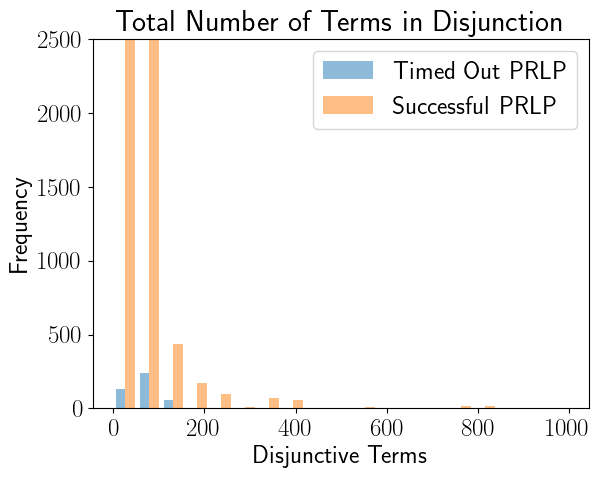

In [123]:
# plot whether or not number of disjunctive terms has an effect on timing out
actual_term_failures = [terms for stem, terms in actual_terms.items()
                        if stem in prlp_limit["experiment"].values]
actual_term_success = [terms for stem, terms in actual_terms.items()
                       if stem not in prlp_limit["experiment"].values]

deciles = {
    "success": {i * 10: np.percentile(actual_term_success, i * 10) for i in range(1, 10)},
    "failure": {i * 10: np.percentile(actual_term_failures, i * 10) for i in range(1, 10)}
}

# Plot histograms
plt.hist([actual_term_failures, actual_term_success], bins=np.linspace(0, 1000, 20), alpha=0.5, label=['Timed Out PRLP', 'Successful PRLP'])

# Add labels and title
plt.xlabel('Disjunctive Terms')
plt.ylabel('Frequency')
plt.title(f'Total Number of Terms in Disjunction')

# set y limit
plt.ylim(0, 2500)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [124]:
# get deciles on number of rows or disjunctive terms for failed and successful PRLP solves
pd.DataFrame(deciles)

success  failure
10      4.0      4.0
20      4.0     16.0
30      4.0     28.0
40     16.0     64.0
50     19.0     64.0
60     45.0     66.0
70     64.0     73.0
80     66.0     89.0
90     95.0    125.0

In [125]:
# what do improvements look like in terms of disjunctive terms
adf

instance  terms   lpBound New disjunctiveDualBound New  \
0               22433    2.0  2.124053e+04              21314.98074   
1               23588    2.0  7.649866e+03              7746.197749   
2             10teams    2.0  9.170000e+02                      917   
3             30n20b8    2.0  1.241230e+02              124.2095421   
4              50v-10    2.0  2.879066e+03              2884.065687   
...               ...    ...           ...                      ...   
2635             umts   64.0  2.912957e+07              29131573.54   
2636  usAbbrv-8-25_70   64.0  9.500000e+01                       95   
2637             vpm1   64.0  1.643333e+01              16.71111111   
2638             vpm2   64.0  1.113563e+01               11.5093094   
2640        zib54-UUE   64.0  4.330388e+06              5389605.005   

      lpBoundPostVpc New  rootDualBound None  rootDualBound New  \
0           2.131206e+04        2.141369e+04       2.140756e+04   
1           7.726713e+03        7.757177e+03       7.789200e+03   
2           9.170000e+02        9.240000e+02       9.240000e+02   
3           1.241823e+02        1.542021e+02       1.528972e+02   
4           2.884066e+03        3.195241e+03       3.199688e+03   
...                  ...                 ...                ...   
2635        2.913061e+07        2.917562e+07       2.917754e+07   
2636        9.500000e+01        9.500000e+01       9.500000e+01   
2637        1.660000e+01        1.886429e+01       1.900595e+01   
2638        1.134045e+01        1.305095e+01       1.305186e+01   
2640        4.850439e+06        8.432754e+06       8.397464e+06   

      primalBound None  terminationTime None  Root Cuts (New)  \
0              21500.0                 0.078         0.643722   
1               8090.0                 0.419         0.316571   
2                924.0                 0.303         1.000000   
3                302.0                13.008         0.161765   
4               3310.0              1928.063         0.744017   
...                ...                   ...              ...   
2635        30100000.0                49.839         0.049433   
2636             120.0              3600.000         0.000000   
2637              20.0                 0.004         0.721295   
2638              13.8                 0.098         0.719205   
2640        10300000.0               103.298         0.681297   

      Root Cuts (None)  
0             0.667379  
1             0.243813  
2             1.000000  
3             0.169100  
4             0.733697  
...                ...  
2635          0.047454  
2636          0.000000  
2637          0.681575  
2638          0.718862  
2640          0.687208  

[2059 rows x 11 columns]

In [126]:
# augment aleks' results with actual disjunctive terms
atdf = pd.DataFrame.from_dict(aleks_terms, orient="index").reset_index()
atdf.columns = ["instance", "terms", "actual terms"]
atdf = pd.merge(adf, atdf, on=["instance", "terms"])
atdf = atdf[atdf["terms"] == 64]
atdf["term group"] = "None"
atdf.set_index("instance", inplace=True)
for instance in atdf.index:
    atdf.loc[instance, "term group"] = "64" if atdf.loc[instance, "actual terms"] == 64 else \
        "65 - 69" if 65 <= atdf.loc[instance, "actual terms"] <= 69 else \
        "70 - 79" if 70 <= atdf.loc[instance, "actual terms"] <= 79 else \
        "80 - 89" if 80 <= atdf.loc[instance, "actual terms"] <= 89 else \
        "90 - 99" if 90 <= atdf.loc[instance, "actual terms"] <= 99 else \
        "100 - 199" if 100 <= atdf.loc[instance, "actual terms"] <= 199 else \
        "200 - 299" if 200 <= atdf.loc[instance, "actual terms"] <= 299 else \
        "300 - 399" if 300 <= atdf.loc[instance, "actual terms"] <= 399 else \
        "400 - 499" if 400 <= atdf.loc[instance, "actual terms"] <= 499 else \
        "500 - 749" if 500 <= atdf.loc[instance, "actual terms"] <= 749 else \
        "750 - 999" if 750 <= atdf.loc[instance, "actual terms"] <= 999 else "1000+"
atdf

terms   lpBound New disjunctiveDualBound New  \
instance                                                       
23588            64.0  7.649866e+03              7967.565214   
30n20b8          64.0  1.241230e+02              126.9060983   
50v-10           64.0  2.879066e+03              2956.881654   
a1c1s1           64.0  4.649668e+03              4985.201862   
aflow30a         64.0  9.831674e+02              1013.177723   
...               ...           ...                      ...   
tr12-30          64.0  2.530221e+04              27137.94988   
traininstance2   64.0  0.000000e+00                        0   
traininstance6   64.0  0.000000e+00                        0   
uct-subprob      64.0  2.420000e+02               248.961794   
umts             64.0  2.912957e+07              29131573.54   

                lpBoundPostVpc New  rootDualBound None  rootDualBound New  \
instance                                                                    
23588                 7.965067e+03        7.757177e+03       7.965776e+03   
30n20b8                        NaN        0.000000e+00       0.000000e+00   
50v-10                2.927394e+03        3.195241e+03       3.200751e+03   
a1c1s1                         NaN        0.000000e+00       0.000000e+00   
aflow30a              1.012586e+03        1.096636e+03       1.095069e+03   
...                            ...                 ...                ...   
tr12-30               2.580549e+04        1.290671e+05       1.292165e+05   
traininstance2                 NaN        0.000000e+00       0.000000e+00   
traininstance6                 NaN        0.000000e+00       0.000000e+00   
uct-subprob           2.465241e+02        2.768930e+02       2.770518e+02   
umts                  2.913061e+07        2.917562e+07       2.917754e+07   

                primalBound None  terminationTime None  Root Cuts (New)  \
instance                                                                  
23588                     8090.0                 0.421         0.717759   
30n20b8                    302.0                 0.000         0.697802   
50v-10                    3310.0              1770.796         0.746484   
a1c1s1                   11500.0                 0.000         0.678751   
aflow30a                  1160.0                 2.305         0.632812   
...                          ...                   ...              ...   
tr12-30                 131000.0                69.269         0.983126   
traininstance2           71800.0                 0.000         0.000000   
traininstance6           28300.0                 0.000         0.000000   
uct-subprob                314.0               879.891         0.486831   
umts                  30100000.0                49.839         0.049433   

                Root Cuts (None)  actual terms term group  
instance                                                   
23588                   0.243813          66.0    65 - 69  
30n20b8                 0.697802         151.0  100 - 199  
50v-10                  0.733697          64.0         64  
a1c1s1                  0.678751          64.0         64  
aflow30a                0.641674         102.0  100 - 199  
...                          ...           ...        ...  
tr12-30                 0.981713          64.0         64  
traininstance2          0.000000          70.0    70 - 79  
traininstance6          0.000000          95.0    90 - 99  
uct-subprob             0.484625          64.0         64  
umts                    0.047454          73.0    70 - 79  

[166 rows x 12 columns]

In [127]:
# summary stats on where improvements are by disjunction size for 64 term runs
actual_term_stats = atdf.groupby("term group").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'actual terms': 'count'}).reset_index()
actual_term_stats.rename(columns={"actual terms": "count"}, inplace=True)
actual_term_stats["weighted improvement"] = (actual_term_stats["Root Cuts (New)"] - actual_term_stats["Root Cuts (None)"]) * actual_term_stats["count"]
actual_term_stats["weighted improvement"] = (actual_term_stats["weighted improvement"] / actual_term_stats["weighted improvement"].sum()).round(4)
actual_term_stats.sort_values("weighted improvement", ascending=False)

term group  Root Cuts (New)  Root Cuts (None)  count  weighted improvement
3         64         0.541543          0.520073     82                0.3365
4    65 - 69         0.509274          0.469424     32                0.2437
1  200 - 299         0.494808          0.308327      4                0.1426
6    80 - 89         0.359922          0.317667     11                0.0888
2  300 - 399         0.493920          0.279814      2                0.0818
5    70 - 79         0.396822          0.363190     12                0.0771
0  100 - 199         0.553443          0.545504     19                0.0288
7    90 - 99         0.302498          0.301863      4                0.0005

In [1]:
# break down size outs by number of terms